# Time Series Analysis Final Project

Authors:
 - Emilia Gawenda
 - Marlena Kozieł
 - Kamil Burkiewicz
 - Karol Twardosz

## Packages and initial setup

In [1]:
options(Ncpus=8)

packages <- list(
    "randtests",
    "tseries",
    "forecast",
    "astsa"
)

install.packages(setdiff(packages, rownames(installed.packages())))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



ERROR: Error in available[p1, dependencies, drop = FALSE]: invalid subscript type 'list'


In [2]:
install.packages("randtests")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
install.packages("tseries")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘zoo’, ‘quantmod’




In [4]:
install.packages("forecast")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’




In [5]:
install.packages( "astsa")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
library(repr)
library(randtests)
library(tseries)
library(forecast)
library(astsa)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘tseries’


The following object is masked from ‘package:randtests’:

    runs.test



Attaching package: ‘astsa’


The following object is masked from ‘package:forecast’:

    gas




In [7]:
options(repr.plot.width=18, repr.plot.height=12)

In [8]:
fplot <- function (f, ...) {
    old.par <- par(mar = c(1, 2, 2, 1) + 6., cex.lab=2.4, cex.main=3., cex.axis=1.5, lwd=1.8)
    f(...)
    par(old.par)
}

# Task 1 🐱 Meow

In [9]:
download.file("https://drive.google.com/uc?id=1mj21v_fhL20InQfu-8ELoon2H1csXBgS&authuser=0&export=download&confirm=t", destfile = "DP_LIVE_18102020154144776.csv")
download.file("https://drive.google.com/uc?id=16UyTpOJUk4ne1zNgbpx5FowpBbvQVj09&authuser=0&export=download&confirm=t", destfile = "dane_TBGK3.csv")

### Data input  🐁

We are importing Karol's dataset, i.e  Australian healthcare spent over time.

This dataset provides an overview of global health spending by country from 1971 to 2017


*  LOCATION: Country or region of the data. (String)
*  INDICATOR: Health spending indicator. (String)
*  SUBJECT: Health spending subject. (String)
*  MEASURE: Measurement of health spending. (String)
*   FREQUENCY: Frequency of data collection. (String)
*  TIME: Year of data collection. (Integer)
*  Value: Value of health spending. (Float)
*  Flag Codes: Codes related to data quality. (String)



We are interested in three columns:
"Value", "LOCATION" and "MEASURE". New dataframe is assigned to variable **subspent**.

subsequently we extracted data about Australia, measured in USD (LOCATION == "AUS", MEASURE == "USD"), then stored data in **subsubspent**.

In [10]:
health_spent<-read.csv(file="/content/DP_LIVE_18102020154144776.csv")
subspent<-subset(health_spent,select=c("Value","LOCATION","MEASURE"))
subsubspent<-subspent[subspent$LOCATION == "AUS" & subspent$MEASURE == "USD_CAP",]

tsr <- ts(subsubspent[c("Value")],start=c(1971,1),end=c(2017,1),frequency=1)

Time series starts in 1971 and ends in 2017

In [11]:
tsr

A Time Series:
 [1]  38.036  41.058  45.525  63.485  60.046  63.861  63.612  76.501  83.368
[10]  95.422  99.479  95.790 112.754 114.296 125.515 132.674 140.866 161.565
[19] 176.613 198.063 216.468 233.118 246.760 262.612 259.602 293.664 308.676
[28] 387.179 386.848 452.207 467.919 494.223 493.458 541.335 564.235 591.511
[37] 607.639 637.921 651.966 710.008 730.301 768.307 806.565 821.773 830.095
[46] 844.630 845.174

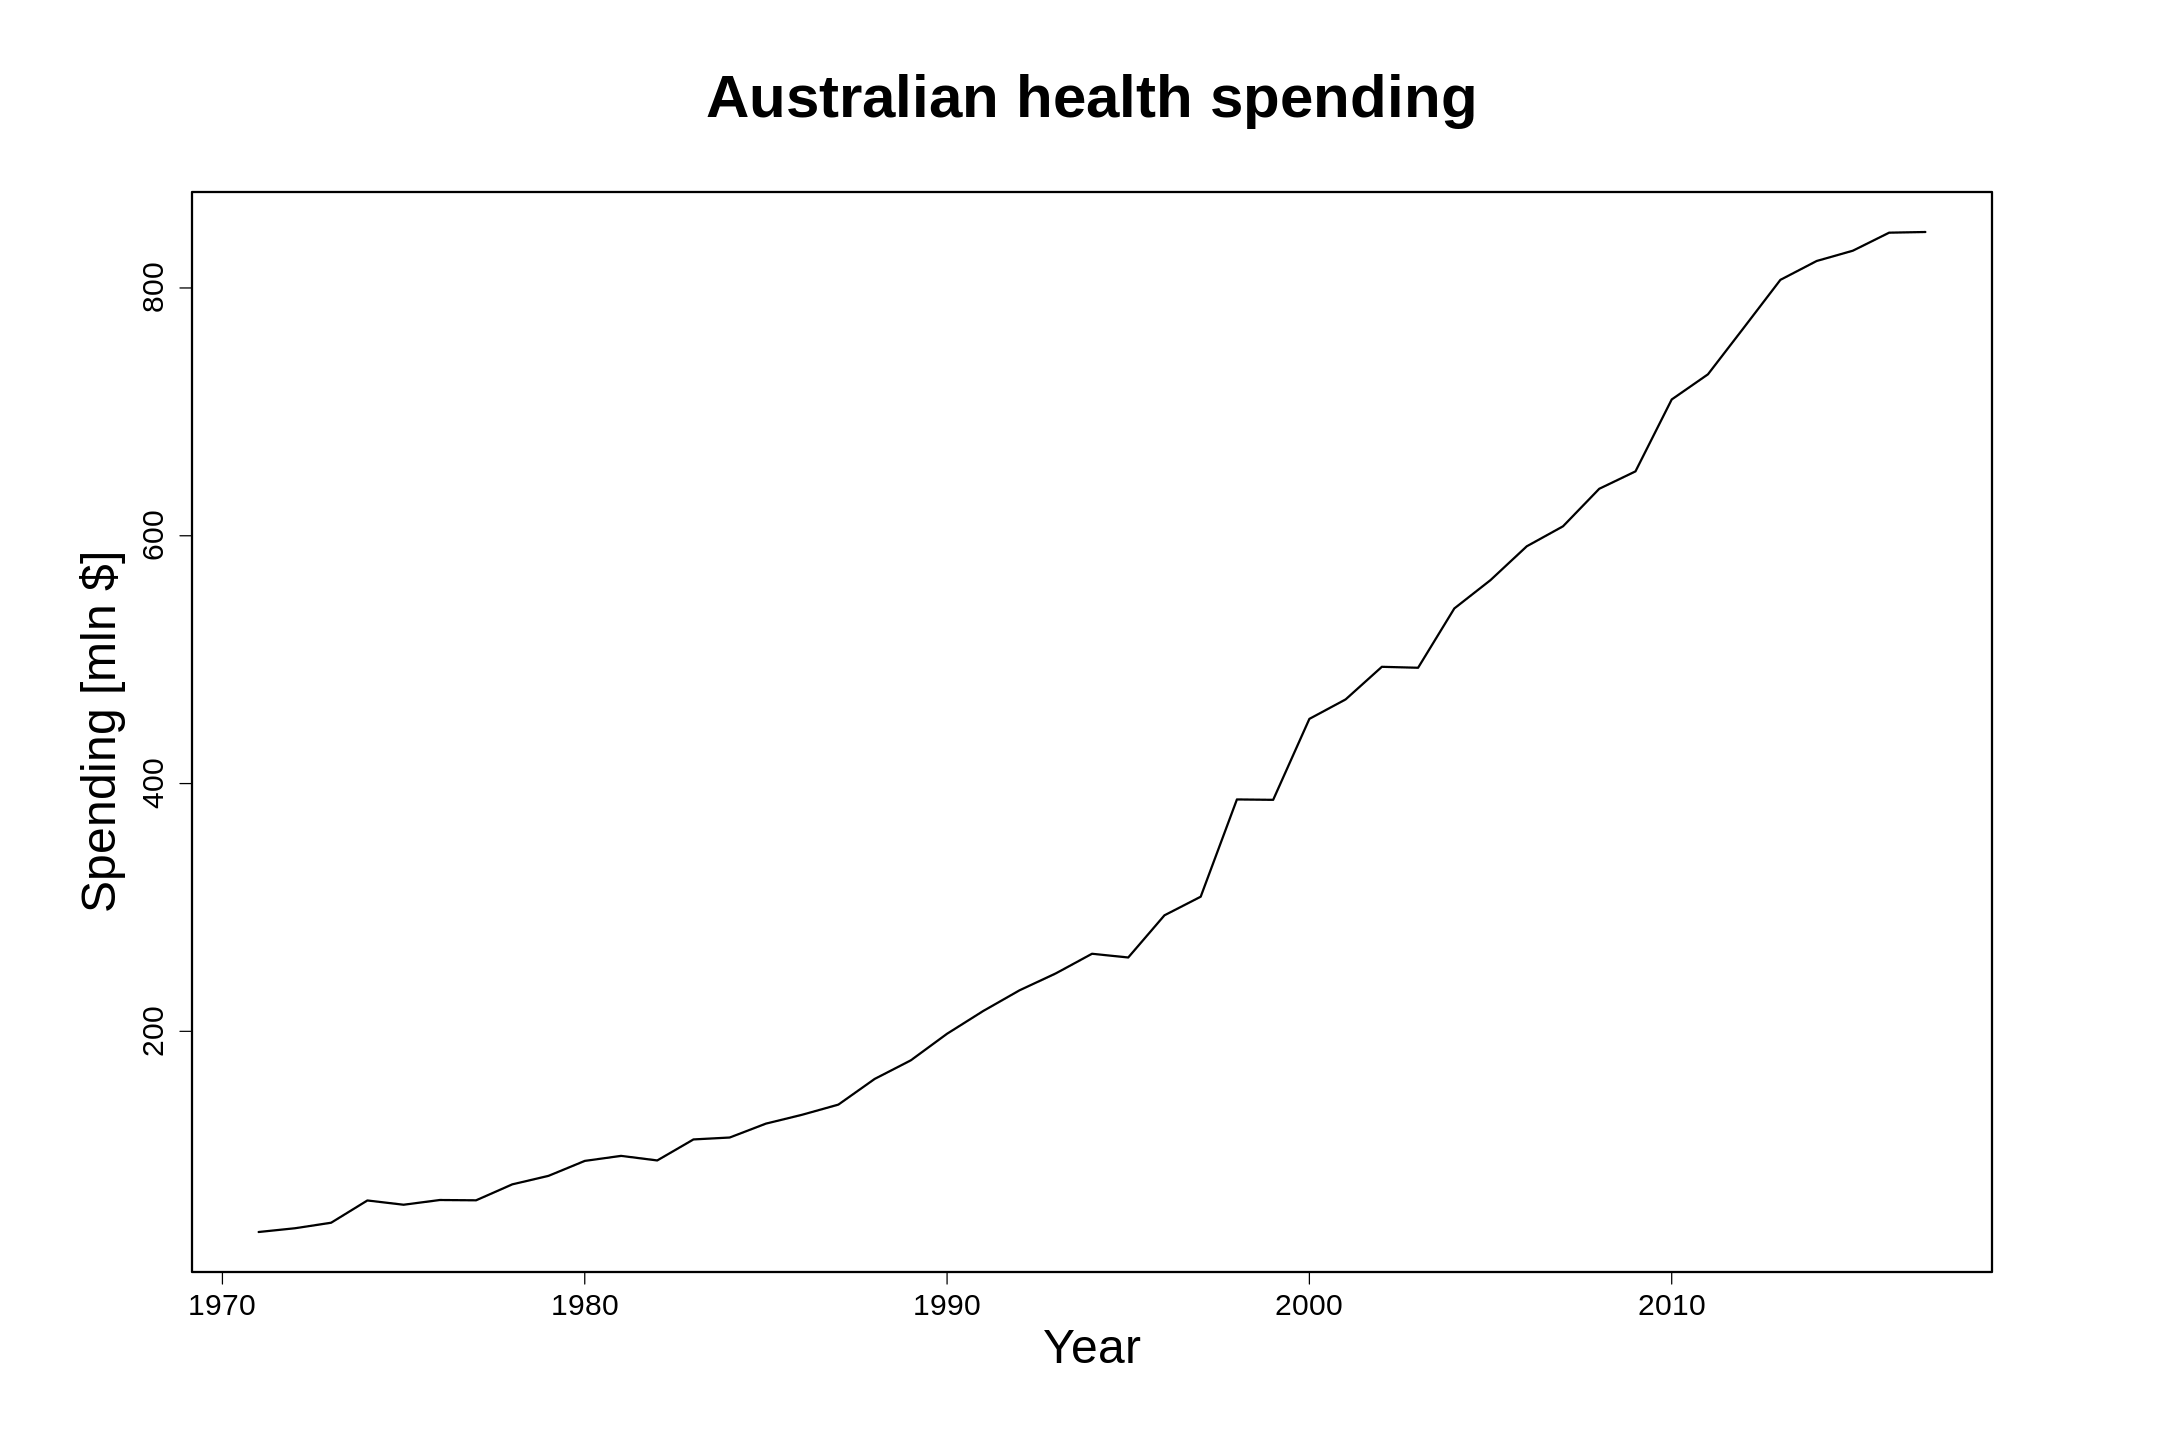

In [12]:
fplot(plot, tsr,ylab="Spending [mln $]", xlab="Year", main="Australian health spending")

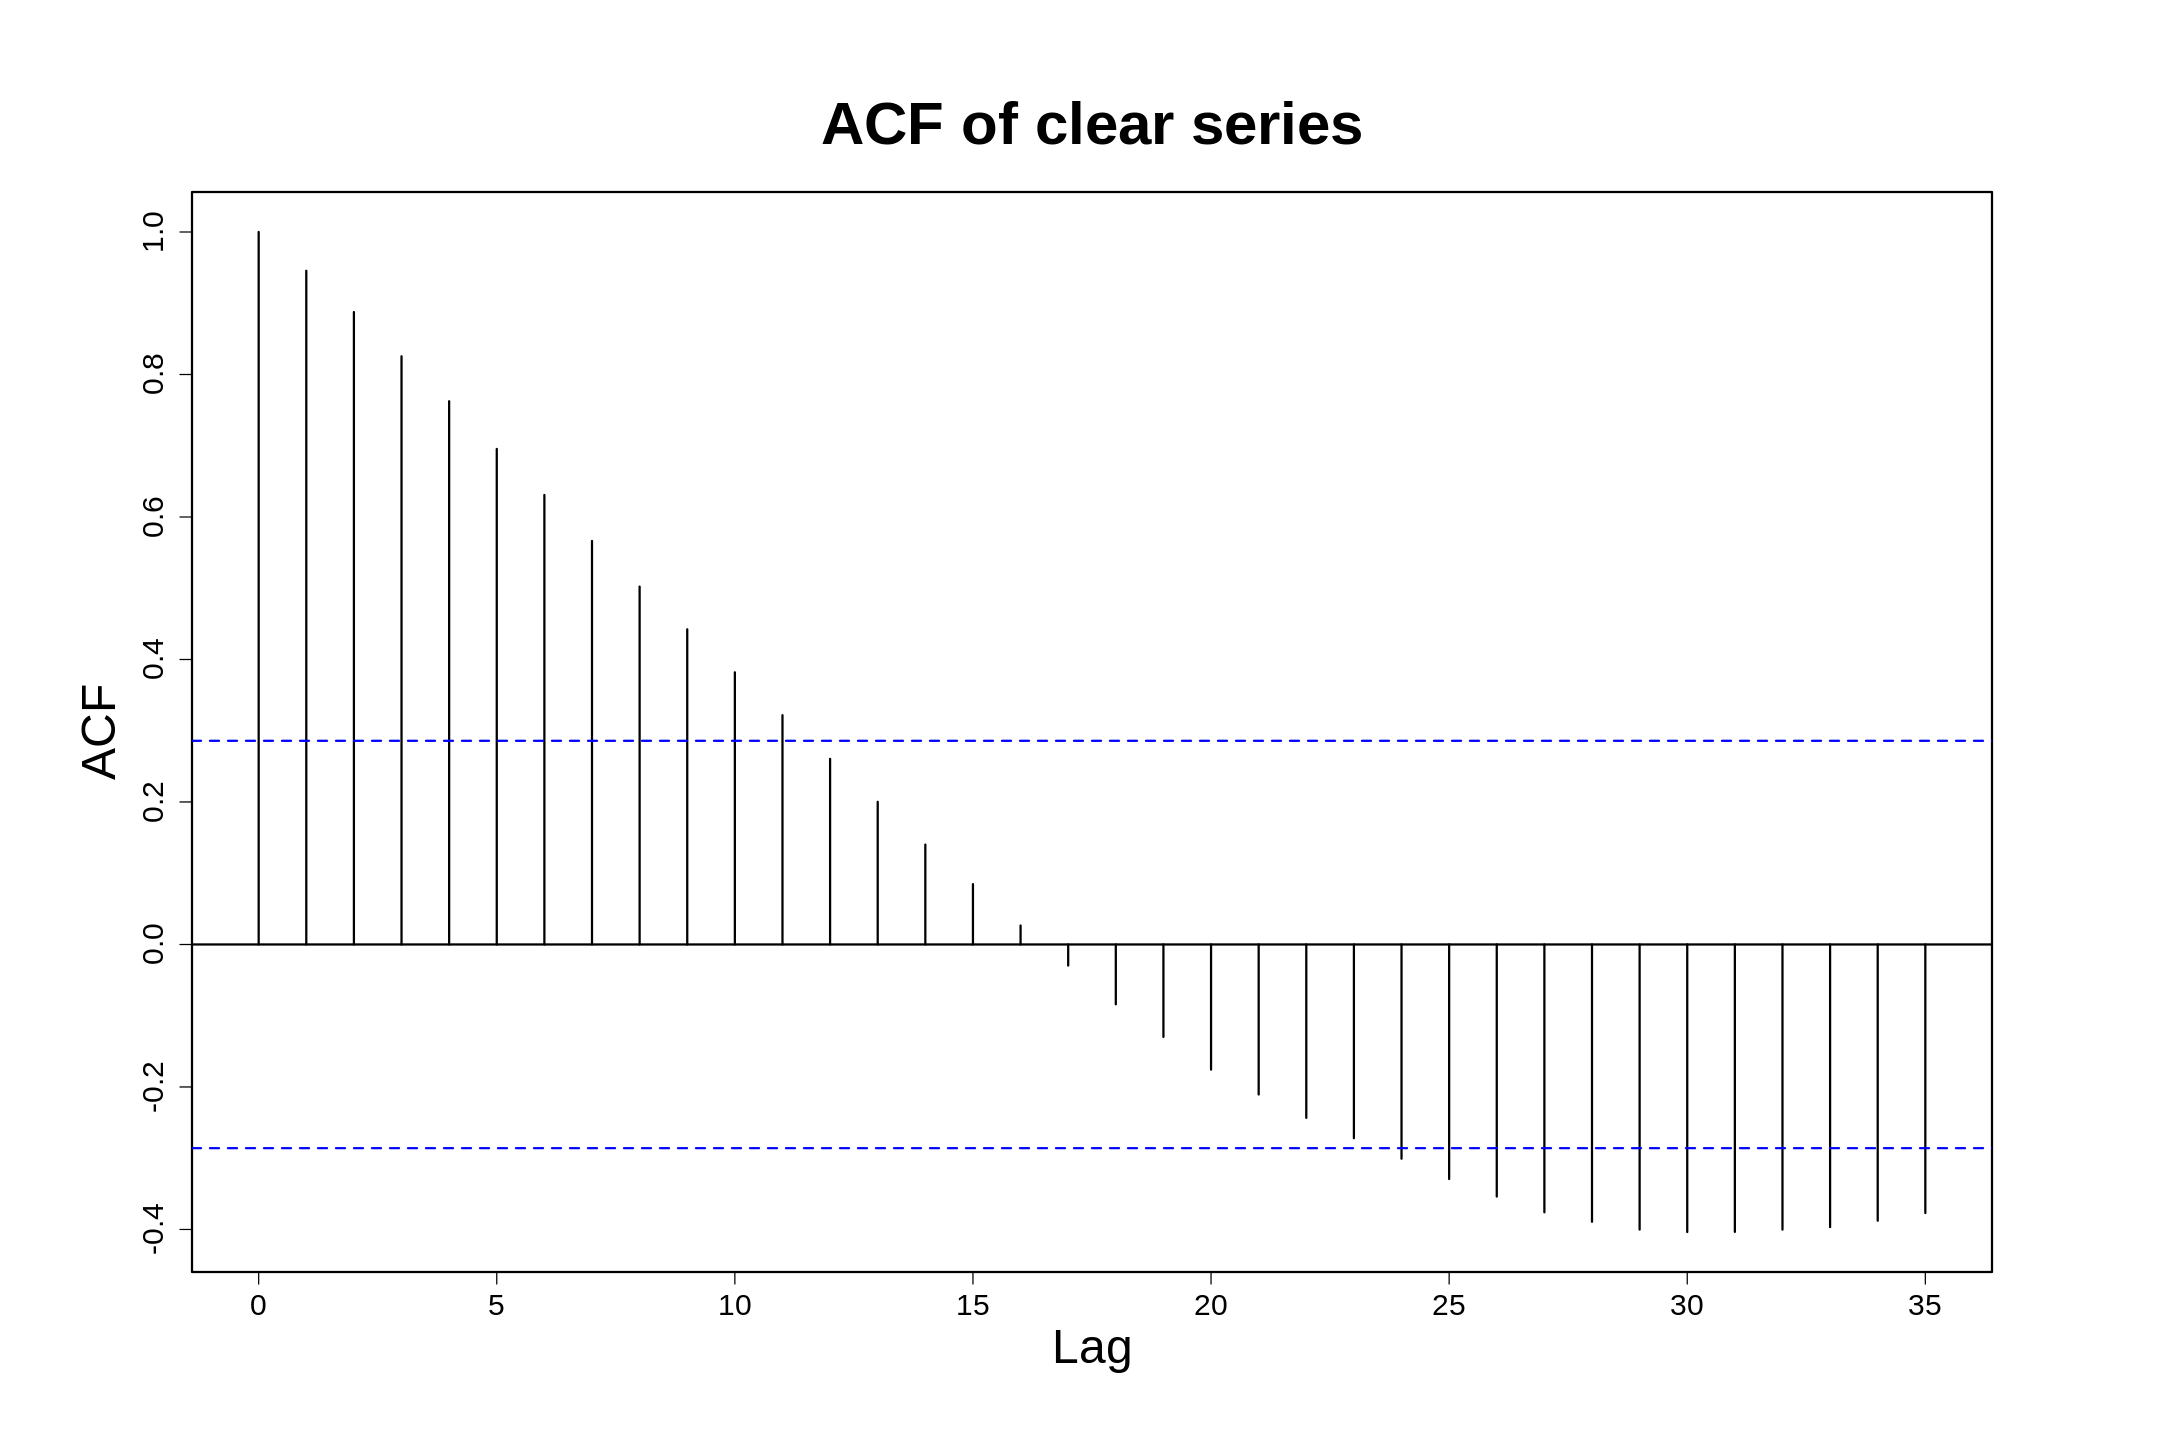

In [13]:
fplot(acf, tsr, main="ACF of clear series", lag=35)

It is clear that the series is nonstationary, but we are performing the Dickey-Fuller test to confirm this.

Test Dickeya-Fullera (ADF)

In [14]:
adf.test(tsr)


	Augmented Dickey-Fuller Test

data:  tsr
Dickey-Fuller = -2.4281, Lag order = 3, p-value = 0.4035
alternative hypothesis: stationary


Augmented Dickey-Fuller Test outputs p-value of 0.40, which on the 5% significance level, we cannot reject the null hypothesis that our time series is non-stationary.

## Transformation 🐡

We suspect that with the increase of spending in time, the variance increases as well. Therefore, we start with the use of BoxCox transform.

We calculate the optimal value of \lambda for the Box-Cox transformation, which allows us to stabilize the variance in the time series tsr and make the data more stationary.


In [15]:
lambda <- BoxCox.lambda(tsr)
lambda

[1] 0.5367728

In [16]:
tsbc <- BoxCox(tsr, lambda = lambda)

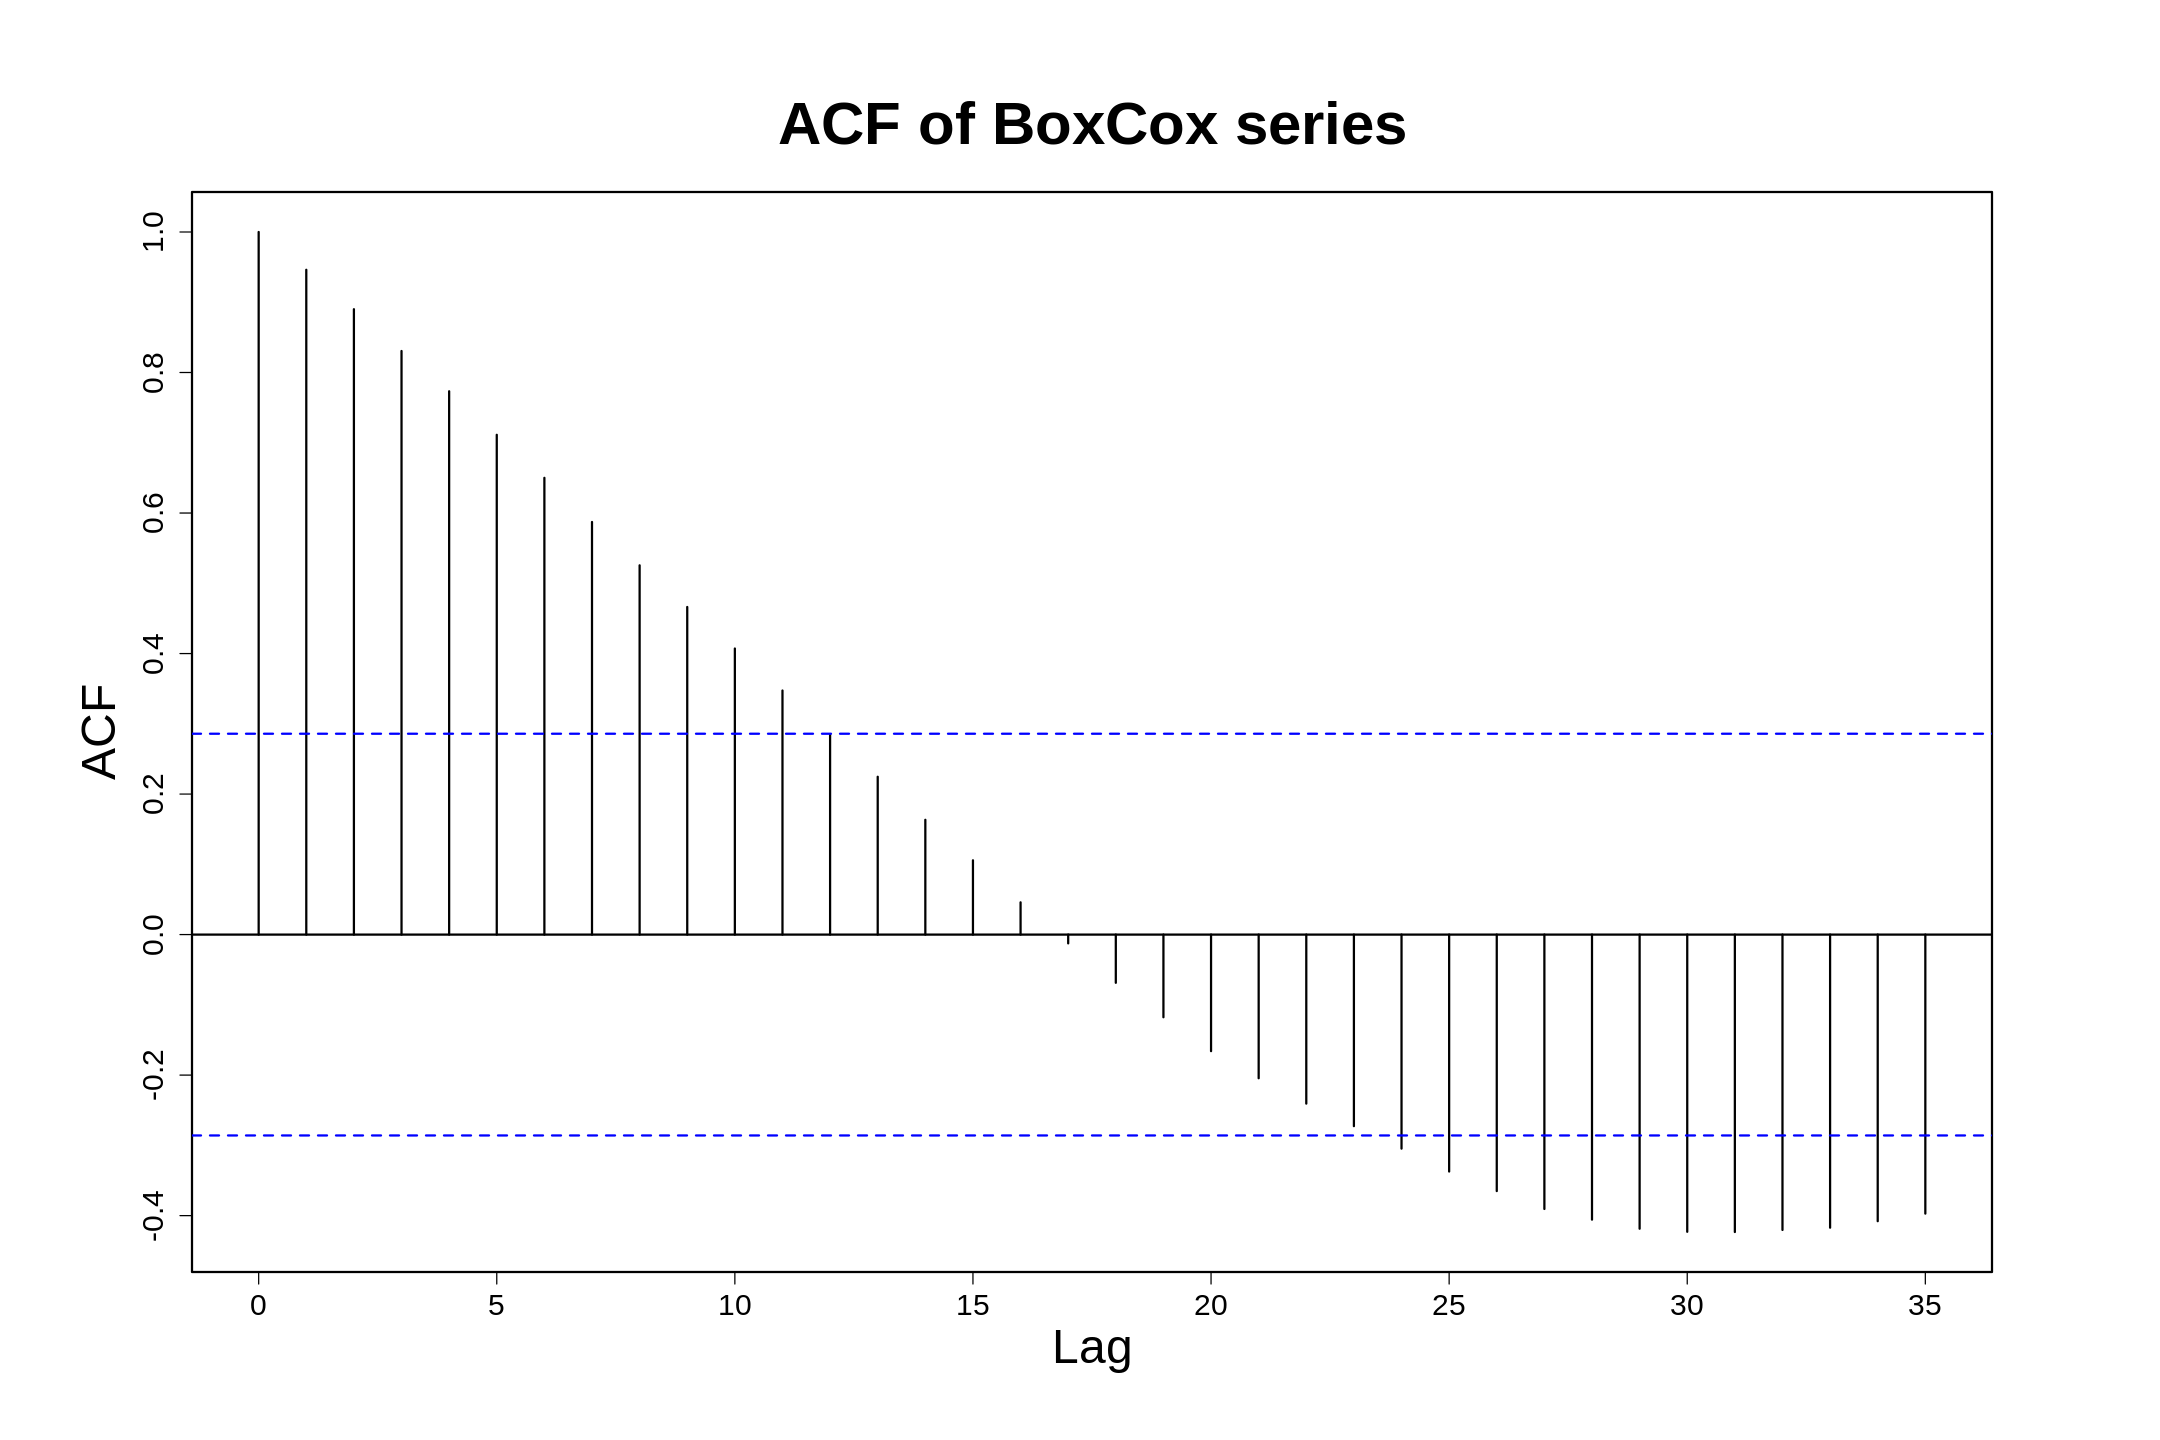

In [17]:
fplot(acf, tsbc, main="ACF of BoxCox series", lag=35)

Data still nonstationary.
  
  *	Autocorrelation decreases very slowly (gradually fades) as the lag increases.
	*	High autocorrelation values for many lags indicate the presence of a trend in the data.

In [18]:
adf.test(tsbc)


	Augmented Dickey-Fuller Test

data:  tsbc
Dickey-Fuller = -2.8896, Lag order = 3, p-value = 0.2196
alternative hypothesis: stationary


BoxCox transform reduced p-value, yet not succeded in bringing it under the 0.05 threshold. Therefore, we need to use other types of transformations to provide stationarity of our transformed data. We tried differentiation.

In [19]:
tsbcdf <- diff(tsbc)

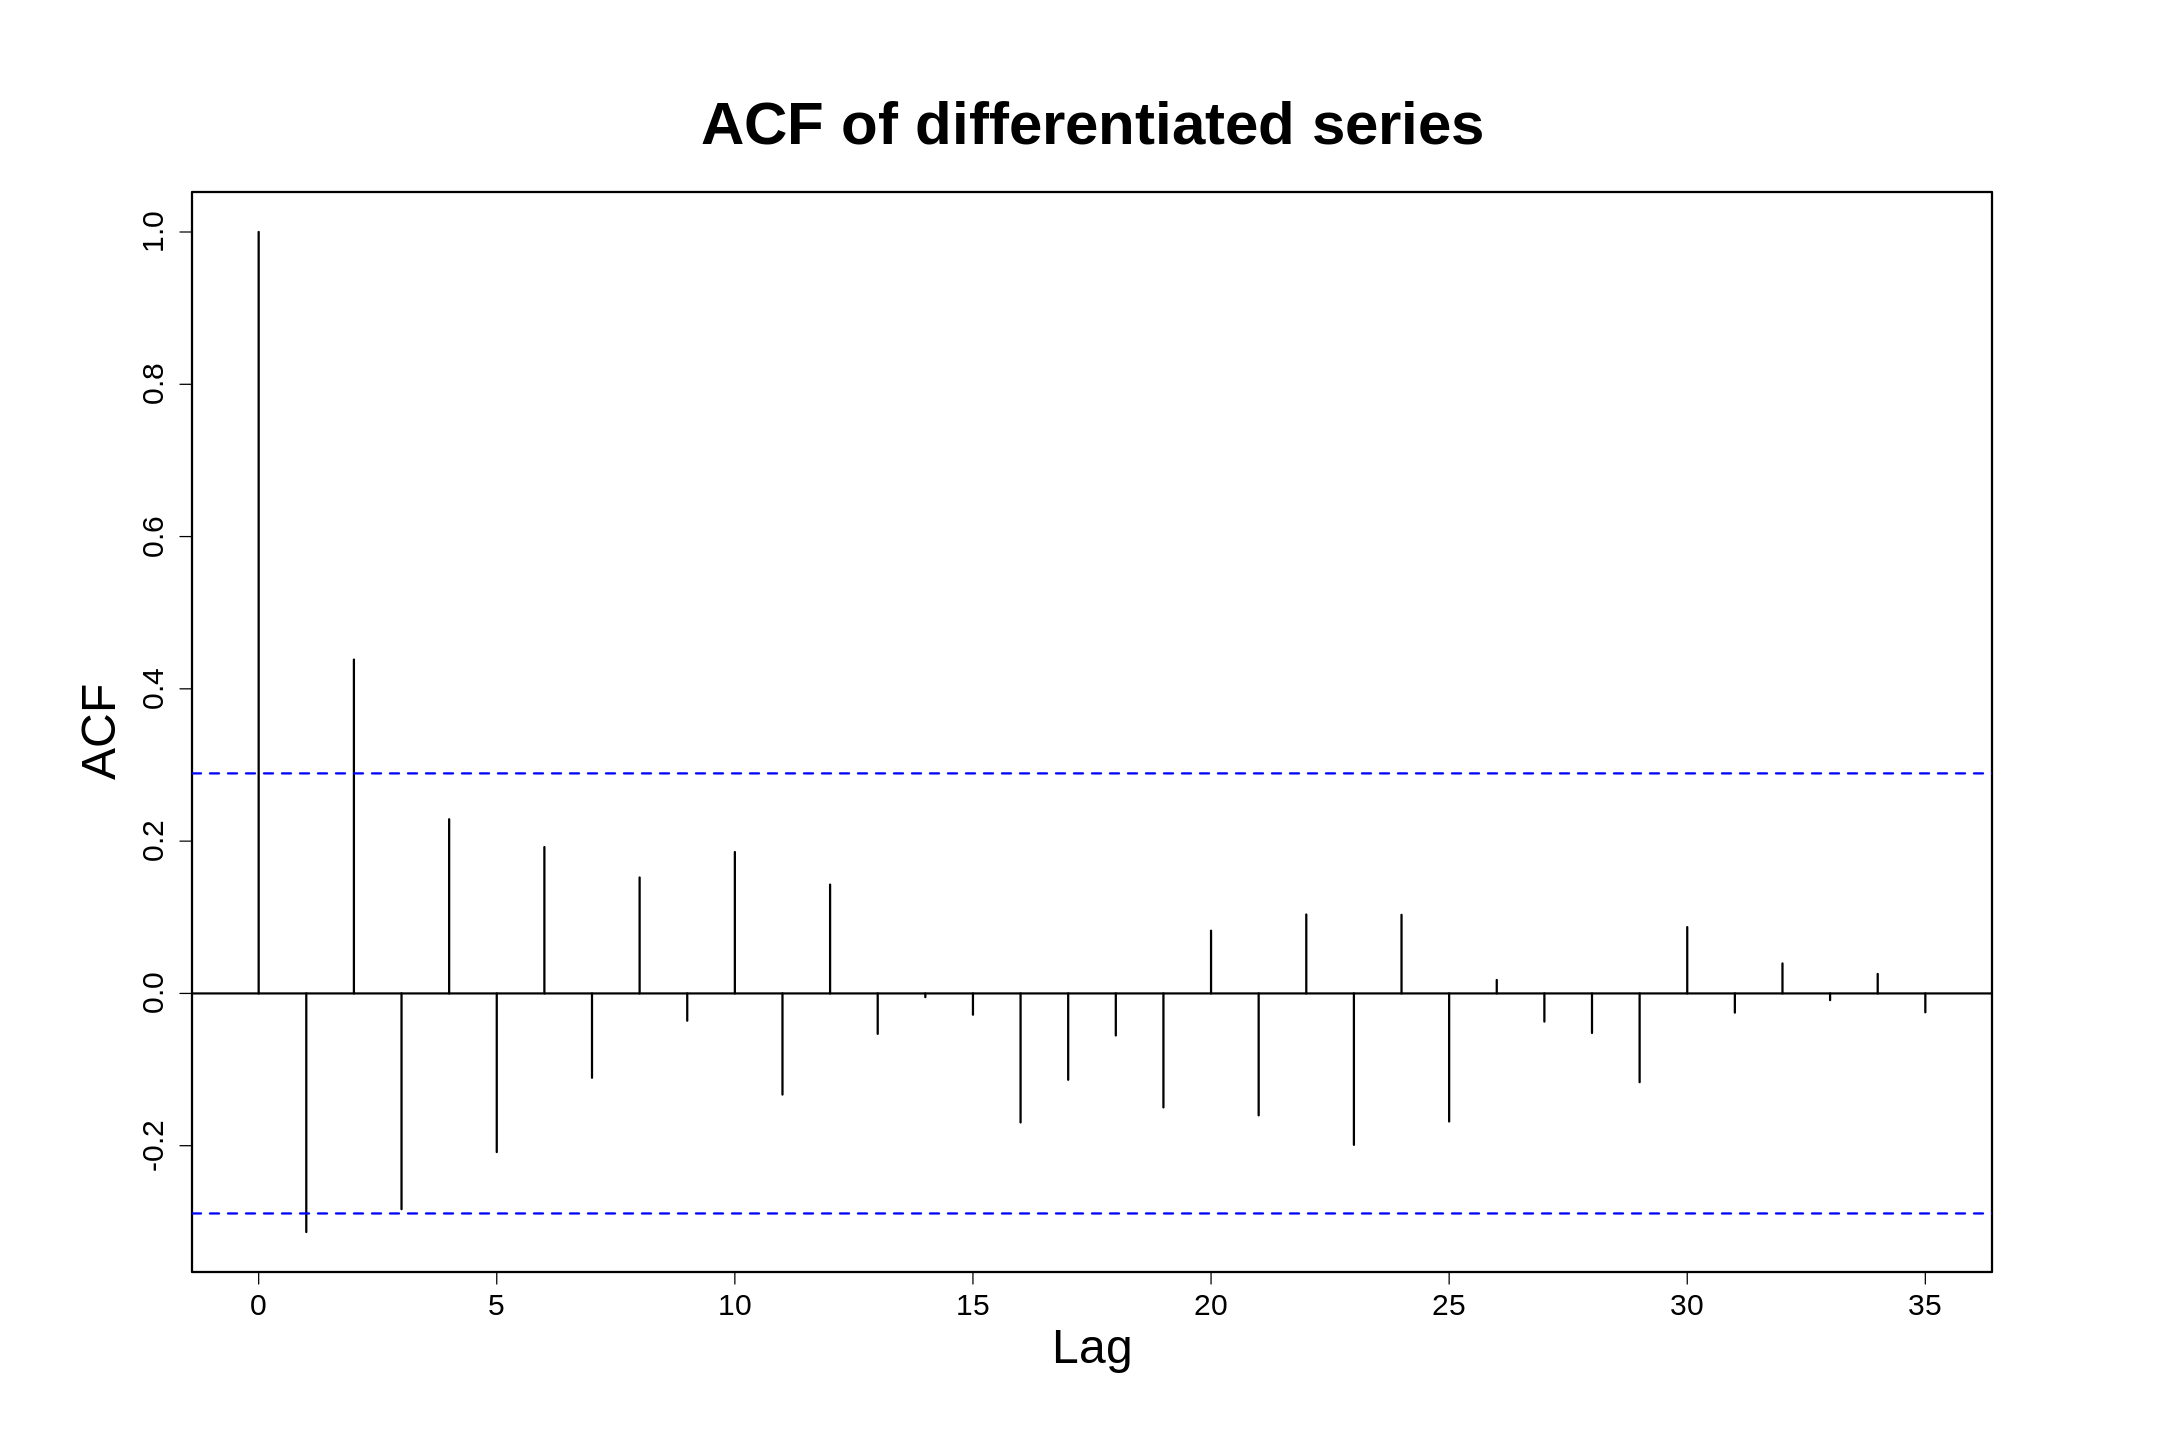

In [20]:
fplot(acf, tsbcdf, main="ACF of differentiated series", lag=35)

We observe an improvement in the data. The ACF plot approaches the pattern of stationary data; however, we cannot yet confirm stationarity. (Additionally, we perform the ADF test to validate our assumptions) and proceed with further transformations on the data.

In [21]:
adf.test(tsbcdf)


	Augmented Dickey-Fuller Test

data:  tsbcdf
Dickey-Fuller = -2.6045, Lag order = 3, p-value = 0.3336
alternative hypothesis: stationary


Test confirmed our assumptions. p.value>>0.05 There is no basis to reject H₀ (about nonstationary)

In [22]:
tsbcddf <- diff(tsbcdf)

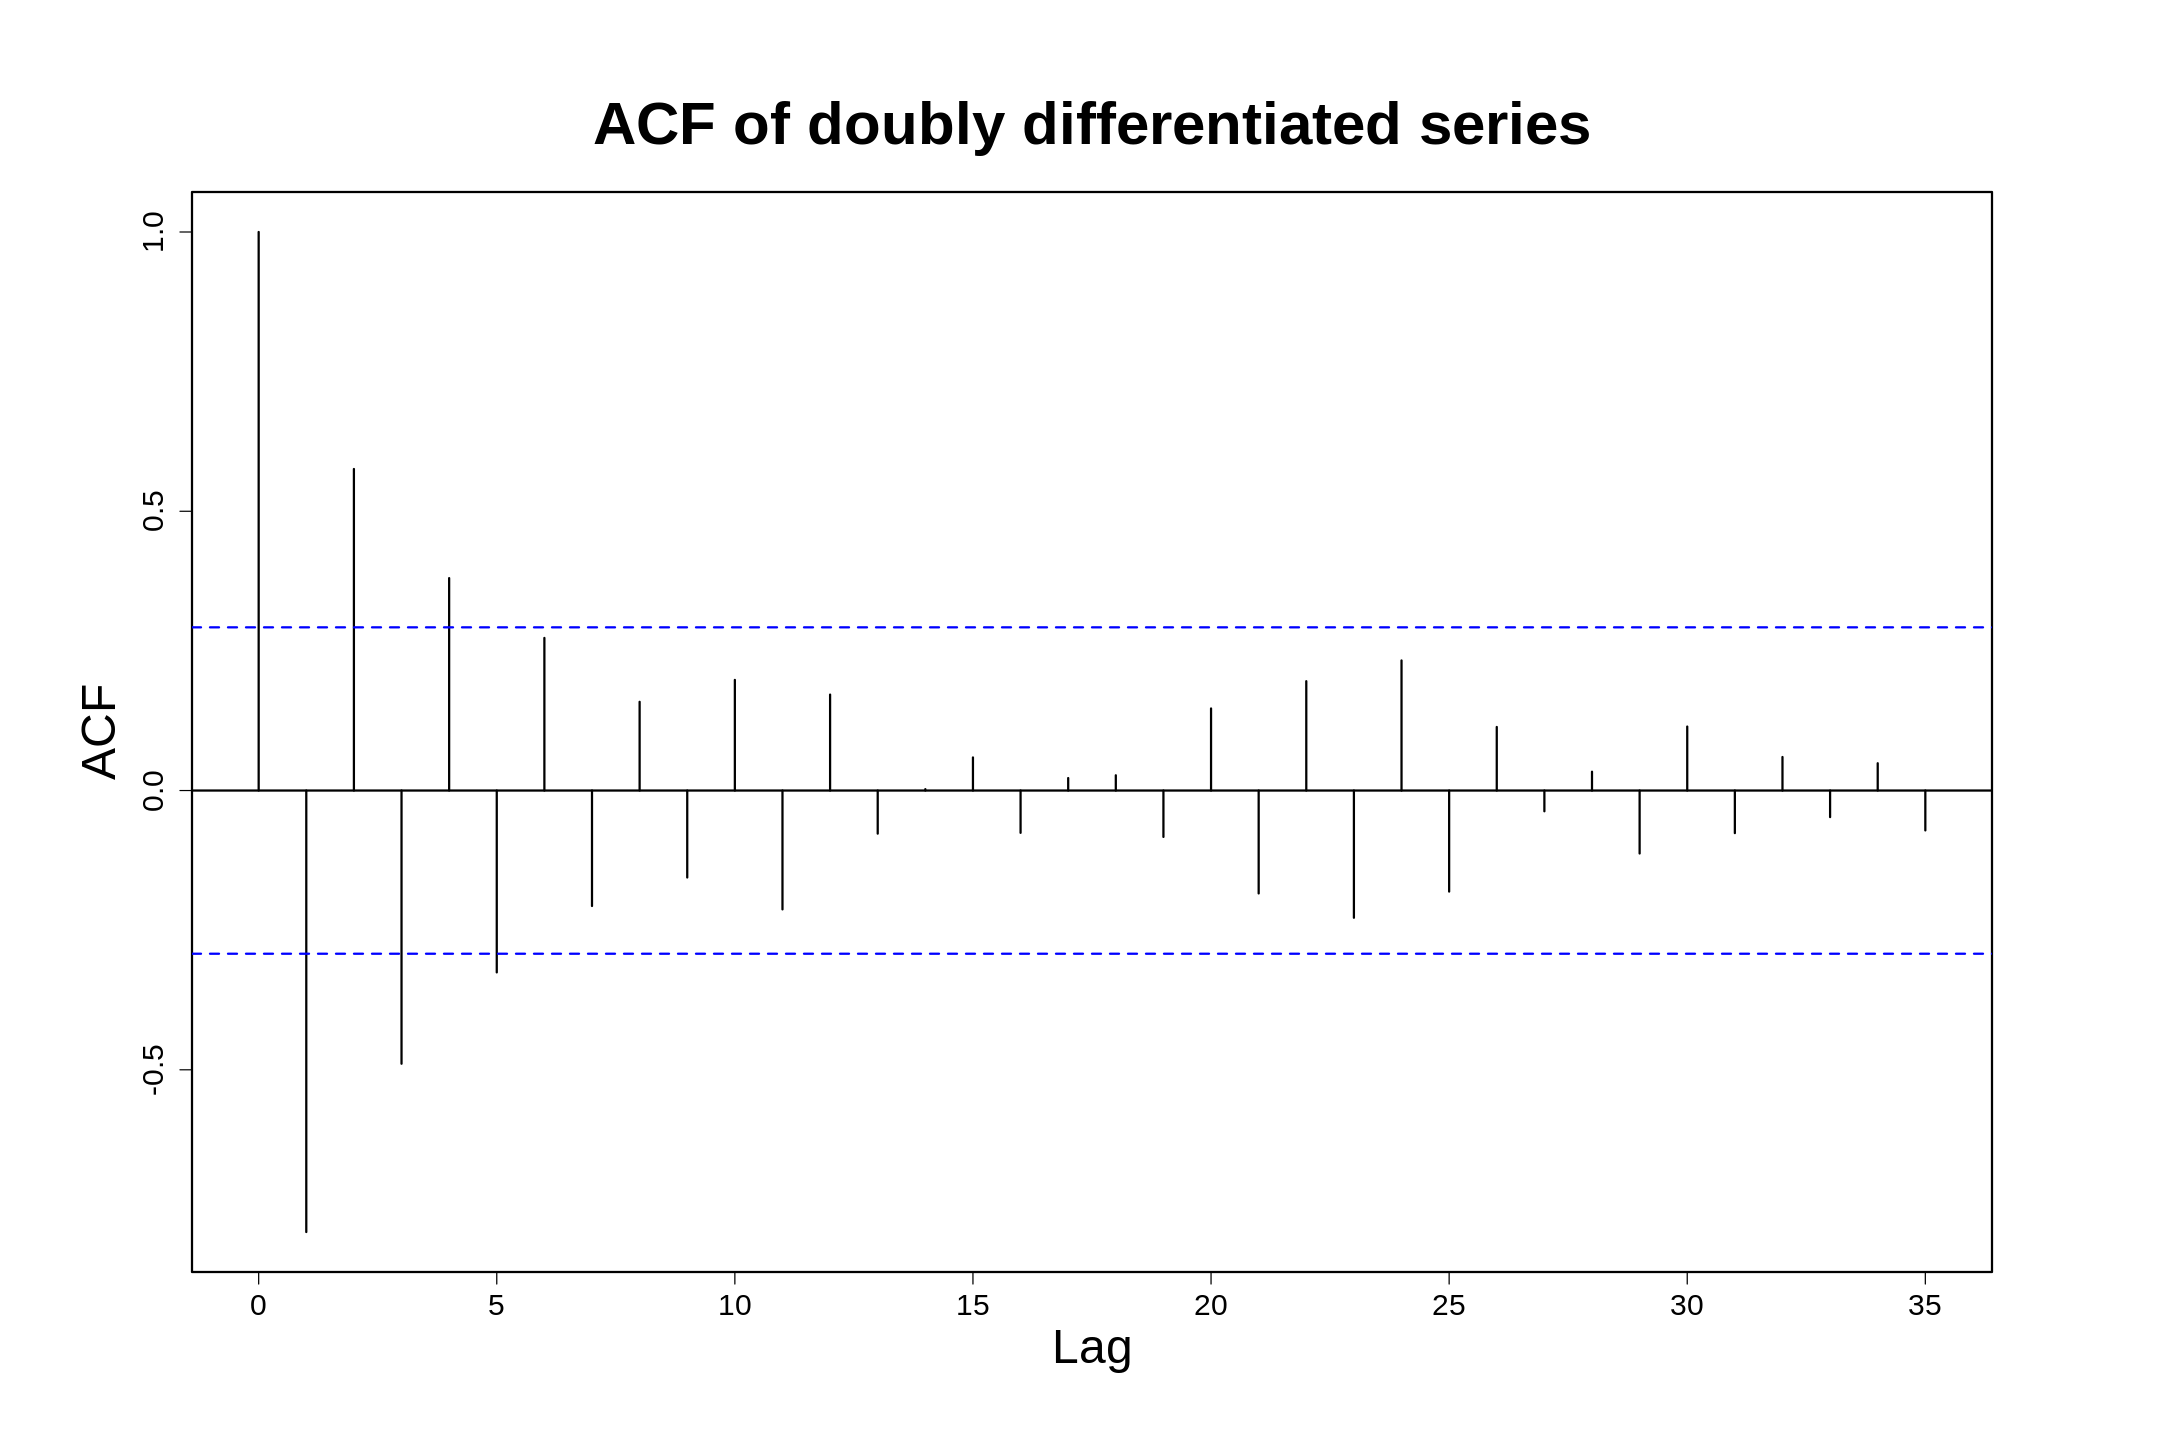

In [23]:
fplot(acf, tsbcddf, main="ACF of doubly differentiated series", lag=35)

In [24]:
adf.test(tsbcddf)

Warning message in adf.test(tsbcddf):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  tsbcddf
Dickey-Fuller = -4.9083, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


Double difference was the key 😊.

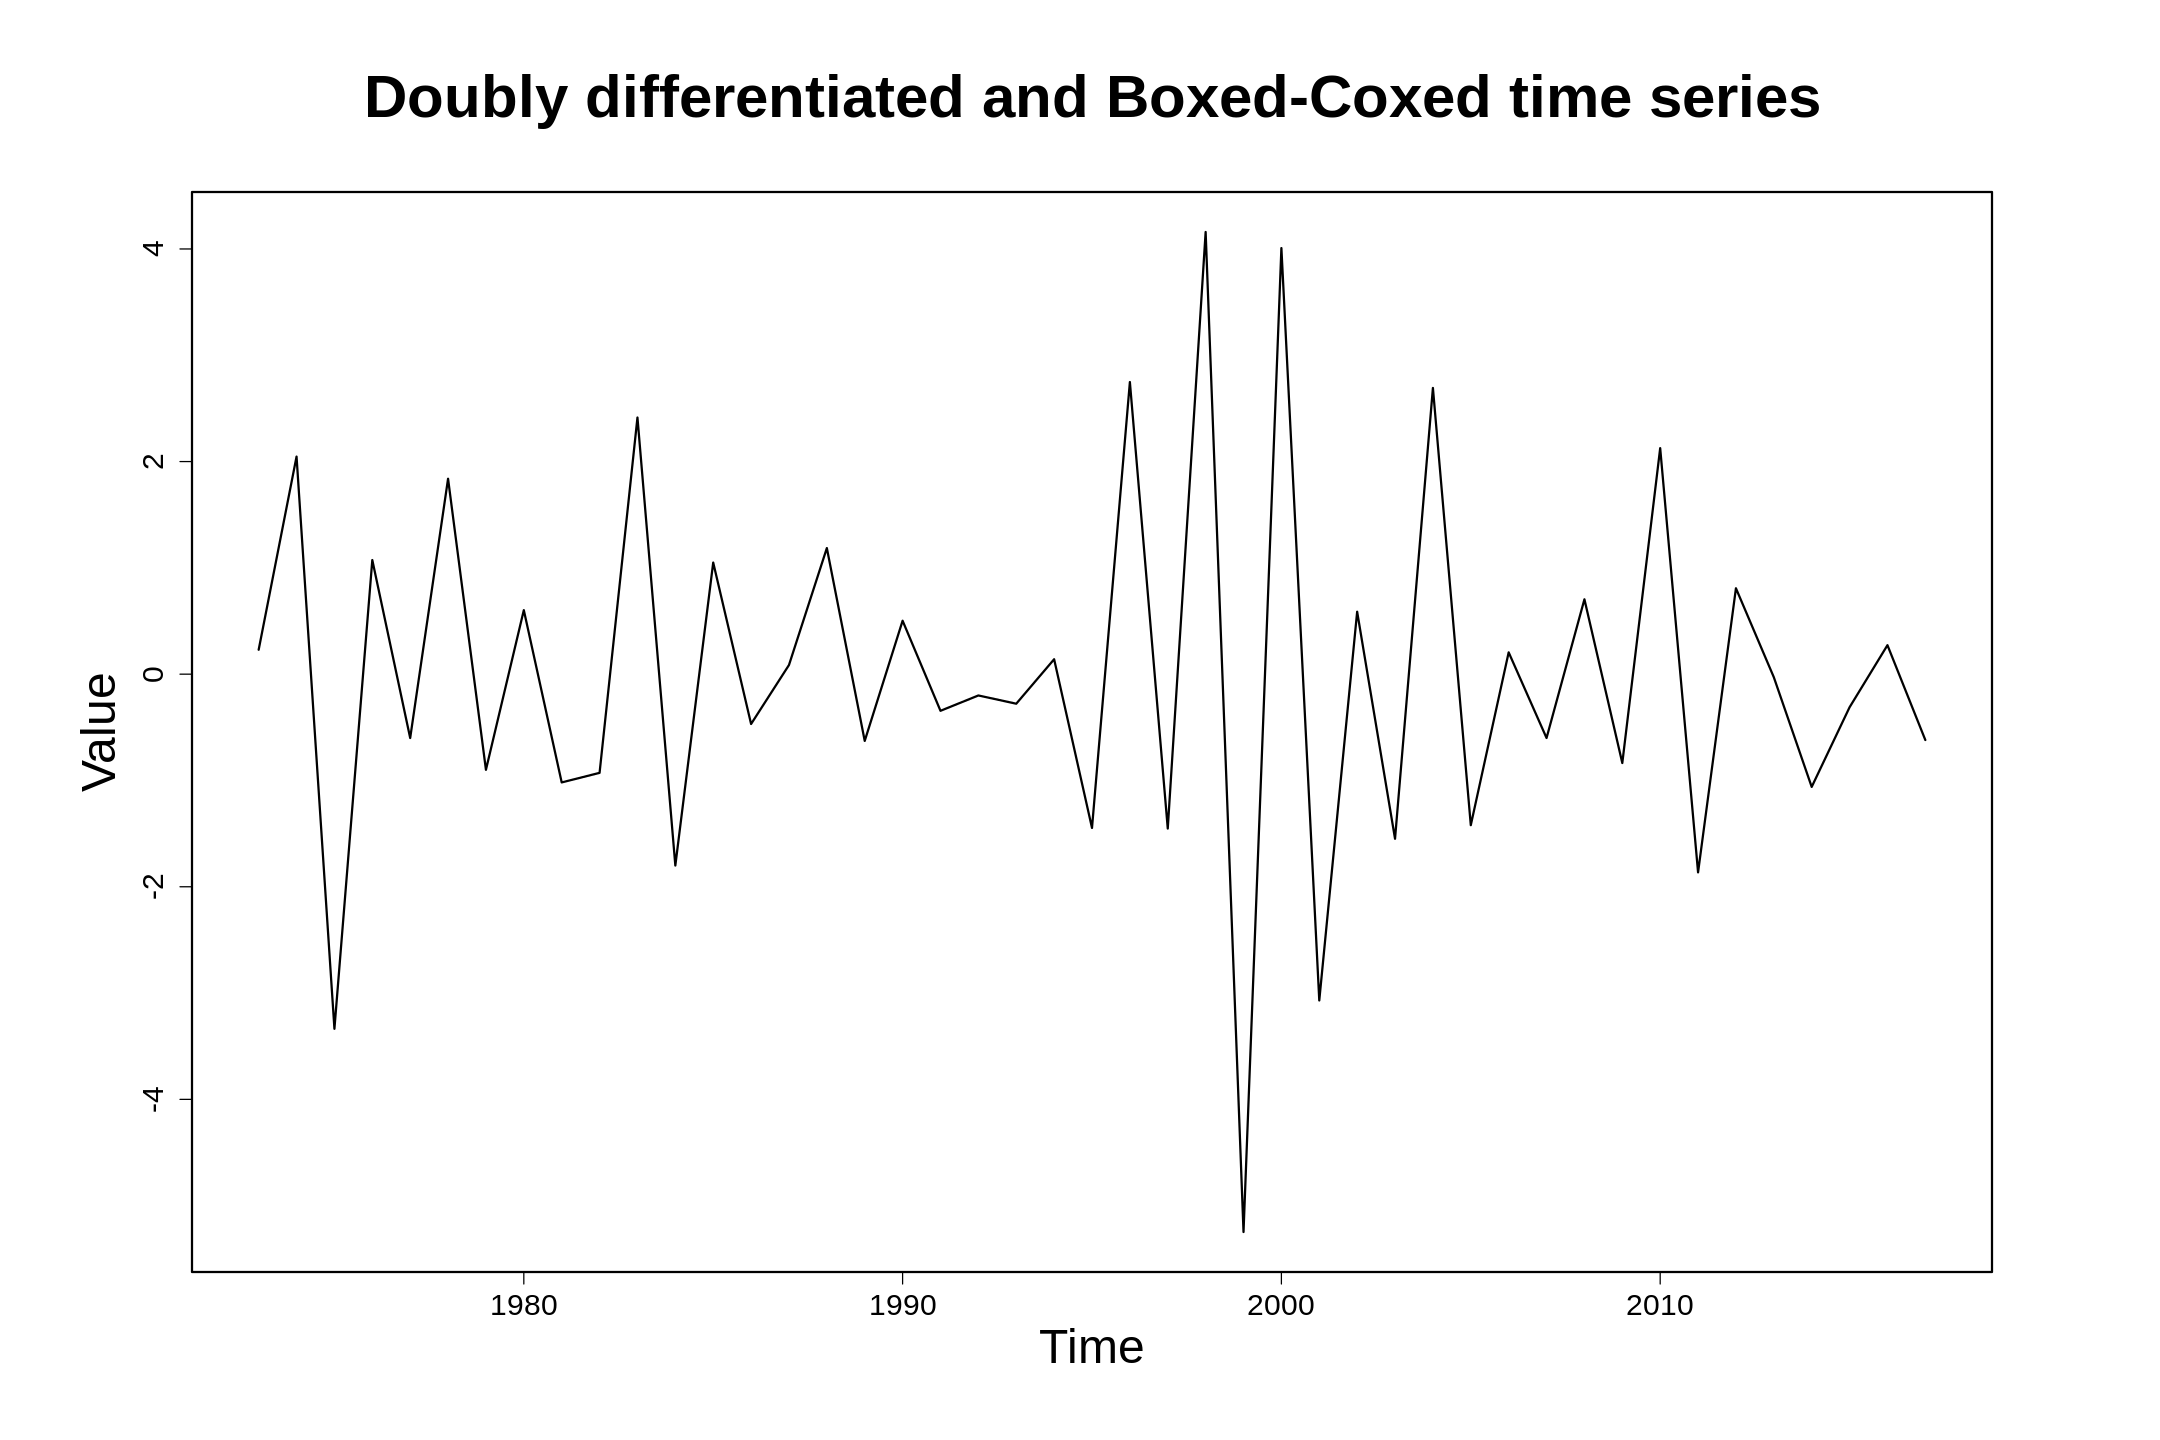

In [25]:
fplot(plot, tsbcddf, ylab="Value", main="Doubly differentiated and Boxed-Coxed time series")

## Choosing ARMA parameters 🐎

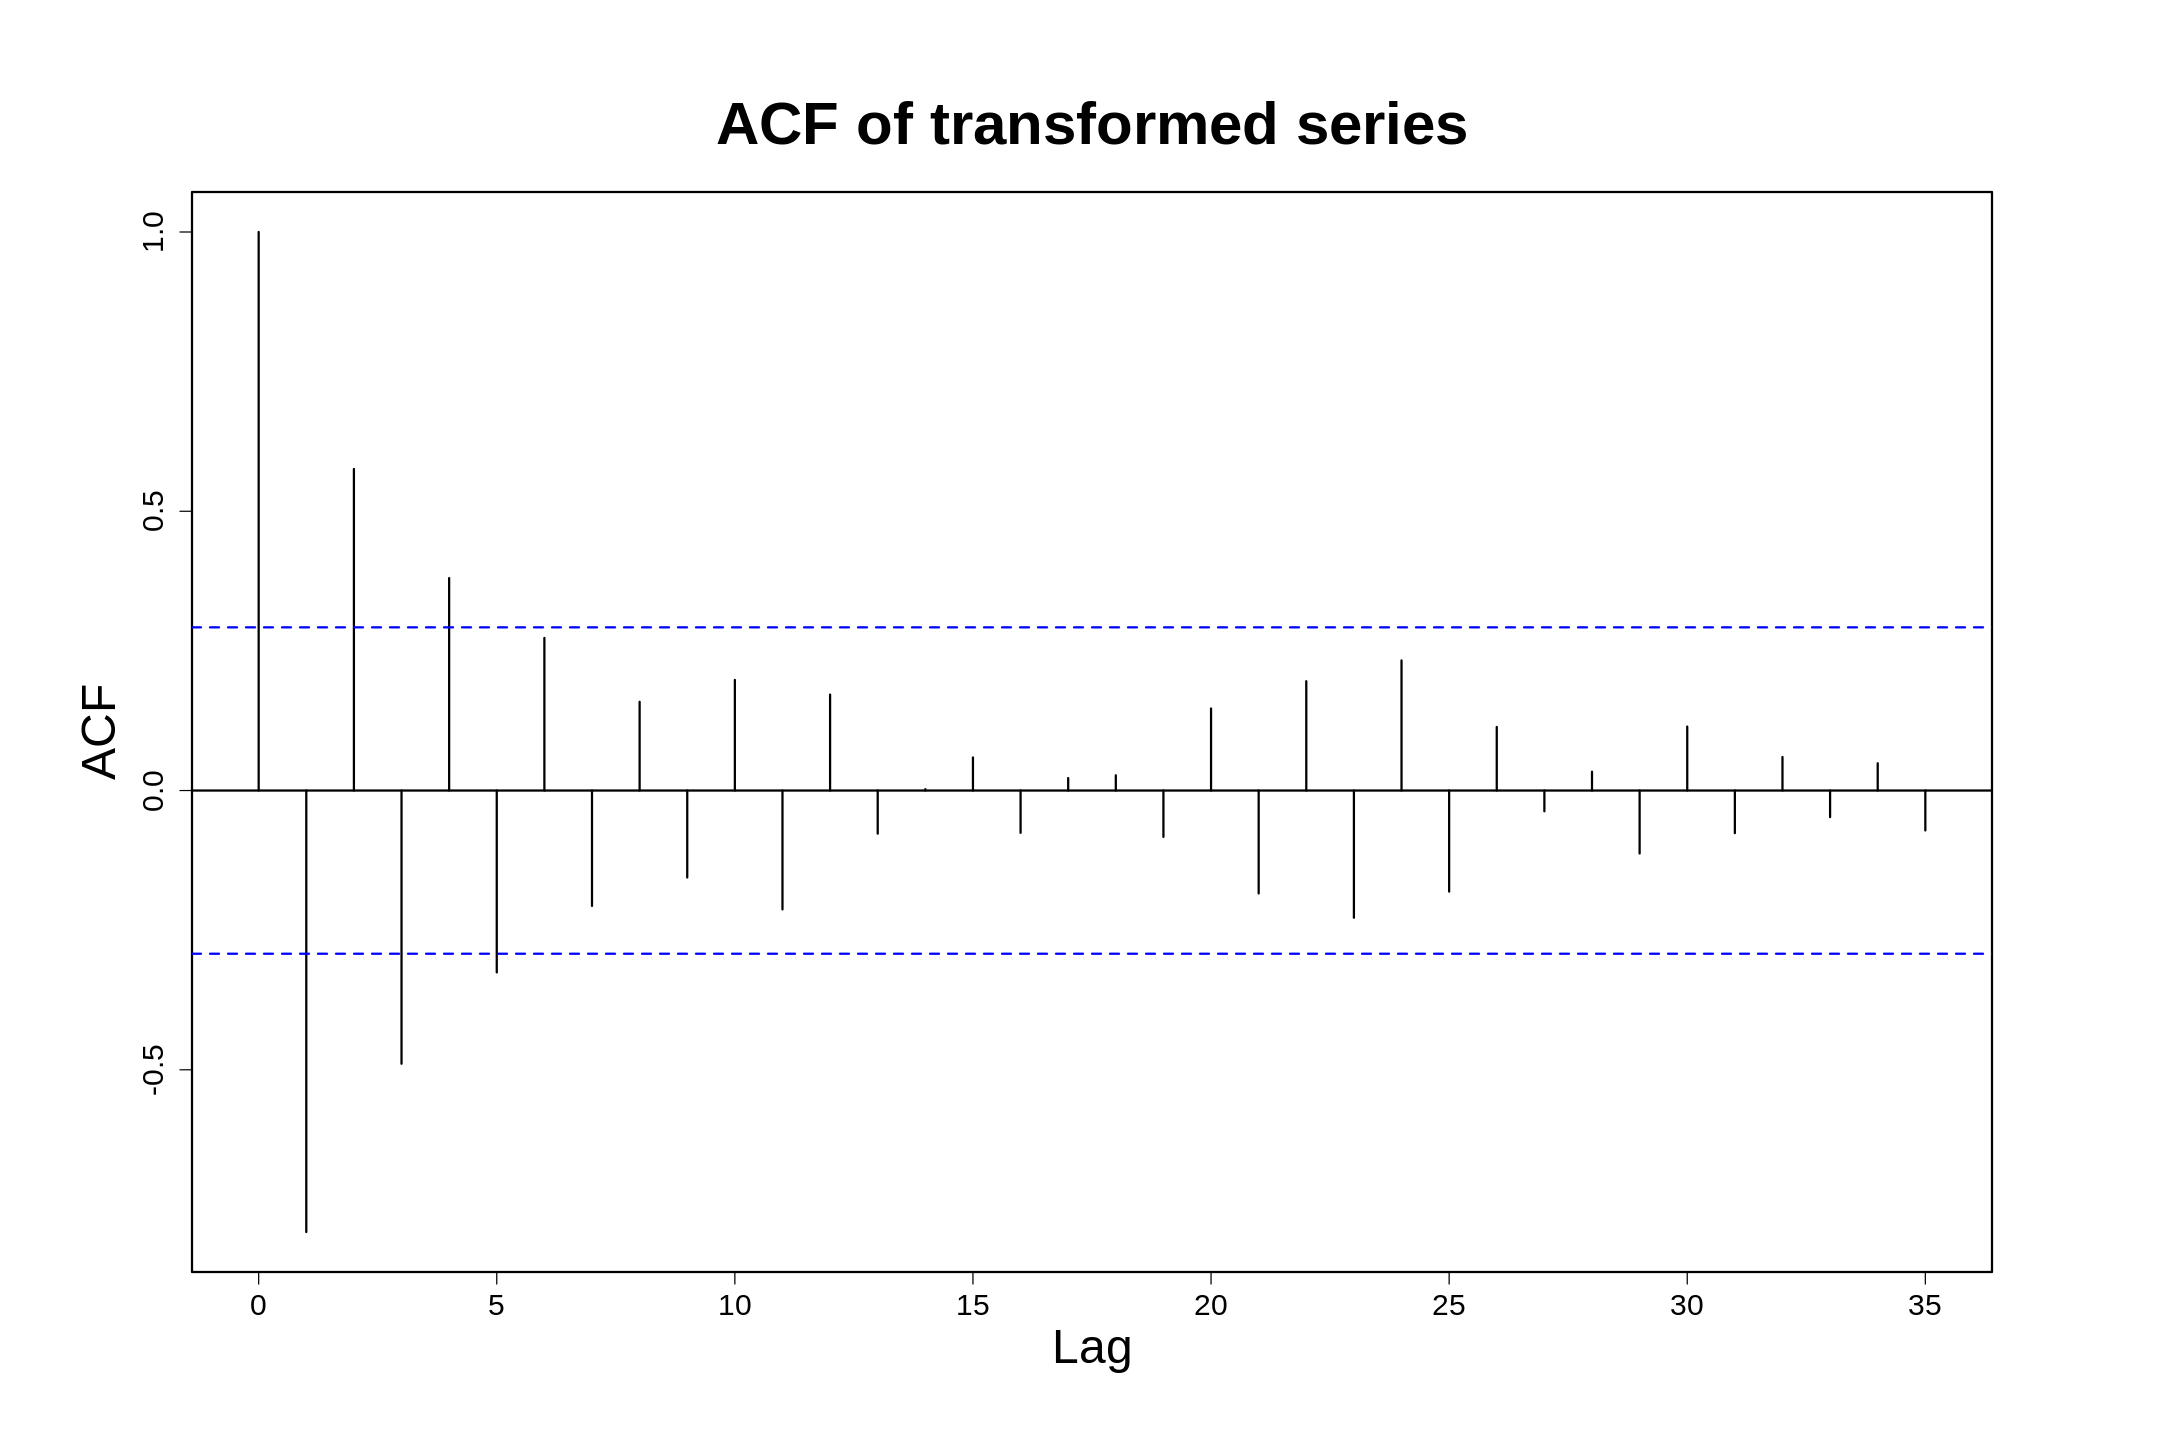

In [26]:
fplot(acf, tsbcddf, main="ACF of transformed series", lag=35)

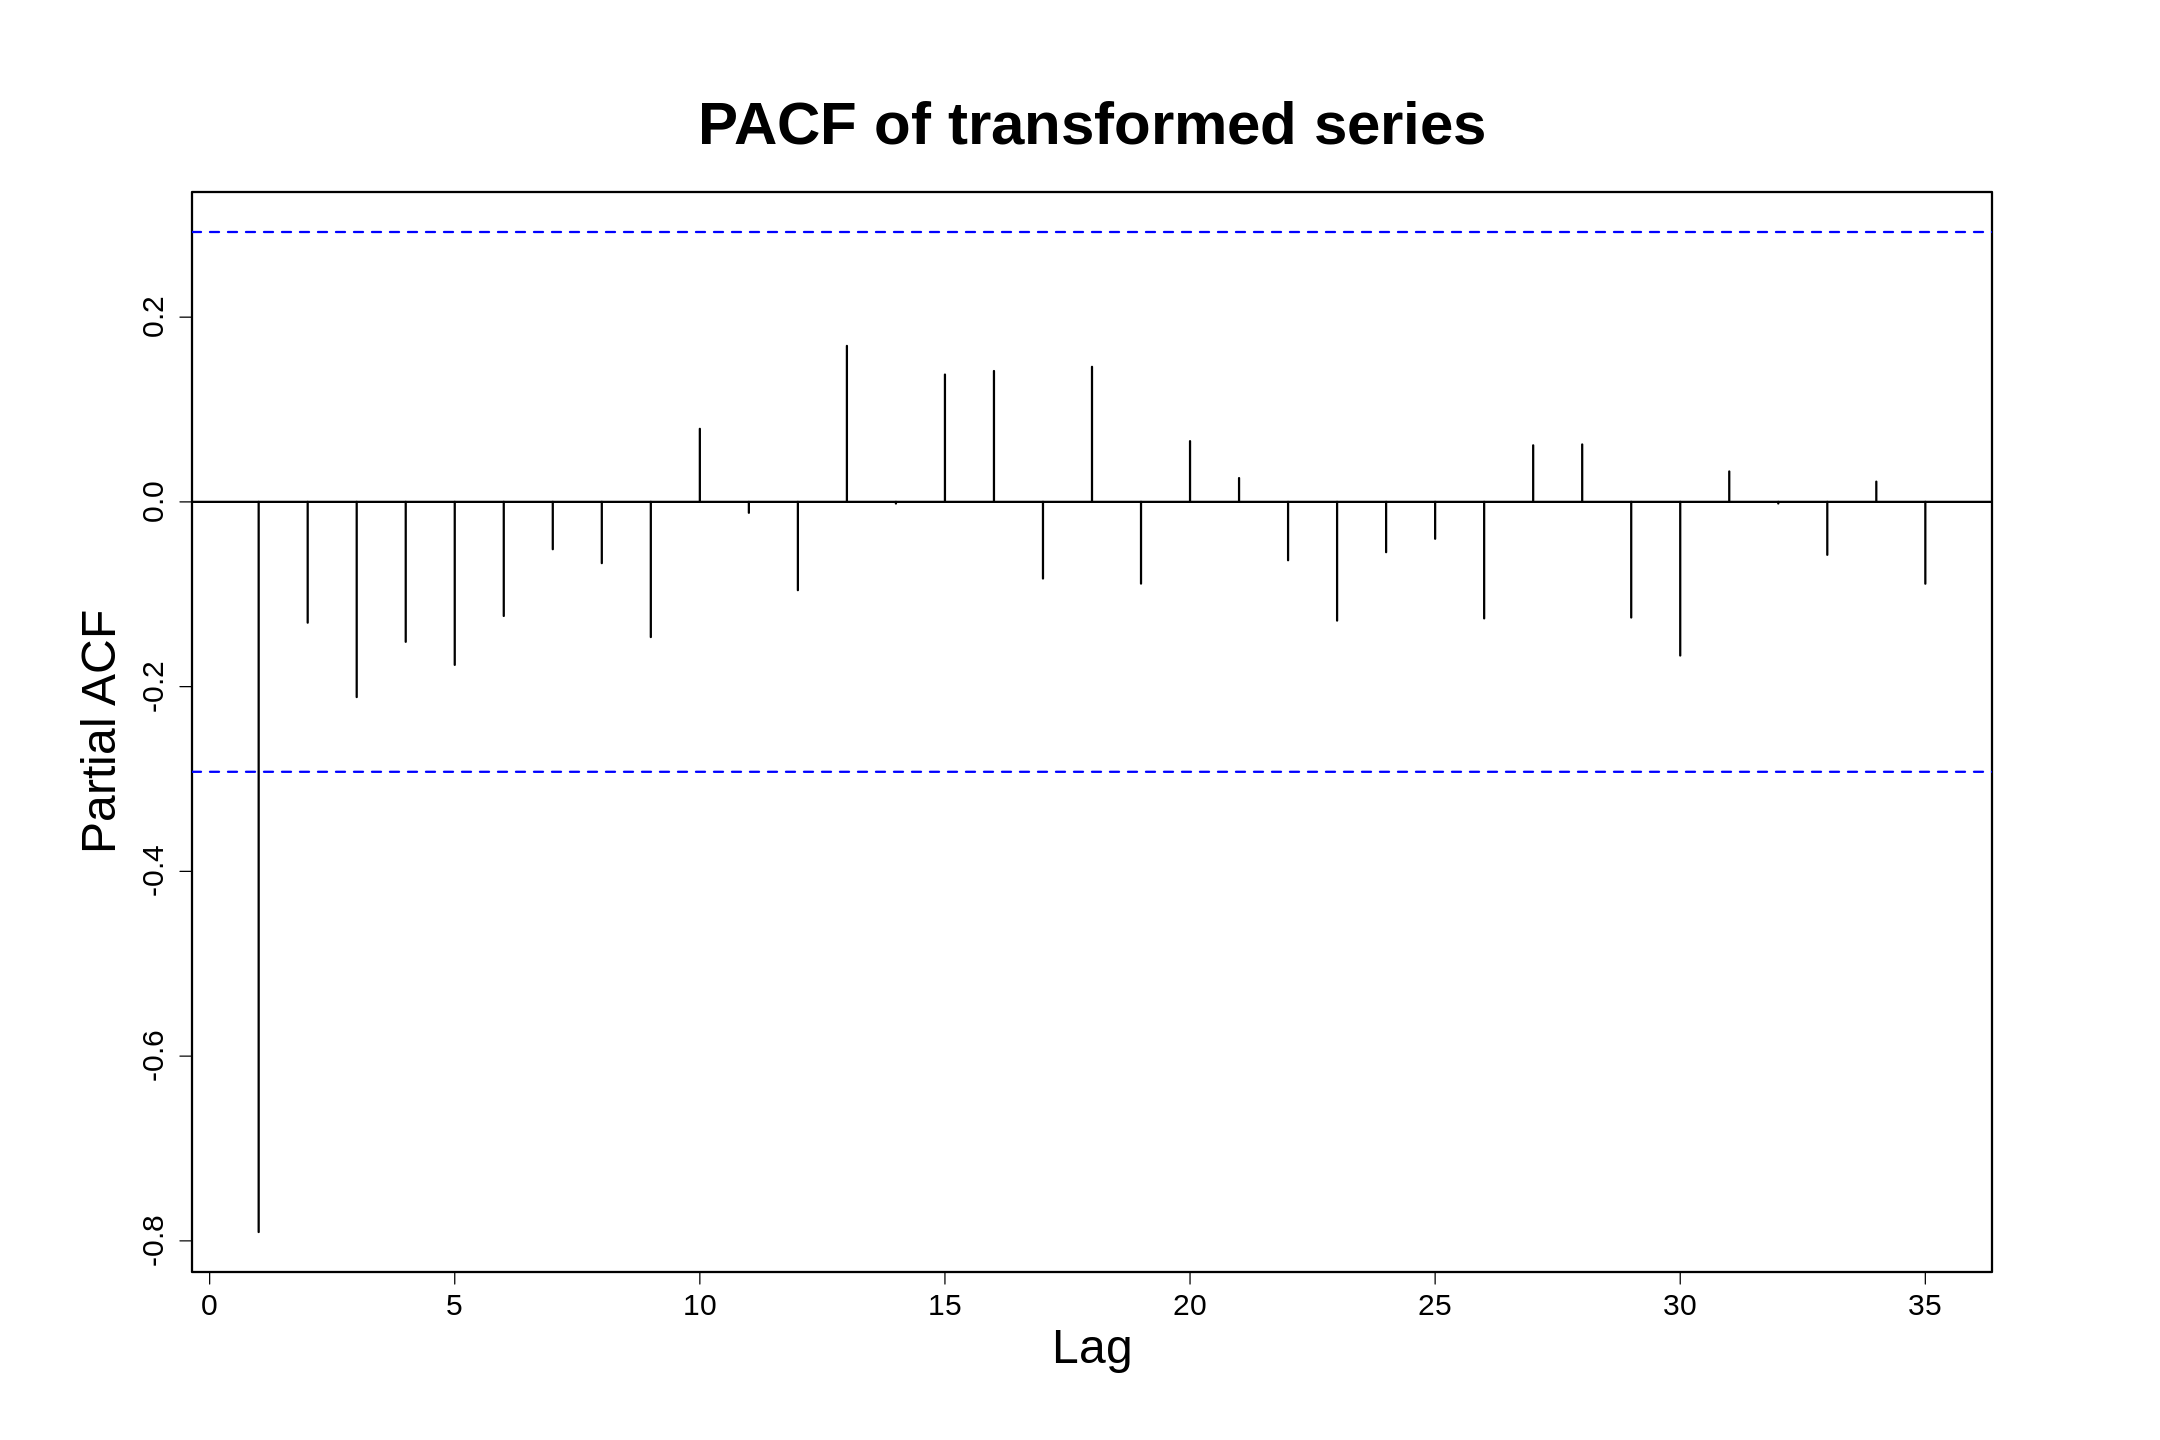

In [27]:
fplot(pacf, tsbcddf, main="PACF of transformed series", lag=35)

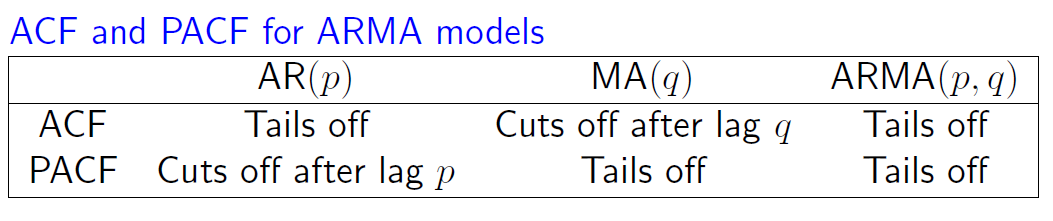

By examining the above plots we can clearly see that ACF tails off slowly to 0 and PACF disruptively cuts off to 0 after the first value. According to the infallible table that was gifted to us by none other than our beloved teacher, we conclude that appropriate model should be <b>AR(1)</b>.

### Helper functions 🦦

In [28]:
inverse_diff_transform_generator <- function (ndiffs=2, inits=list()) {
    return (function (x) {
        for (init in inits) {
            x <- c(init, x)
            x <- cumsum(x)
            ndiffs <- ndiffs - 1
        }
        if (ndiffs > 0) {
            for (i in 0:ndiffs) {
                print(";(")
                x <- cumsum(x)
            }
        }
       return (x)
    })
}

In [29]:
inverse_diff_transform <- inverse_diff_transform_generator(ndiffs=2, inits=list(tsbcddf[1], tsbcdf[1]))
inverse_transform <- function (x) InvBoxCox(inverse_diff_transform(x), lambda = lambda);

In [30]:
plot_sims <- function (seeds, model, original, ...) {
    n <- length(tsbcddf)

    fplot(plot, original, ...)

    for (seed in seeds) {
        set.seed(seed)
        sim <- inverse_transform(simulate(model, nsim = n))
        sim <- sim + original[1]
        fplot(lines, ts(sim, start=start(original), end=end(original)))
    }

    fplot(lines, original, lwd=4., ...)
}

In [31]:
seeds <- c(2137, 1102, 2103, 1234, 4322, 123, 13214, 23423, 2323)

### Estimation and evaluation 🐿️

In [32]:
model <- arima(tsbcddf, order = c(1, 0, 0))

In [33]:
summary(model)


Call:
arima(x = tsbcddf, order = c(1, 0, 0))

Coefficients:
          ar1  intercept
      -0.7765    -0.0081
s.e.   0.0878     0.0920

sigma^2 estimated as 1.179:  log likelihood = -68.03,  aic = 142.06

Training set error measures:
                      ME     RMSE       MAE       MPE     MAPE      MASE
Training set 0.002149499 1.086034 0.8163752 -35.03636 134.9667 0.3146556
                   ACF1
Training set -0.1234483

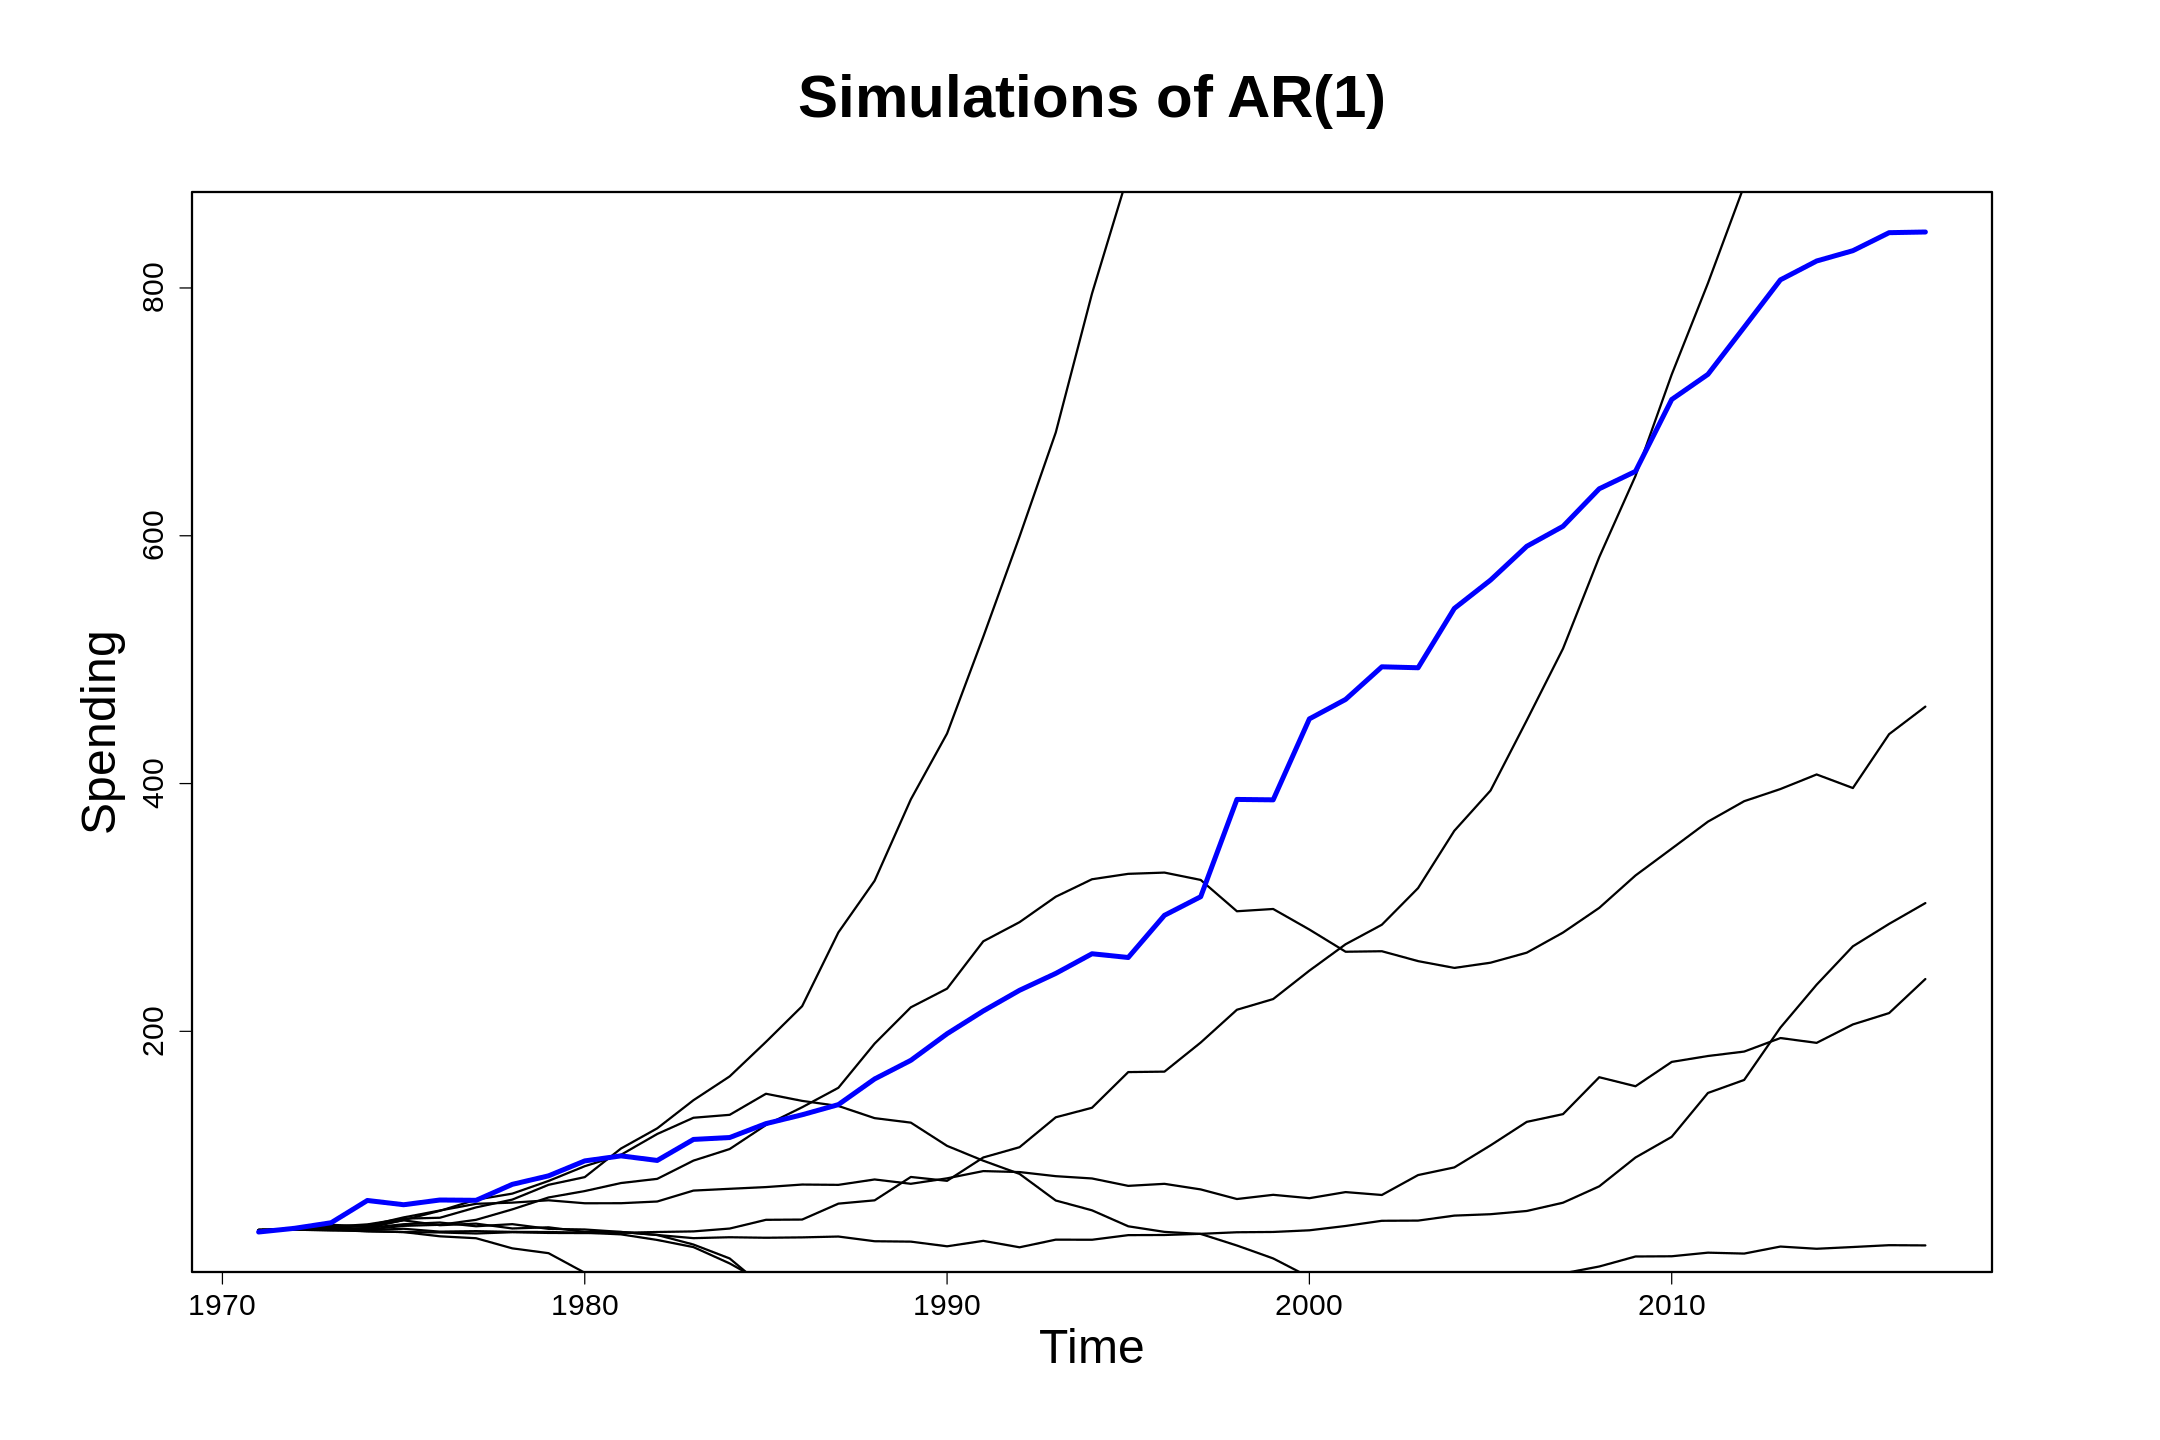

In [34]:
plot_sims(seeds, model, tsr, ylab="Spending", main="Simulations of AR(1)", col="blue")

In [35]:
residuals <- residuals(model)

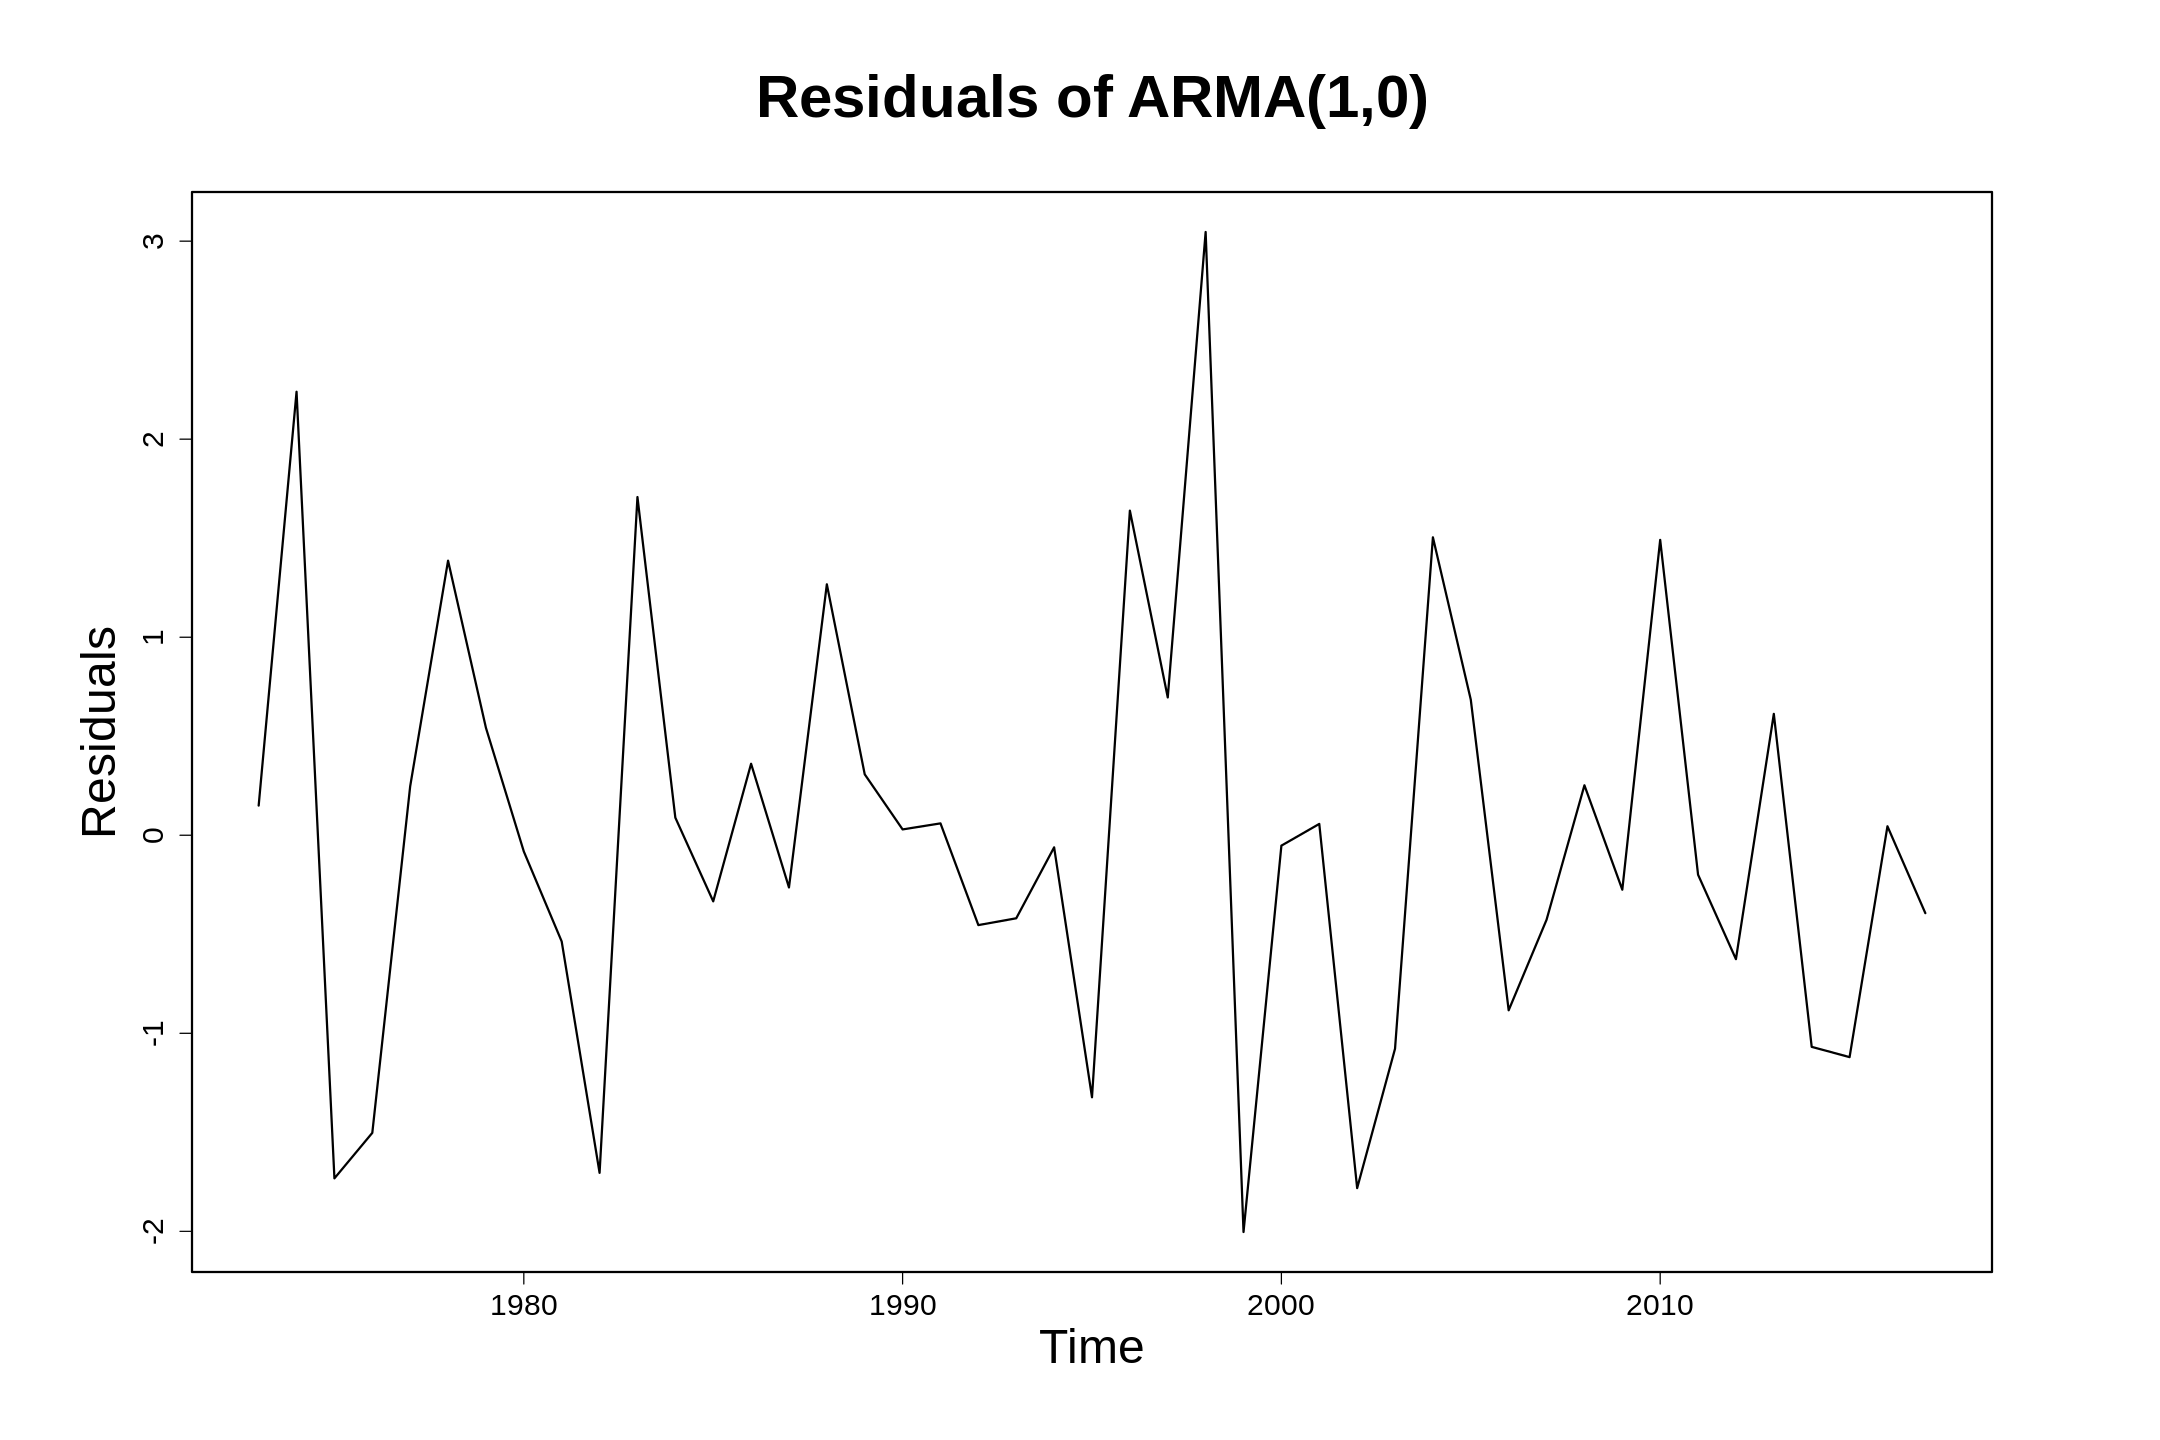

In [36]:
fplot(plot, residuals, main="Residuals of ARMA(1,0)", ylab="Residuals", xlab="Time", type="l")

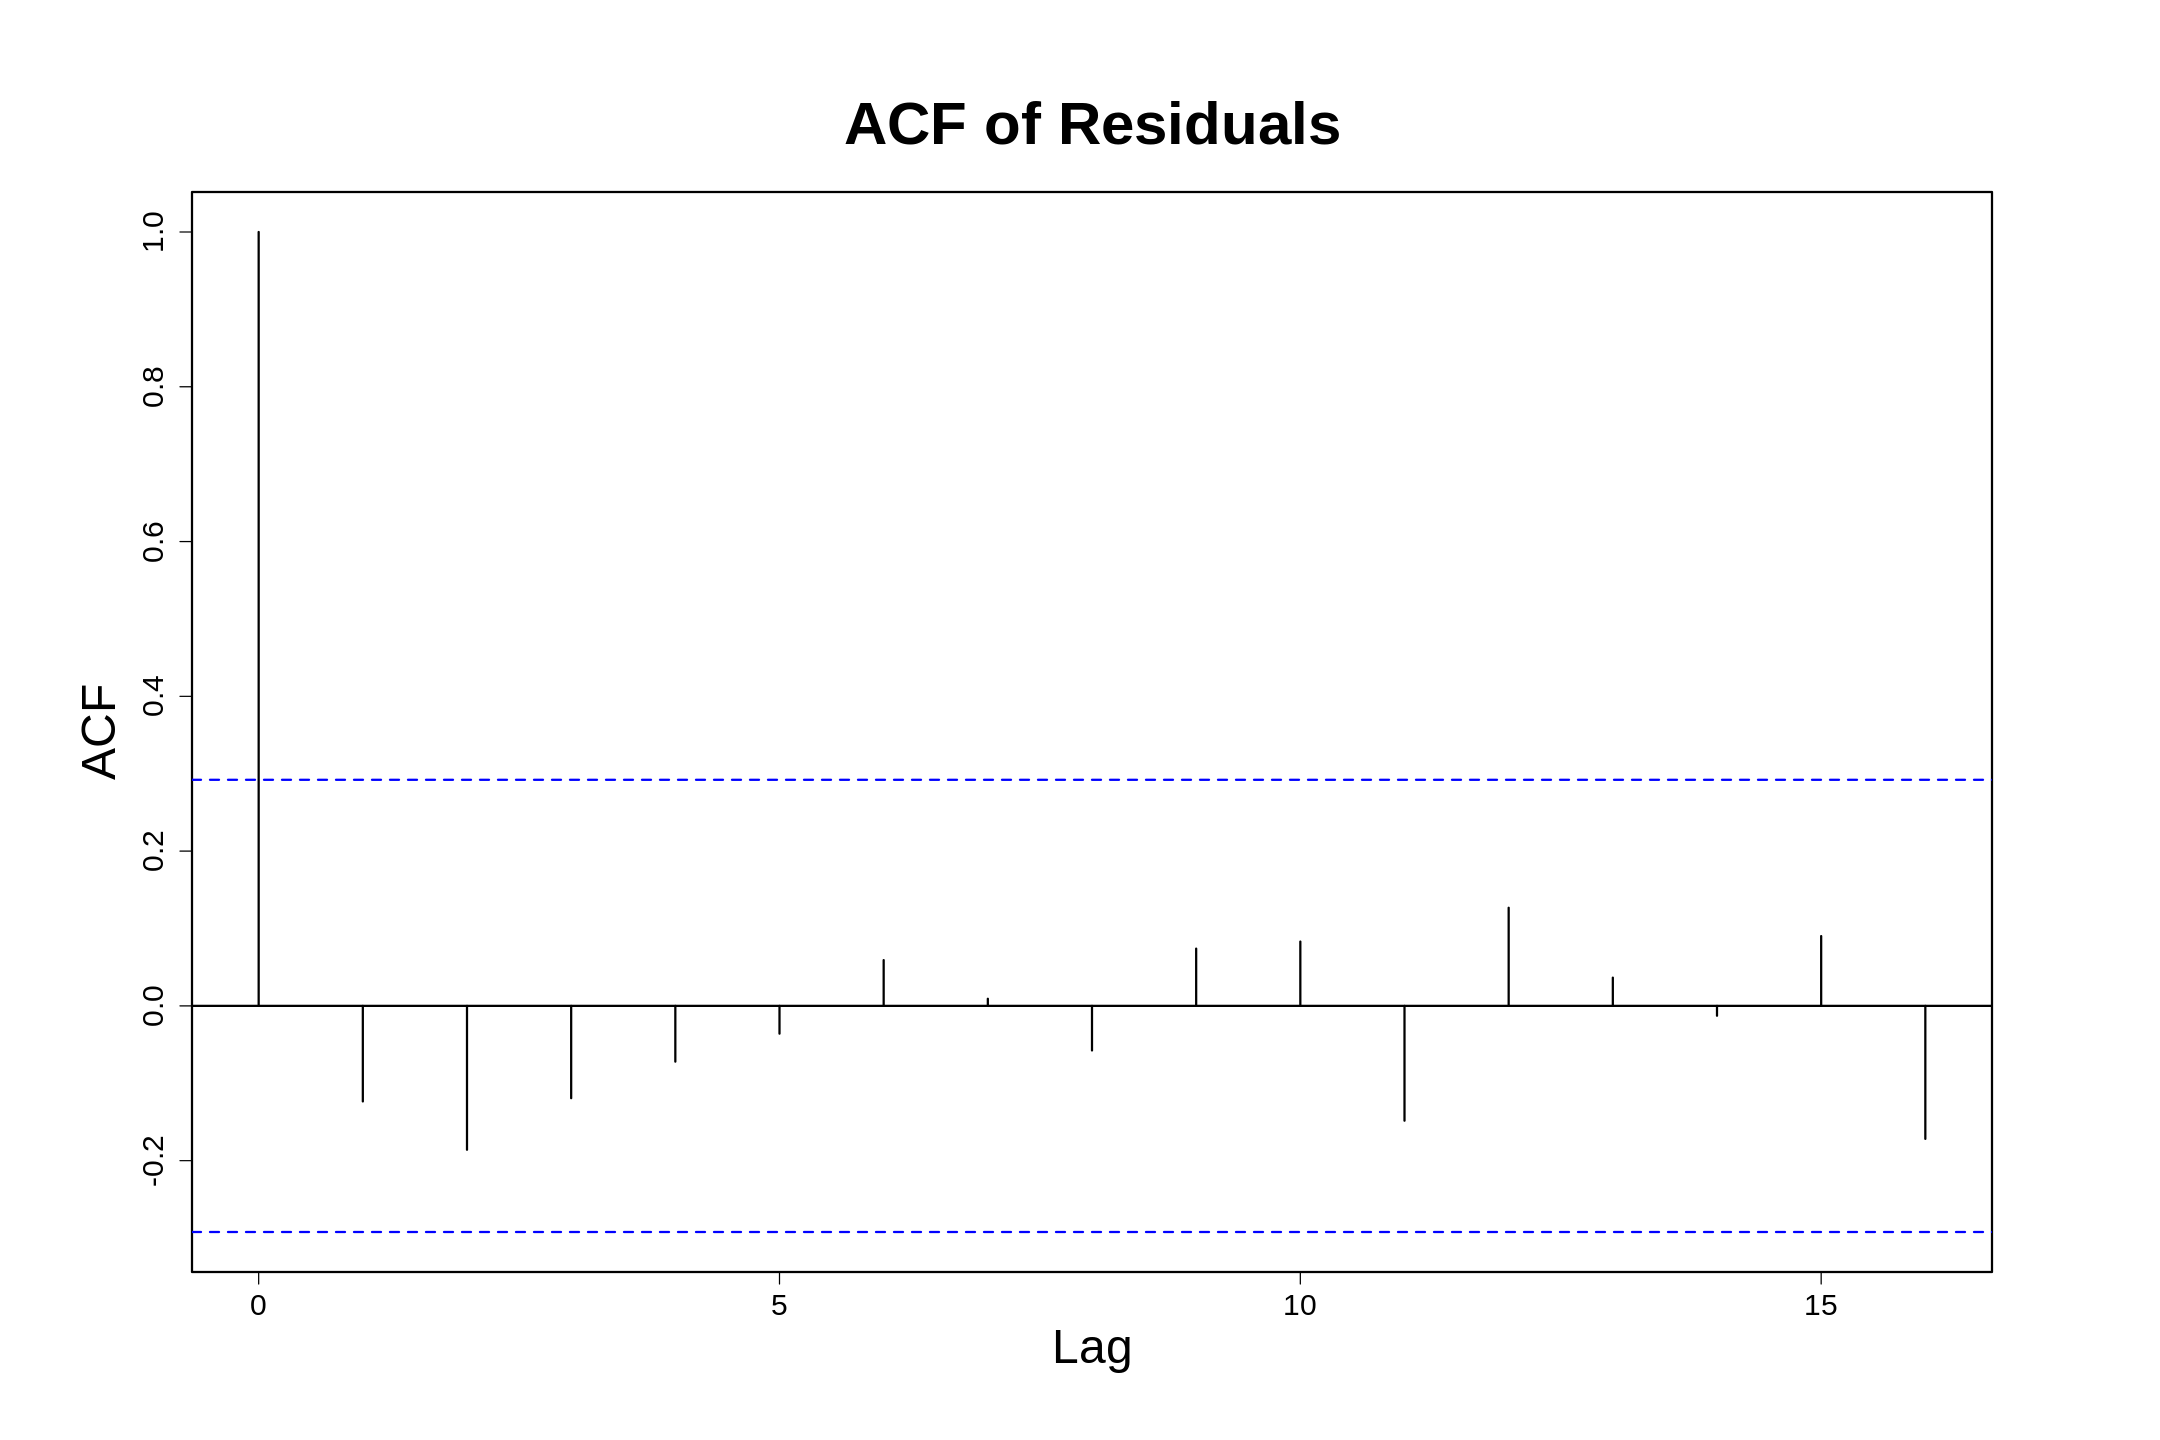

In [37]:
fplot(acf, residuals, main="ACF of Residuals")

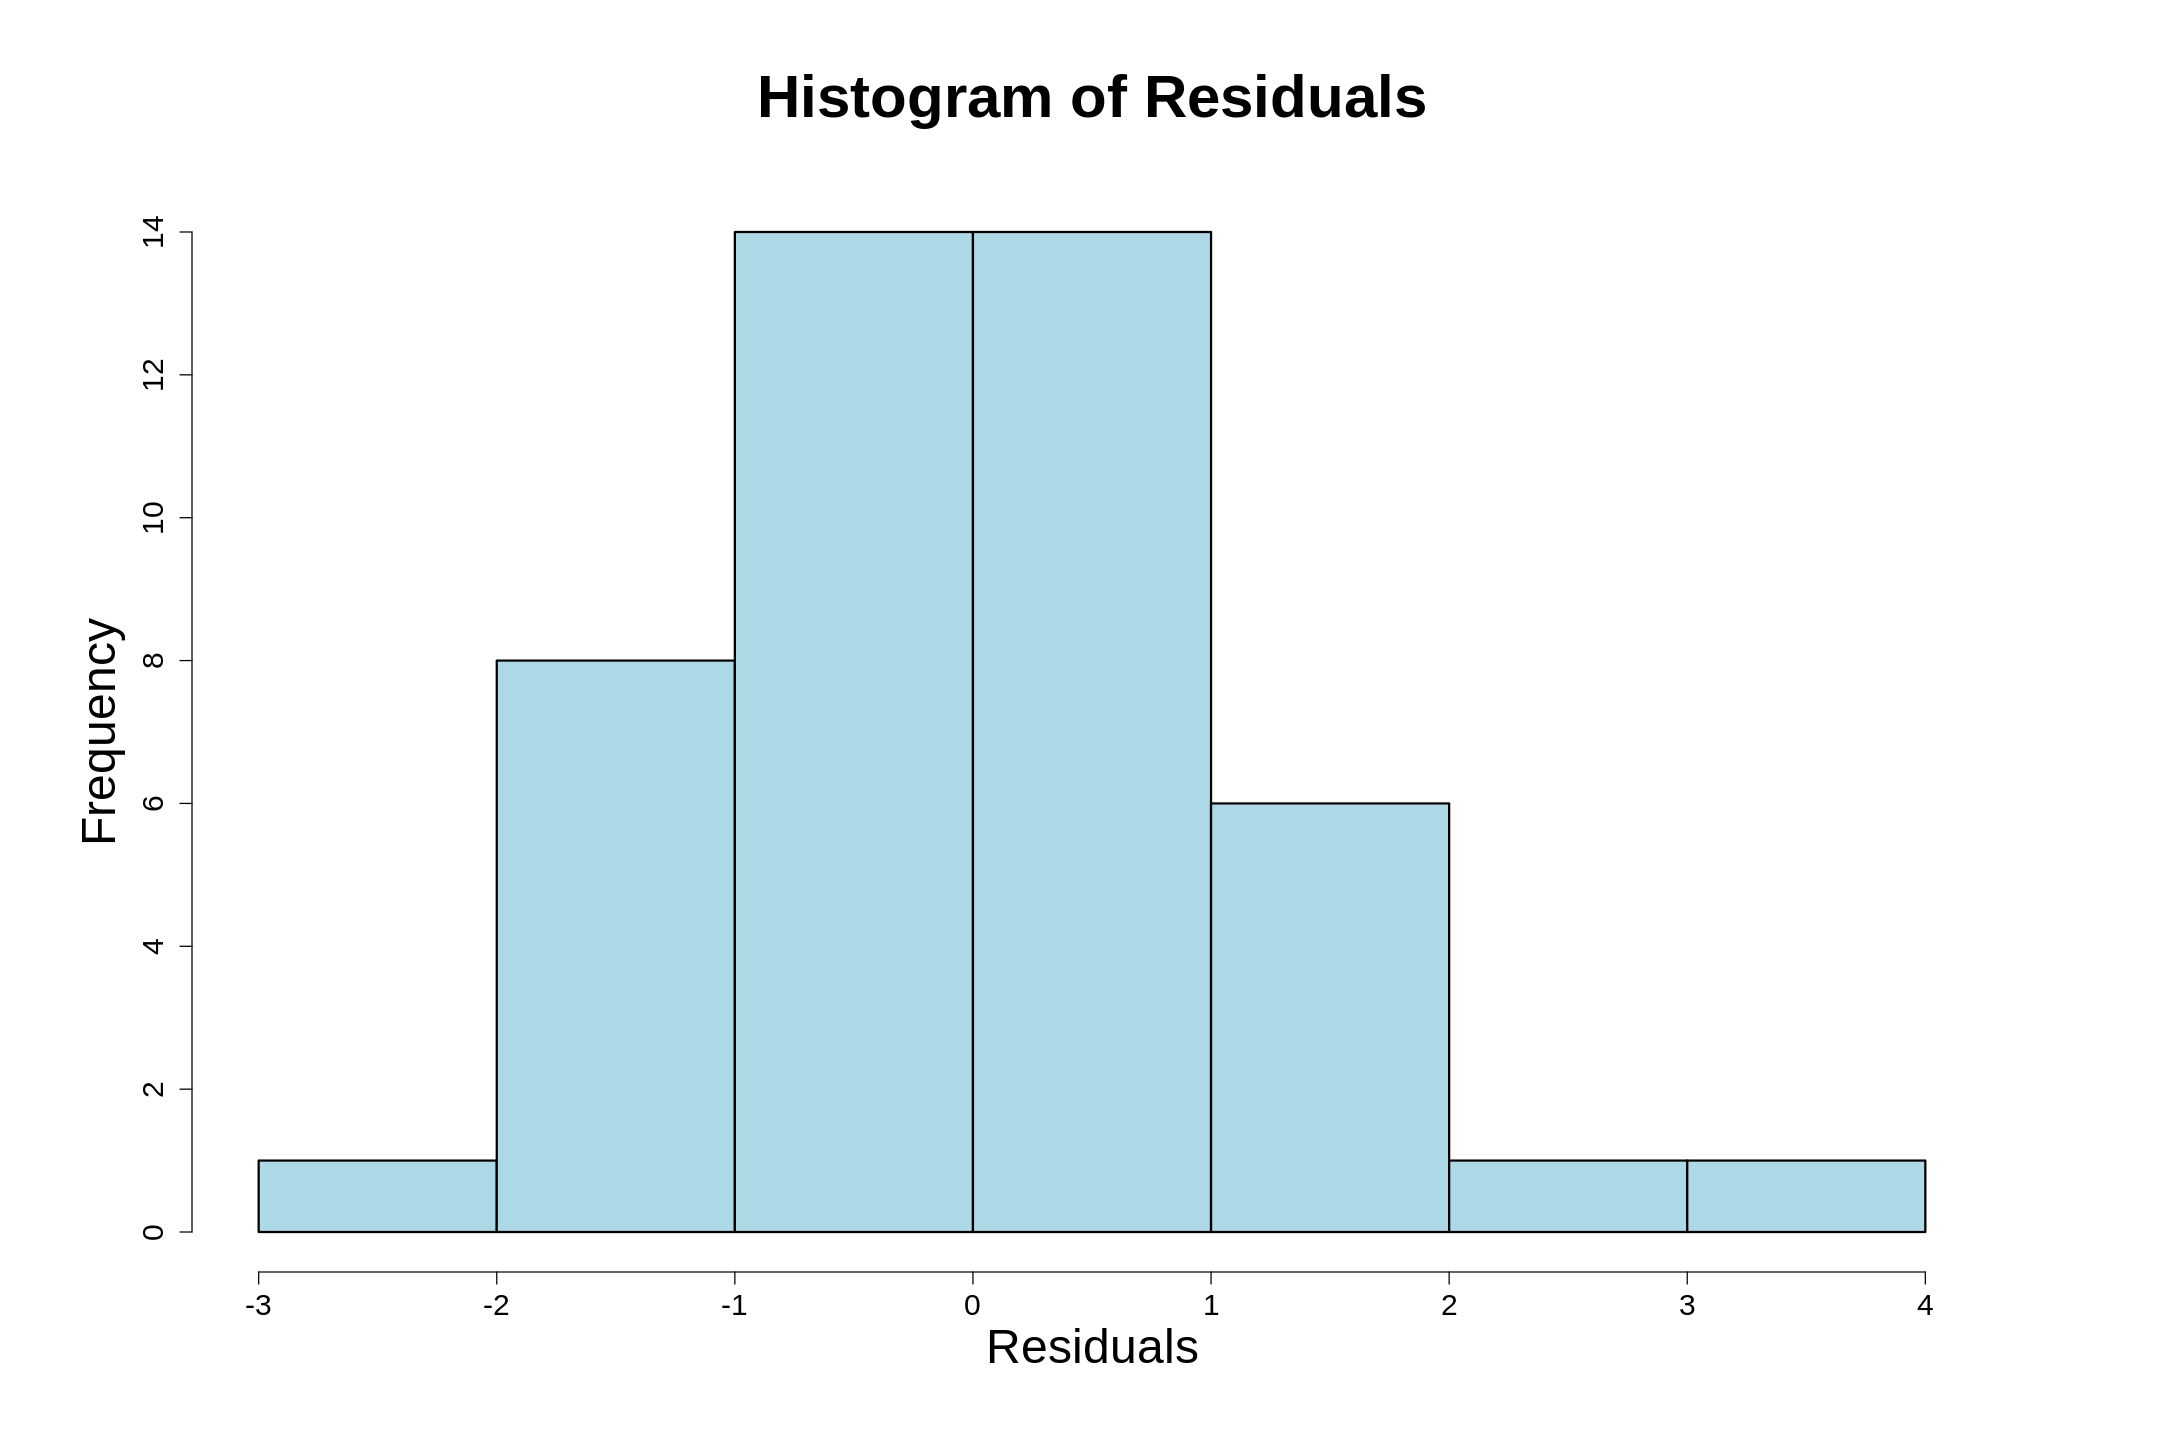

In [38]:
fplot(hist, residuals, main="Histogram of Residuals", xlab="Residuals", col="lightblue")

In [39]:
shapiro.test(residuals)
Box.test(residuals, lag=20, type="Ljung-Box")


	Shapiro-Wilk normality test

data:  residuals
W = 0.96987, p-value = 0.2865



	Box-Ljung test

data:  residuals
X-squared = 10.742, df = 20, p-value = 0.9526


Shapiro-Wilk test shows that there is no ground to reject hypothesis that residuals are normally distributed (0.2865 >> 0.05), we can also say that (due to Ljung-Box test and ACF for residuals) there is no indication that data is correlated.

In [40]:
model2 <- arima(tsbcddf, order = c(1, 0, 2))

In [41]:
summary(model2)


Call:
arima(x = tsbcddf, order = c(1, 0, 2))

Coefficients:
          ar1      ma1      ma2  intercept
      -0.8598  -0.2566  -0.4885     0.0033
s.e.   0.1231   0.2058   0.2099     0.0242

sigma^2 estimated as 0.9818:  log likelihood = -64.38,  aic = 138.75

Training set error measures:
                     ME      RMSE       MAE       MPE     MAPE      MASE
Training set 0.01230208 0.9908558 0.7577563 -41.07817 137.1412 0.2920621
                   ACF1
Training set 0.02514137

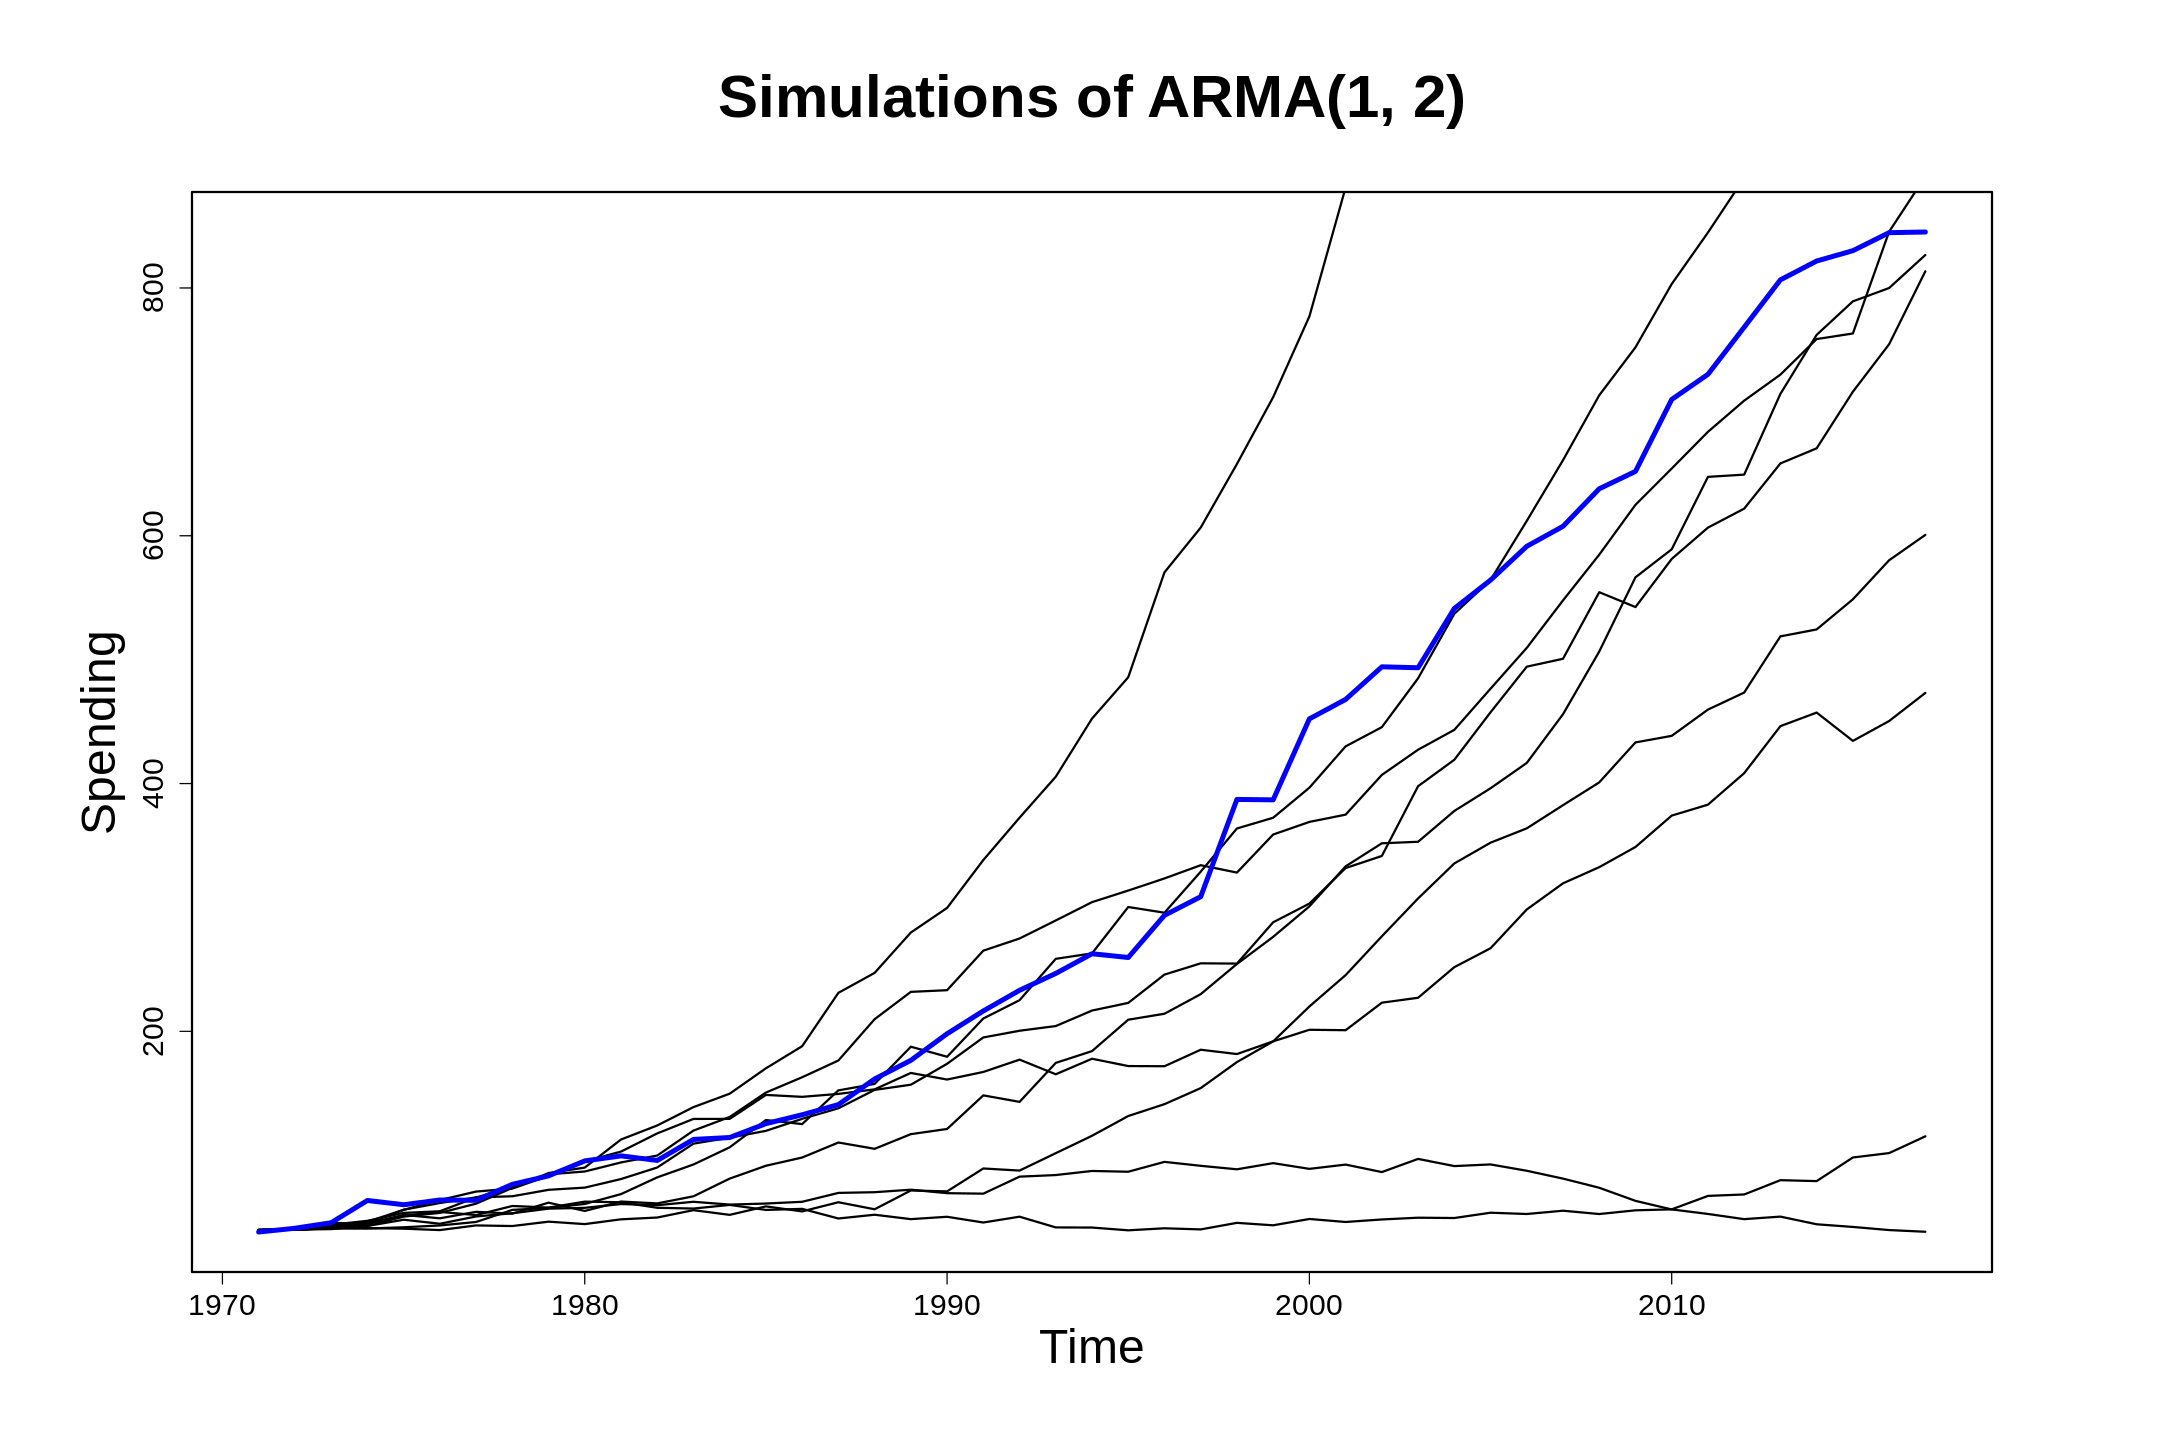

In [42]:
plot_sims(seeds, model2, tsr, ylab="Spending", main="Simulations of ARMA(1, 2)", col="blue")

In [43]:
residuals <- residuals(model2)

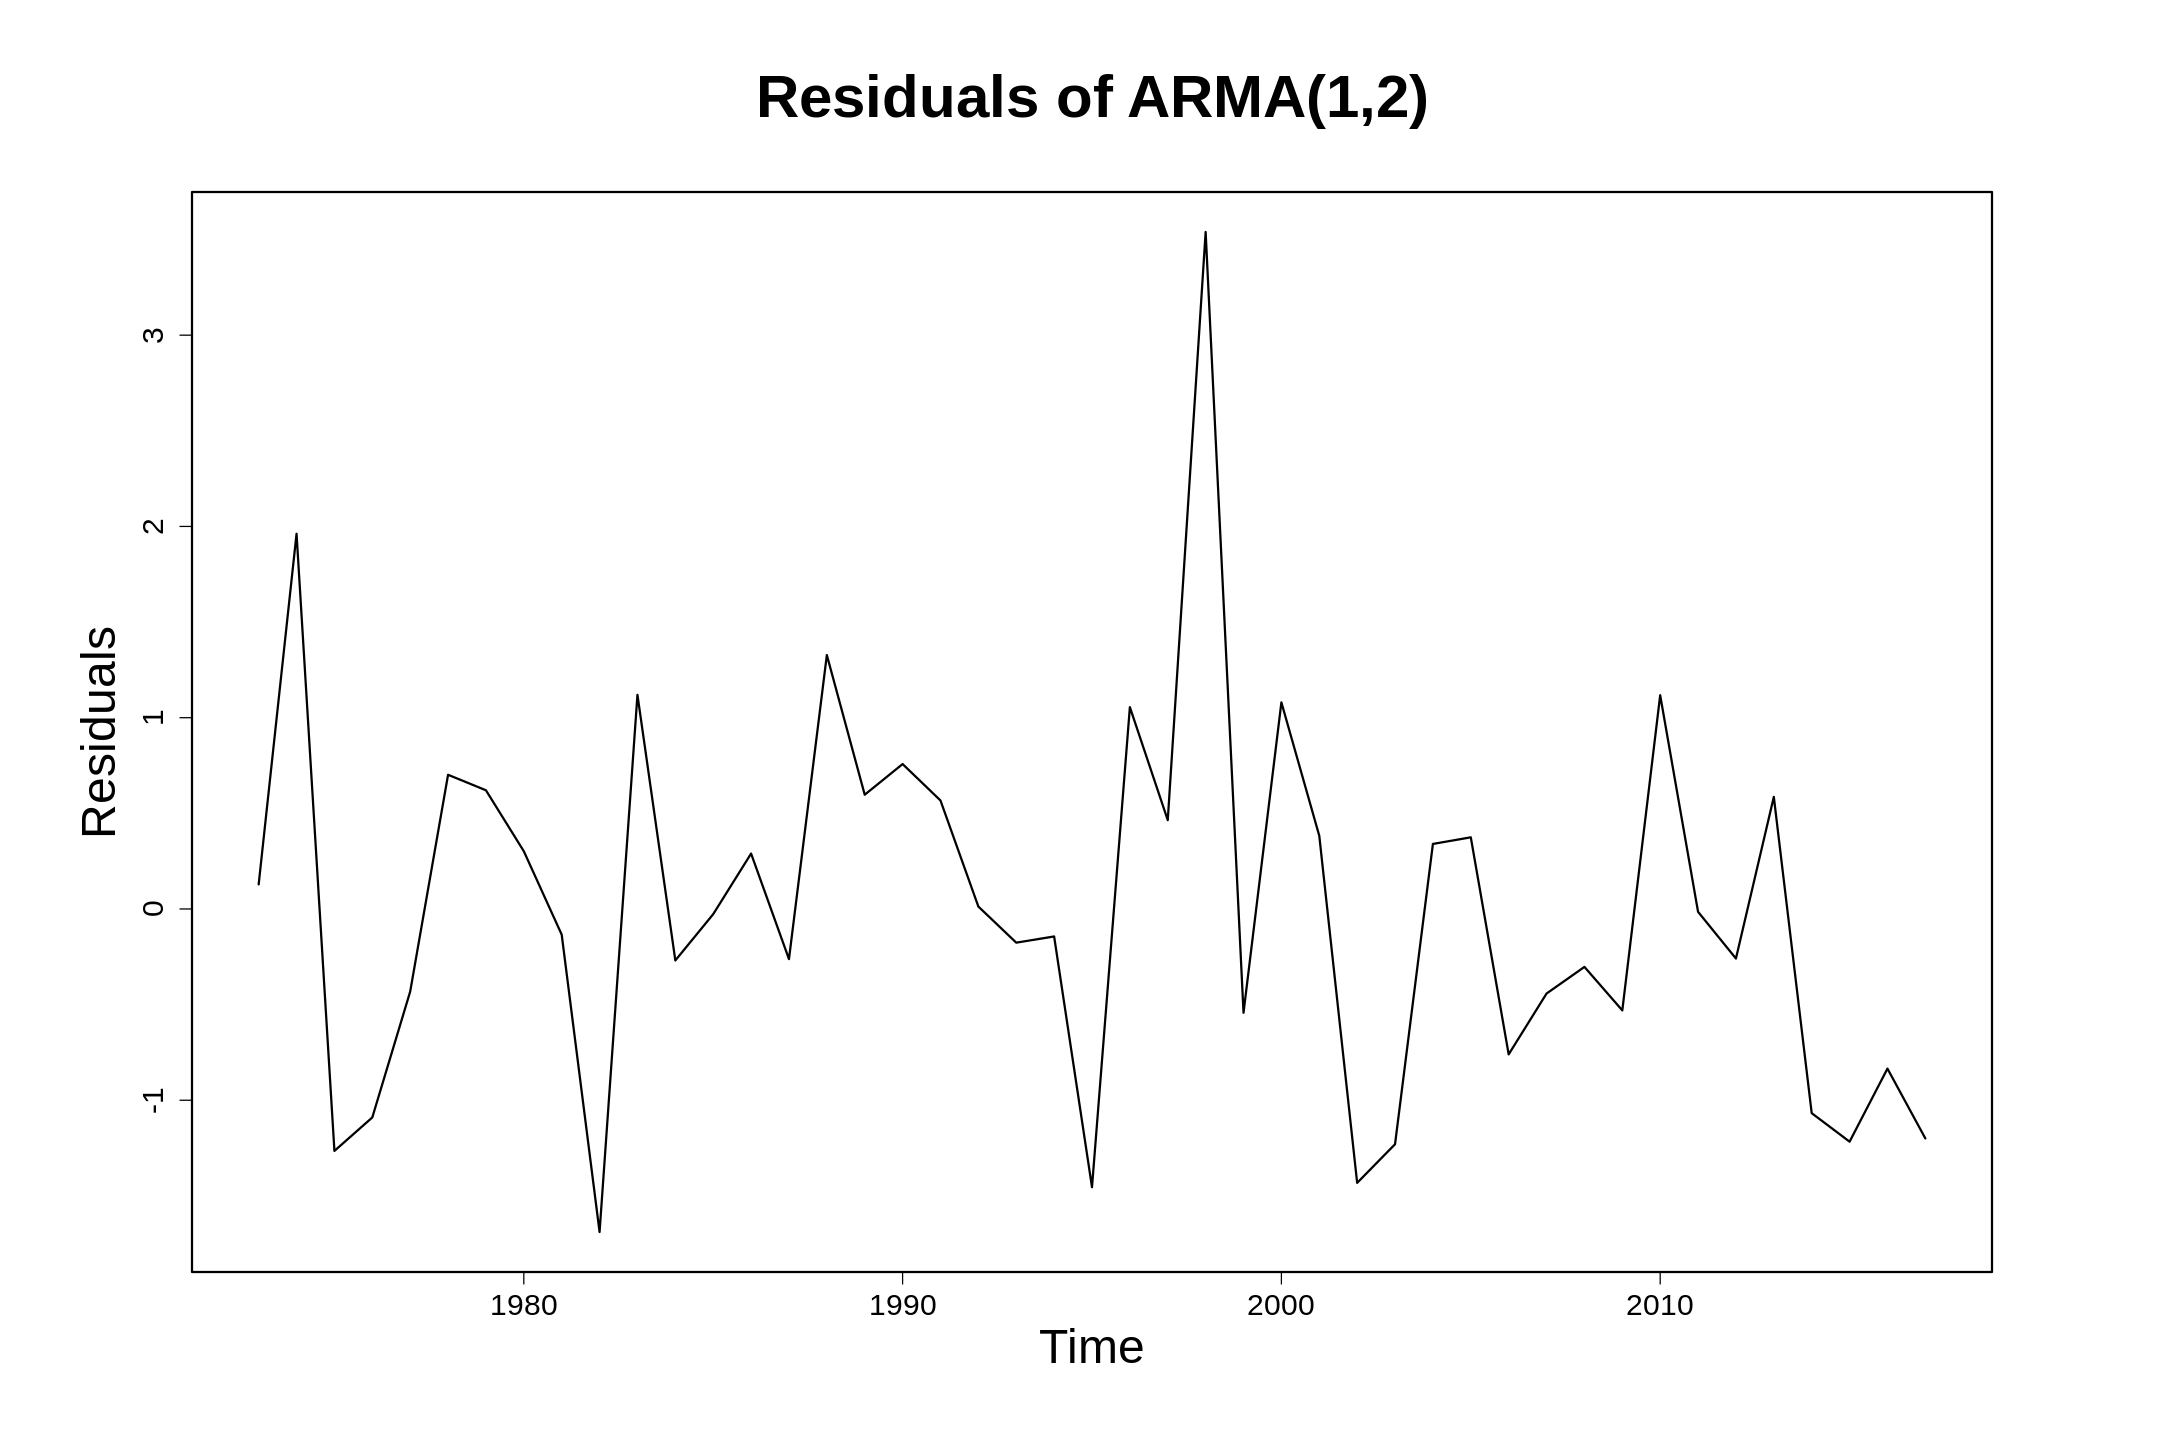

In [44]:
fplot(plot, residuals, main="Residuals of ARMA(1,2)", ylab="Residuals", xlab="Time", type="l")

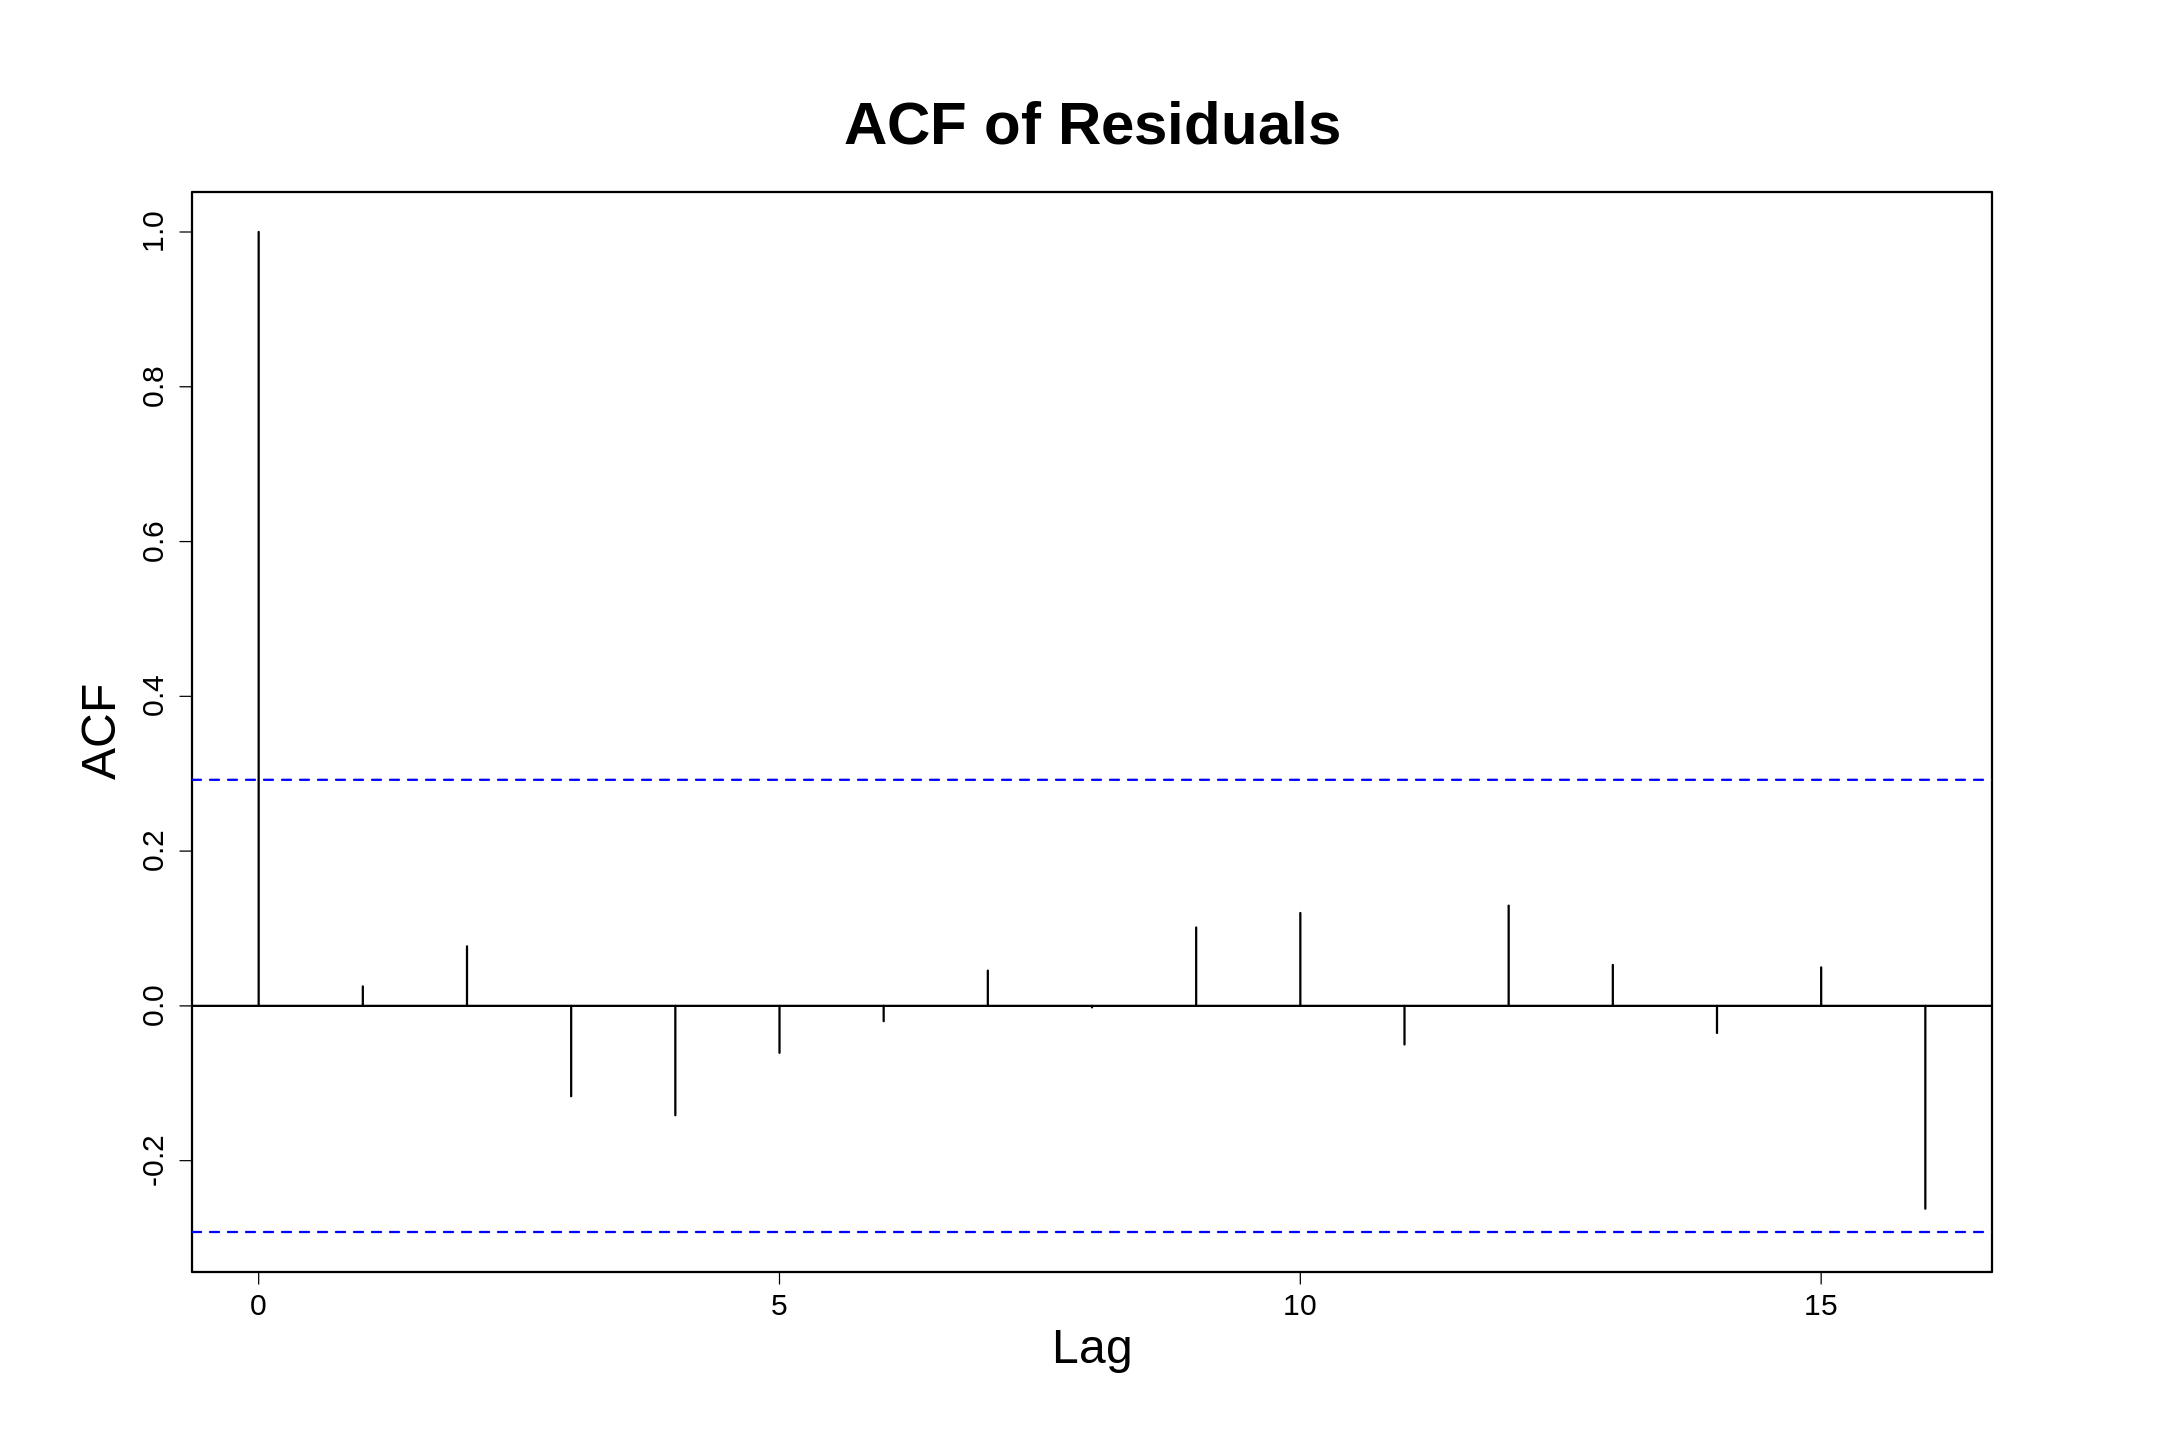

In [45]:
fplot(acf, residuals, main="ACF of Residuals")

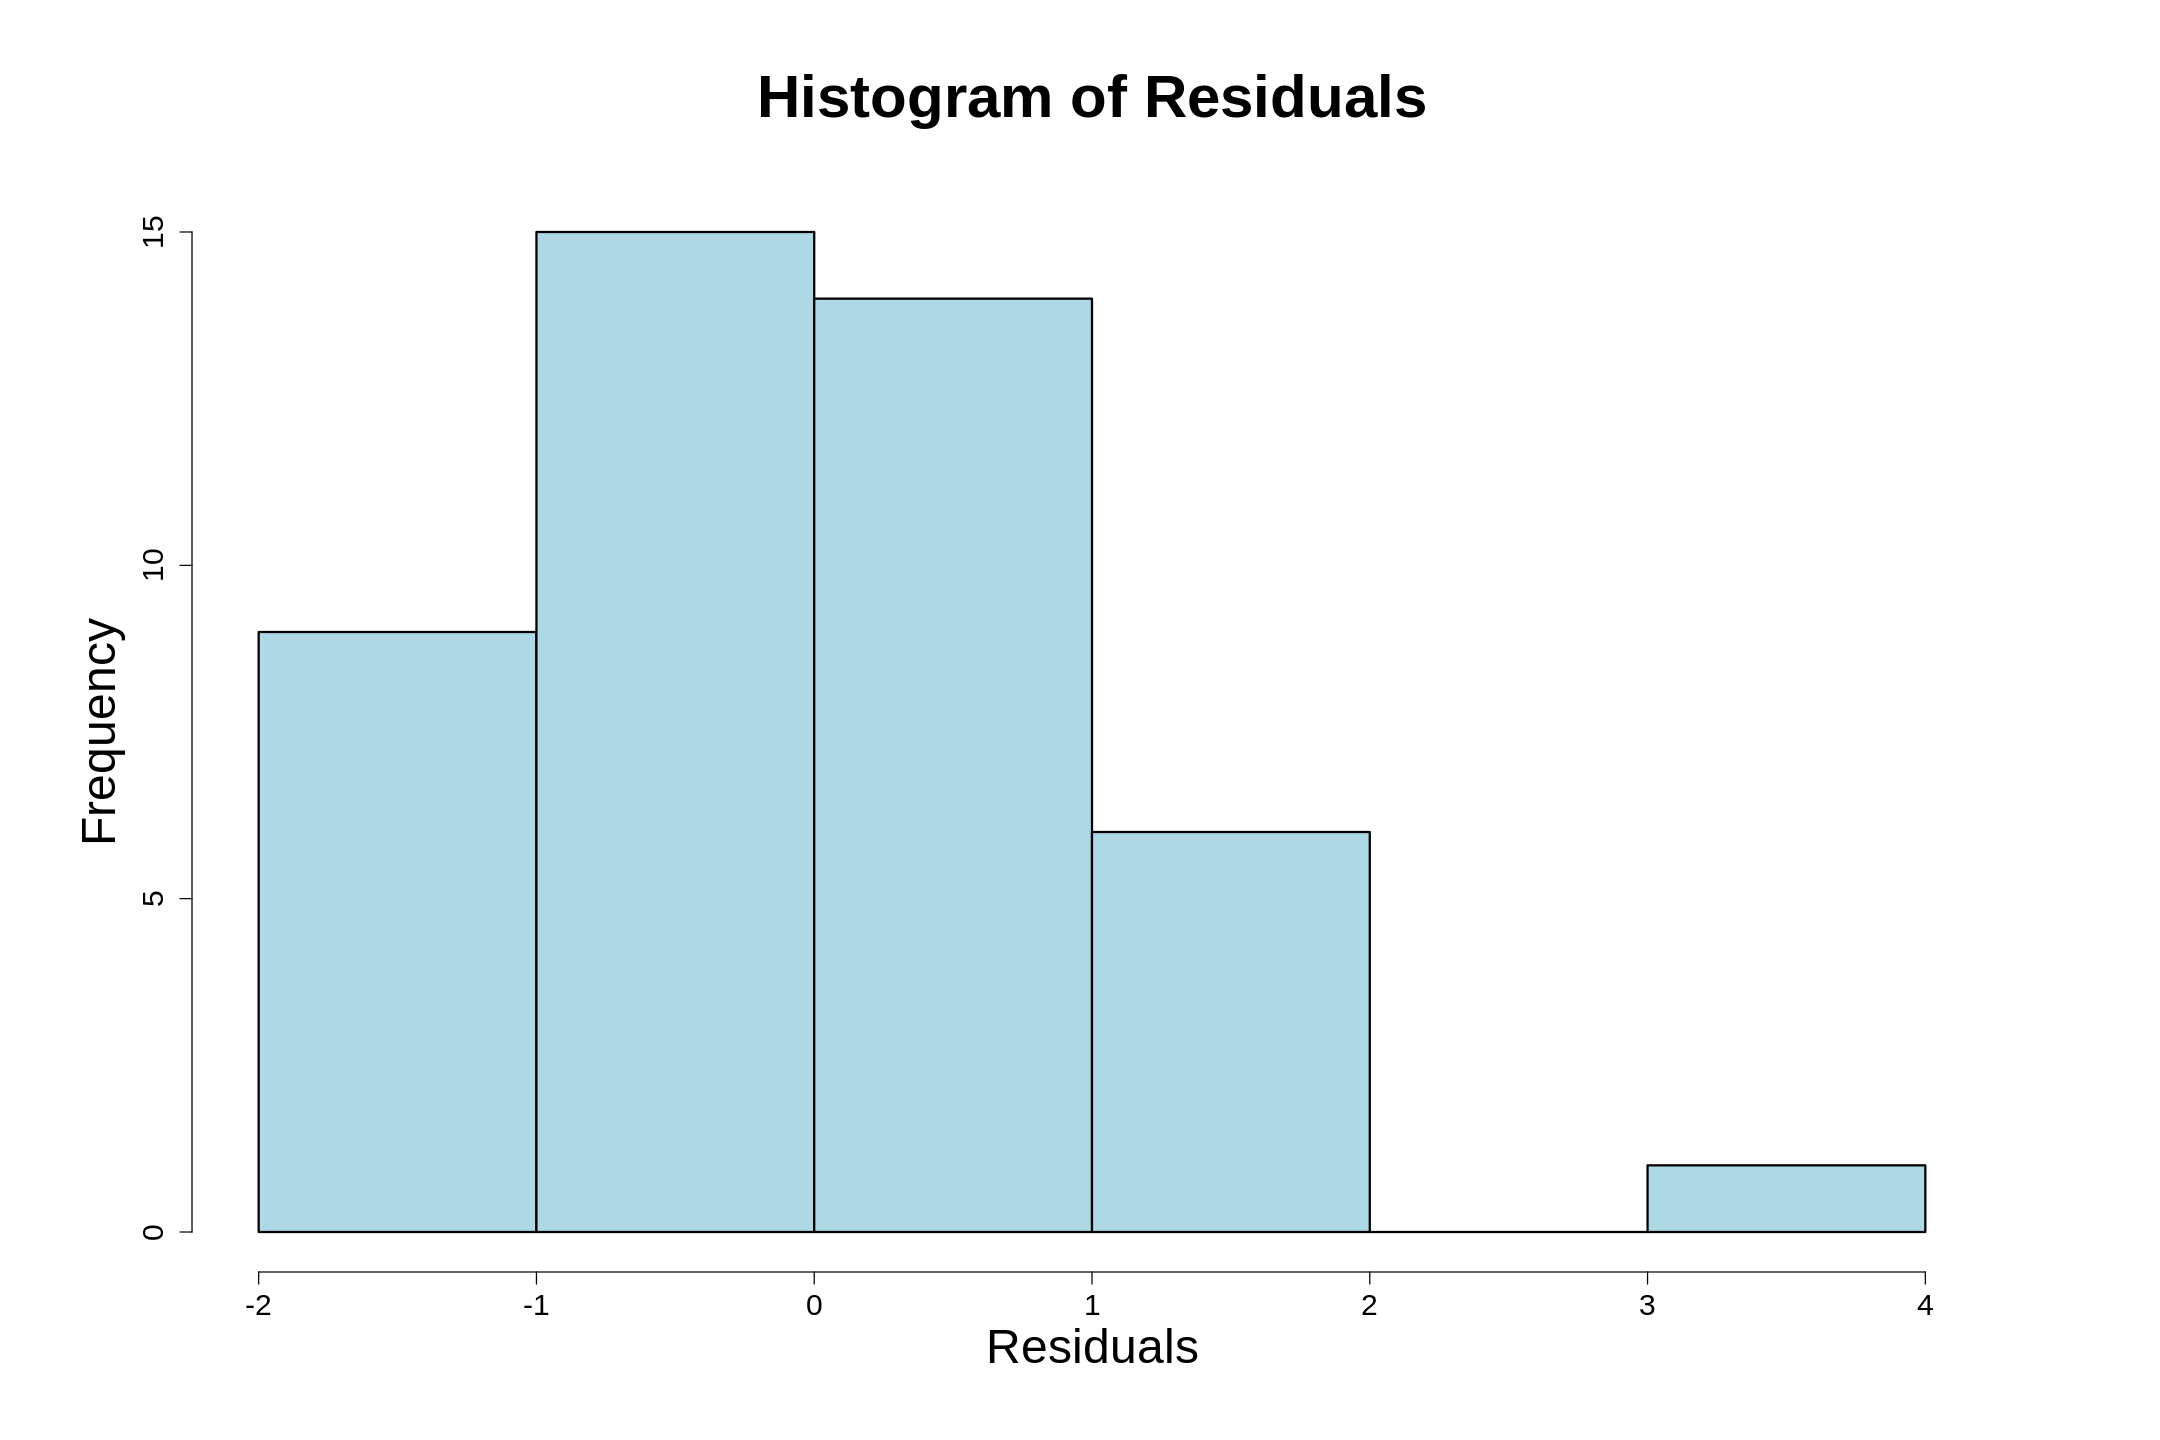

In [46]:
fplot(hist, residuals, main="Histogram of Residuals", xlab="Residuals", col="lightblue")

In [47]:
shapiro.test(residuals)
Box.test(residuals, lag=20, type="Ljung-Box")


	Shapiro-Wilk normality test

data:  residuals
W = 0.9461, p-value = 0.03622



	Box-Ljung test

data:  residuals
X-squared = 12.79, df = 20, p-value = 0.8862


residuals are not normally distributed (0.036 < 0.05), but are likely uncorrelated (0.8126 >> 0.05).


In [48]:
model3 <- arima(tsbcddf, order = c(2, 0, 2))

In [49]:
summary(model3)


Call:
arima(x = tsbcddf, order = c(2, 0, 2))

Coefficients:
          ar1     ar2      ma1      ma2  intercept
      -0.3910  0.3203  -0.7434  -0.2566     0.0089
s.e.   0.3637  0.2004   0.3884   0.3750     0.0122

sigma^2 estimated as 0.916:  log likelihood = -63.85,  aic = 139.71

Training set error measures:
                     ME      RMSE       MAE       MPE    MAPE      MASE
Training set 0.07059196 0.9570645 0.7347397 -42.31872 131.099 0.2831908
                    ACF1
Training set -0.02321852

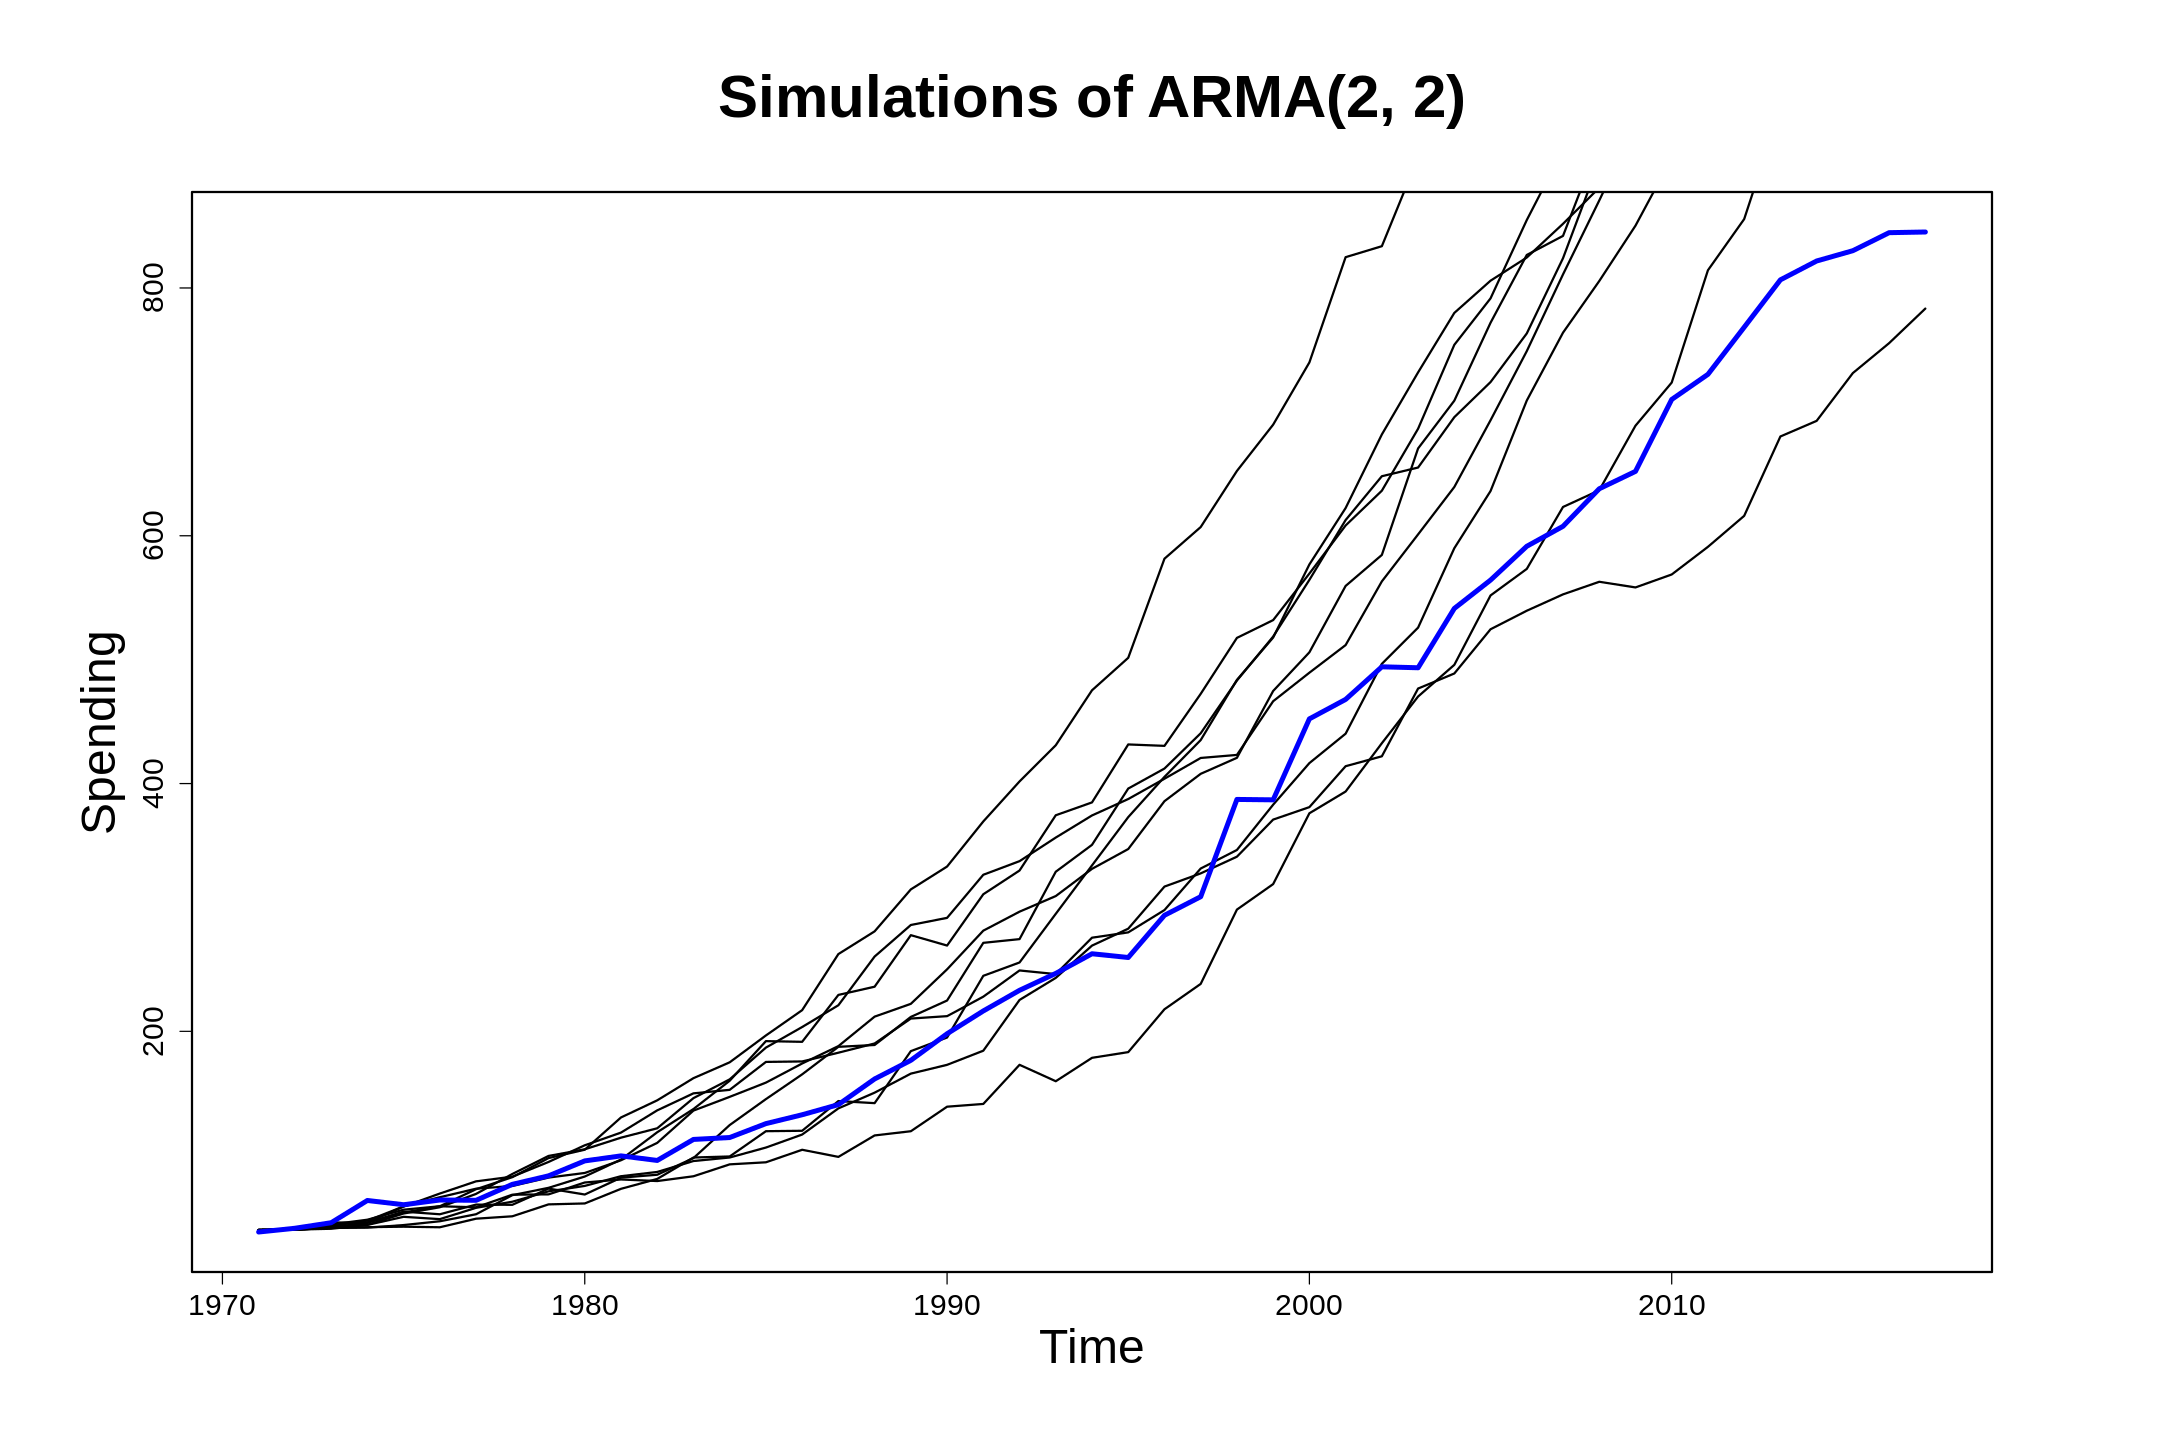

In [50]:
plot_sims(seeds, model3, tsr, ylab="Spending", main="Simulations of ARMA(2, 2)", col="blue")

Visually, the ARMA(2,2) model performs the best.🦖

In [51]:
residuals <- residuals(model3)

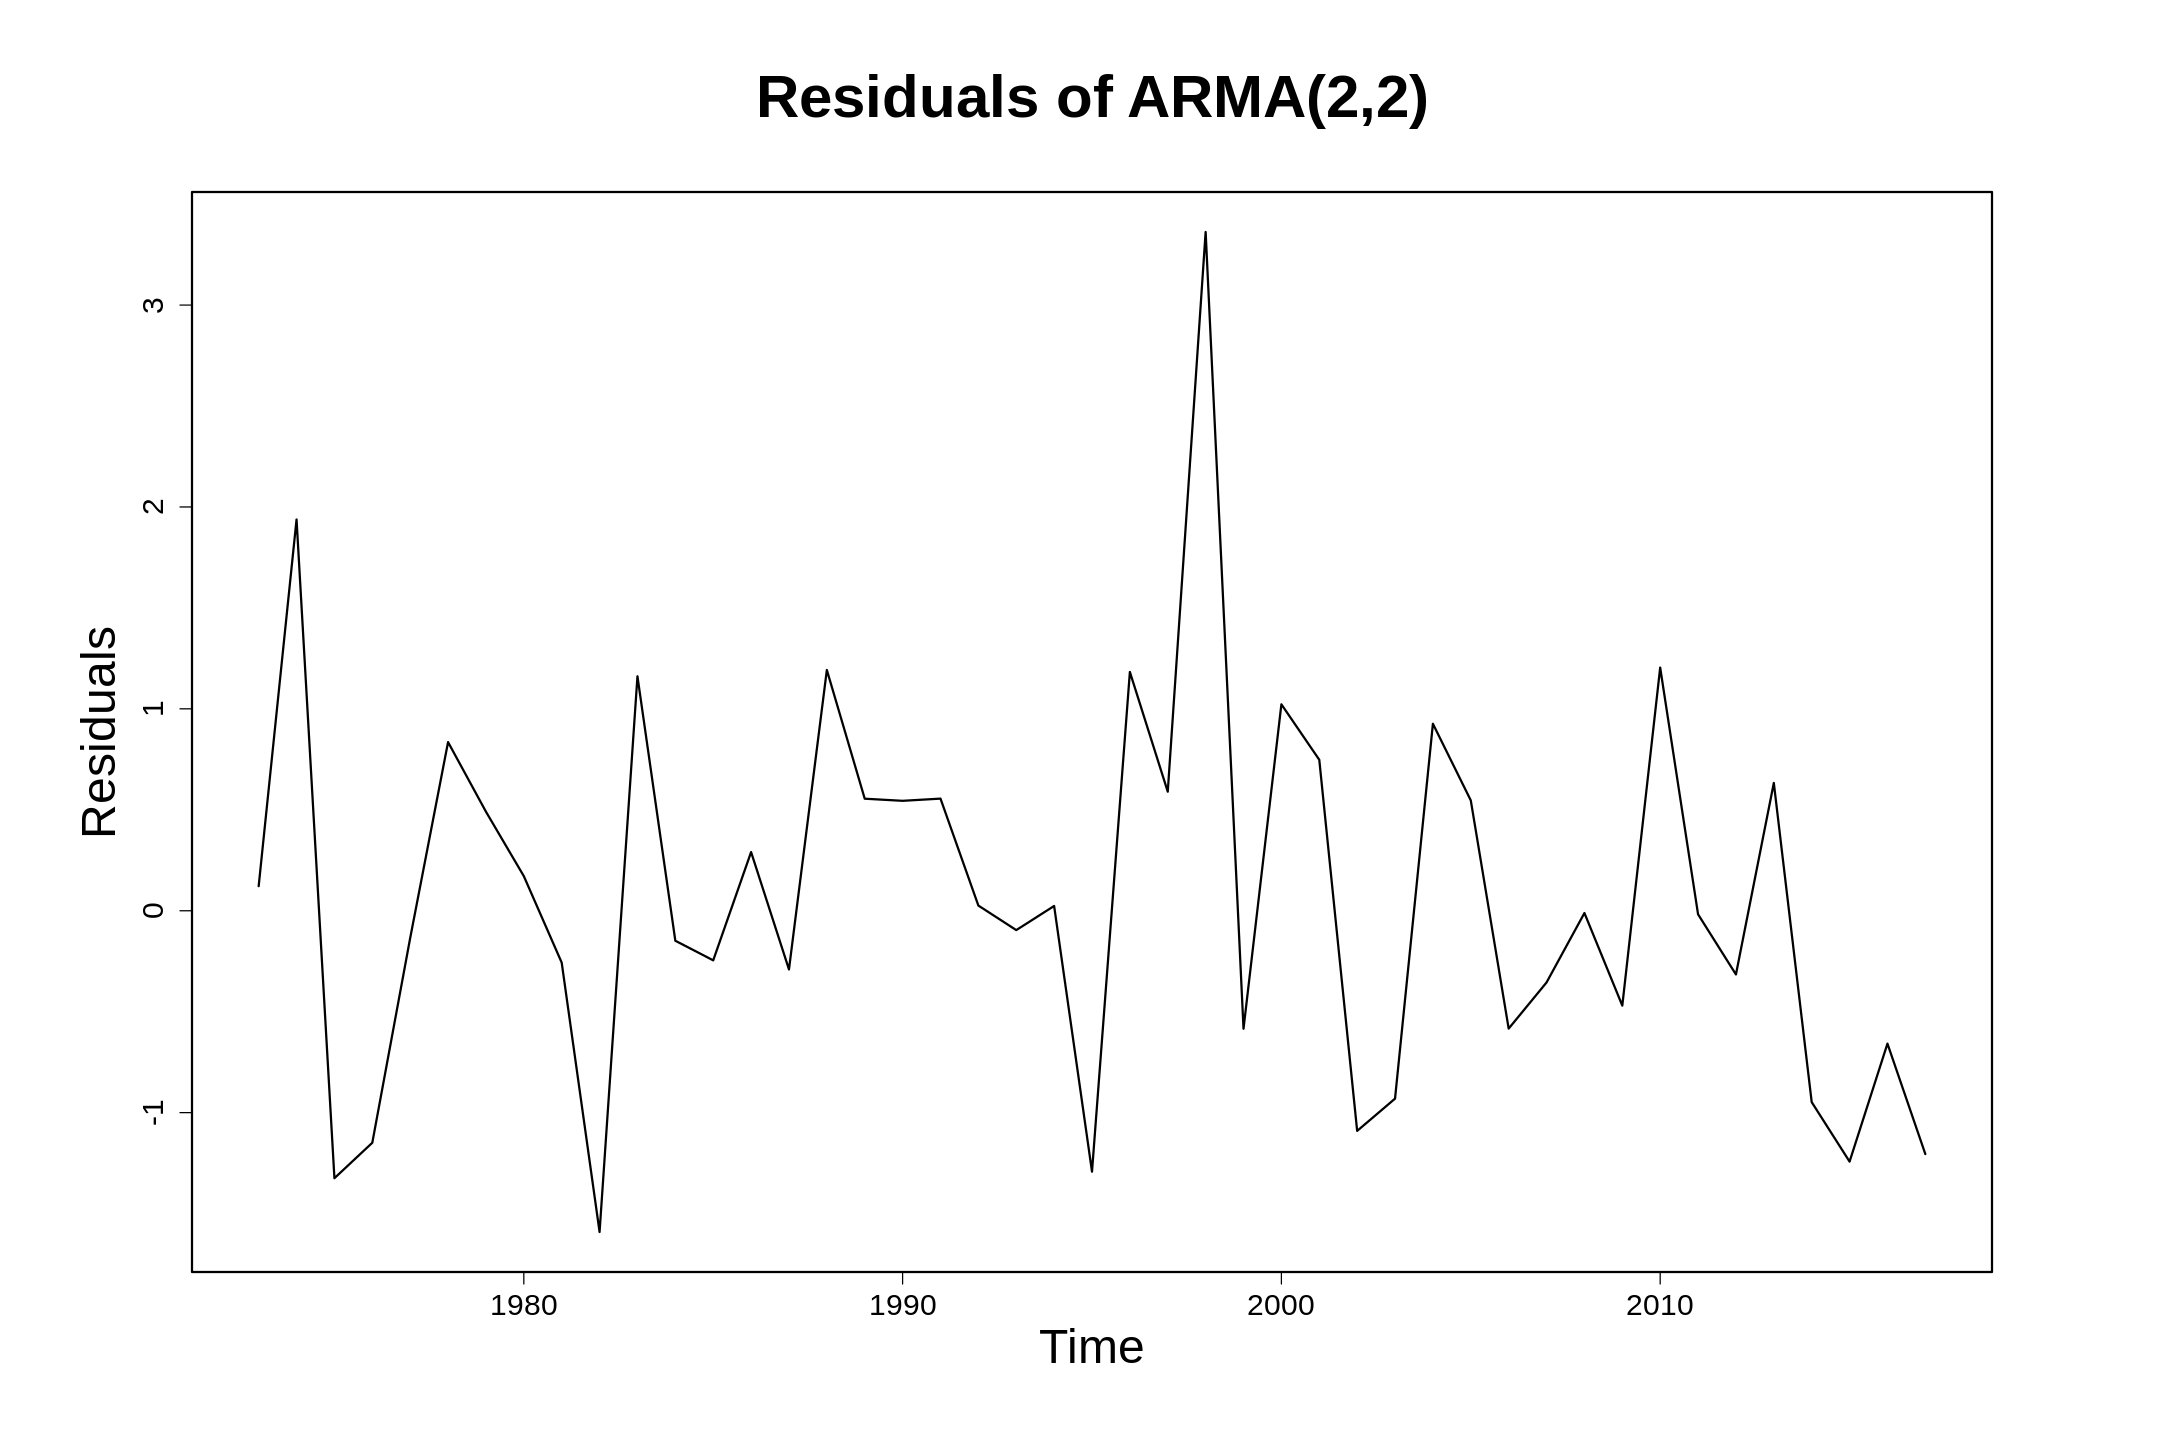

In [52]:
fplot(plot, residuals, main="Residuals of ARMA(2,2)", ylab="Residuals", xlab="Time", type="l")

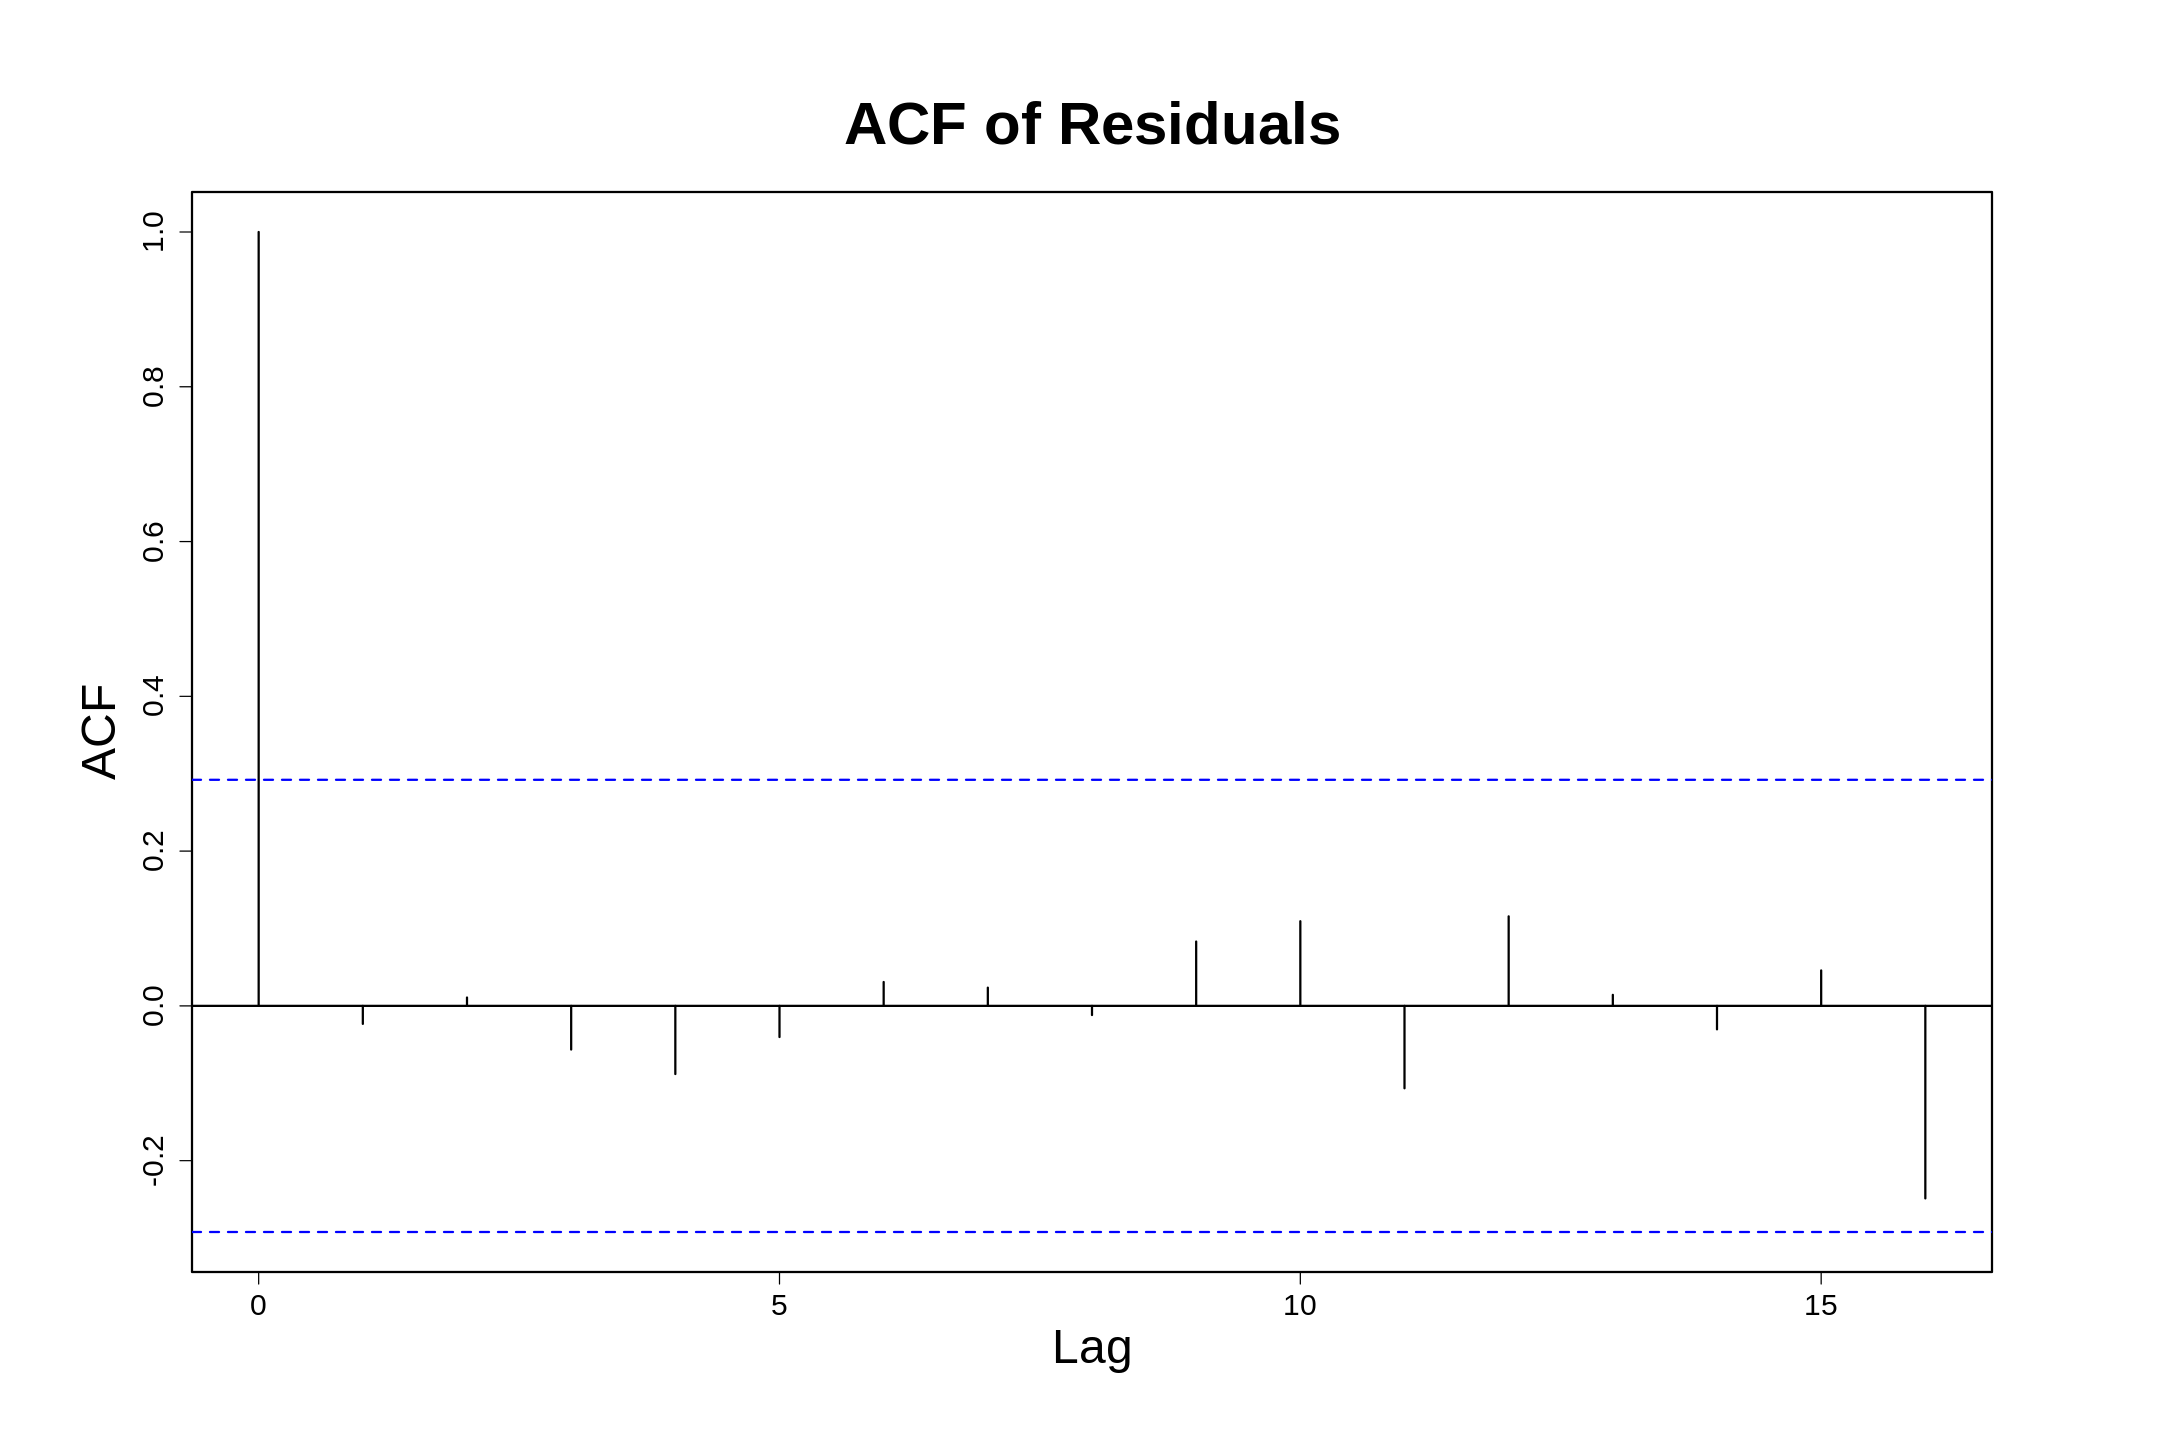

In [53]:
fplot(acf, residuals, main="ACF of Residuals")

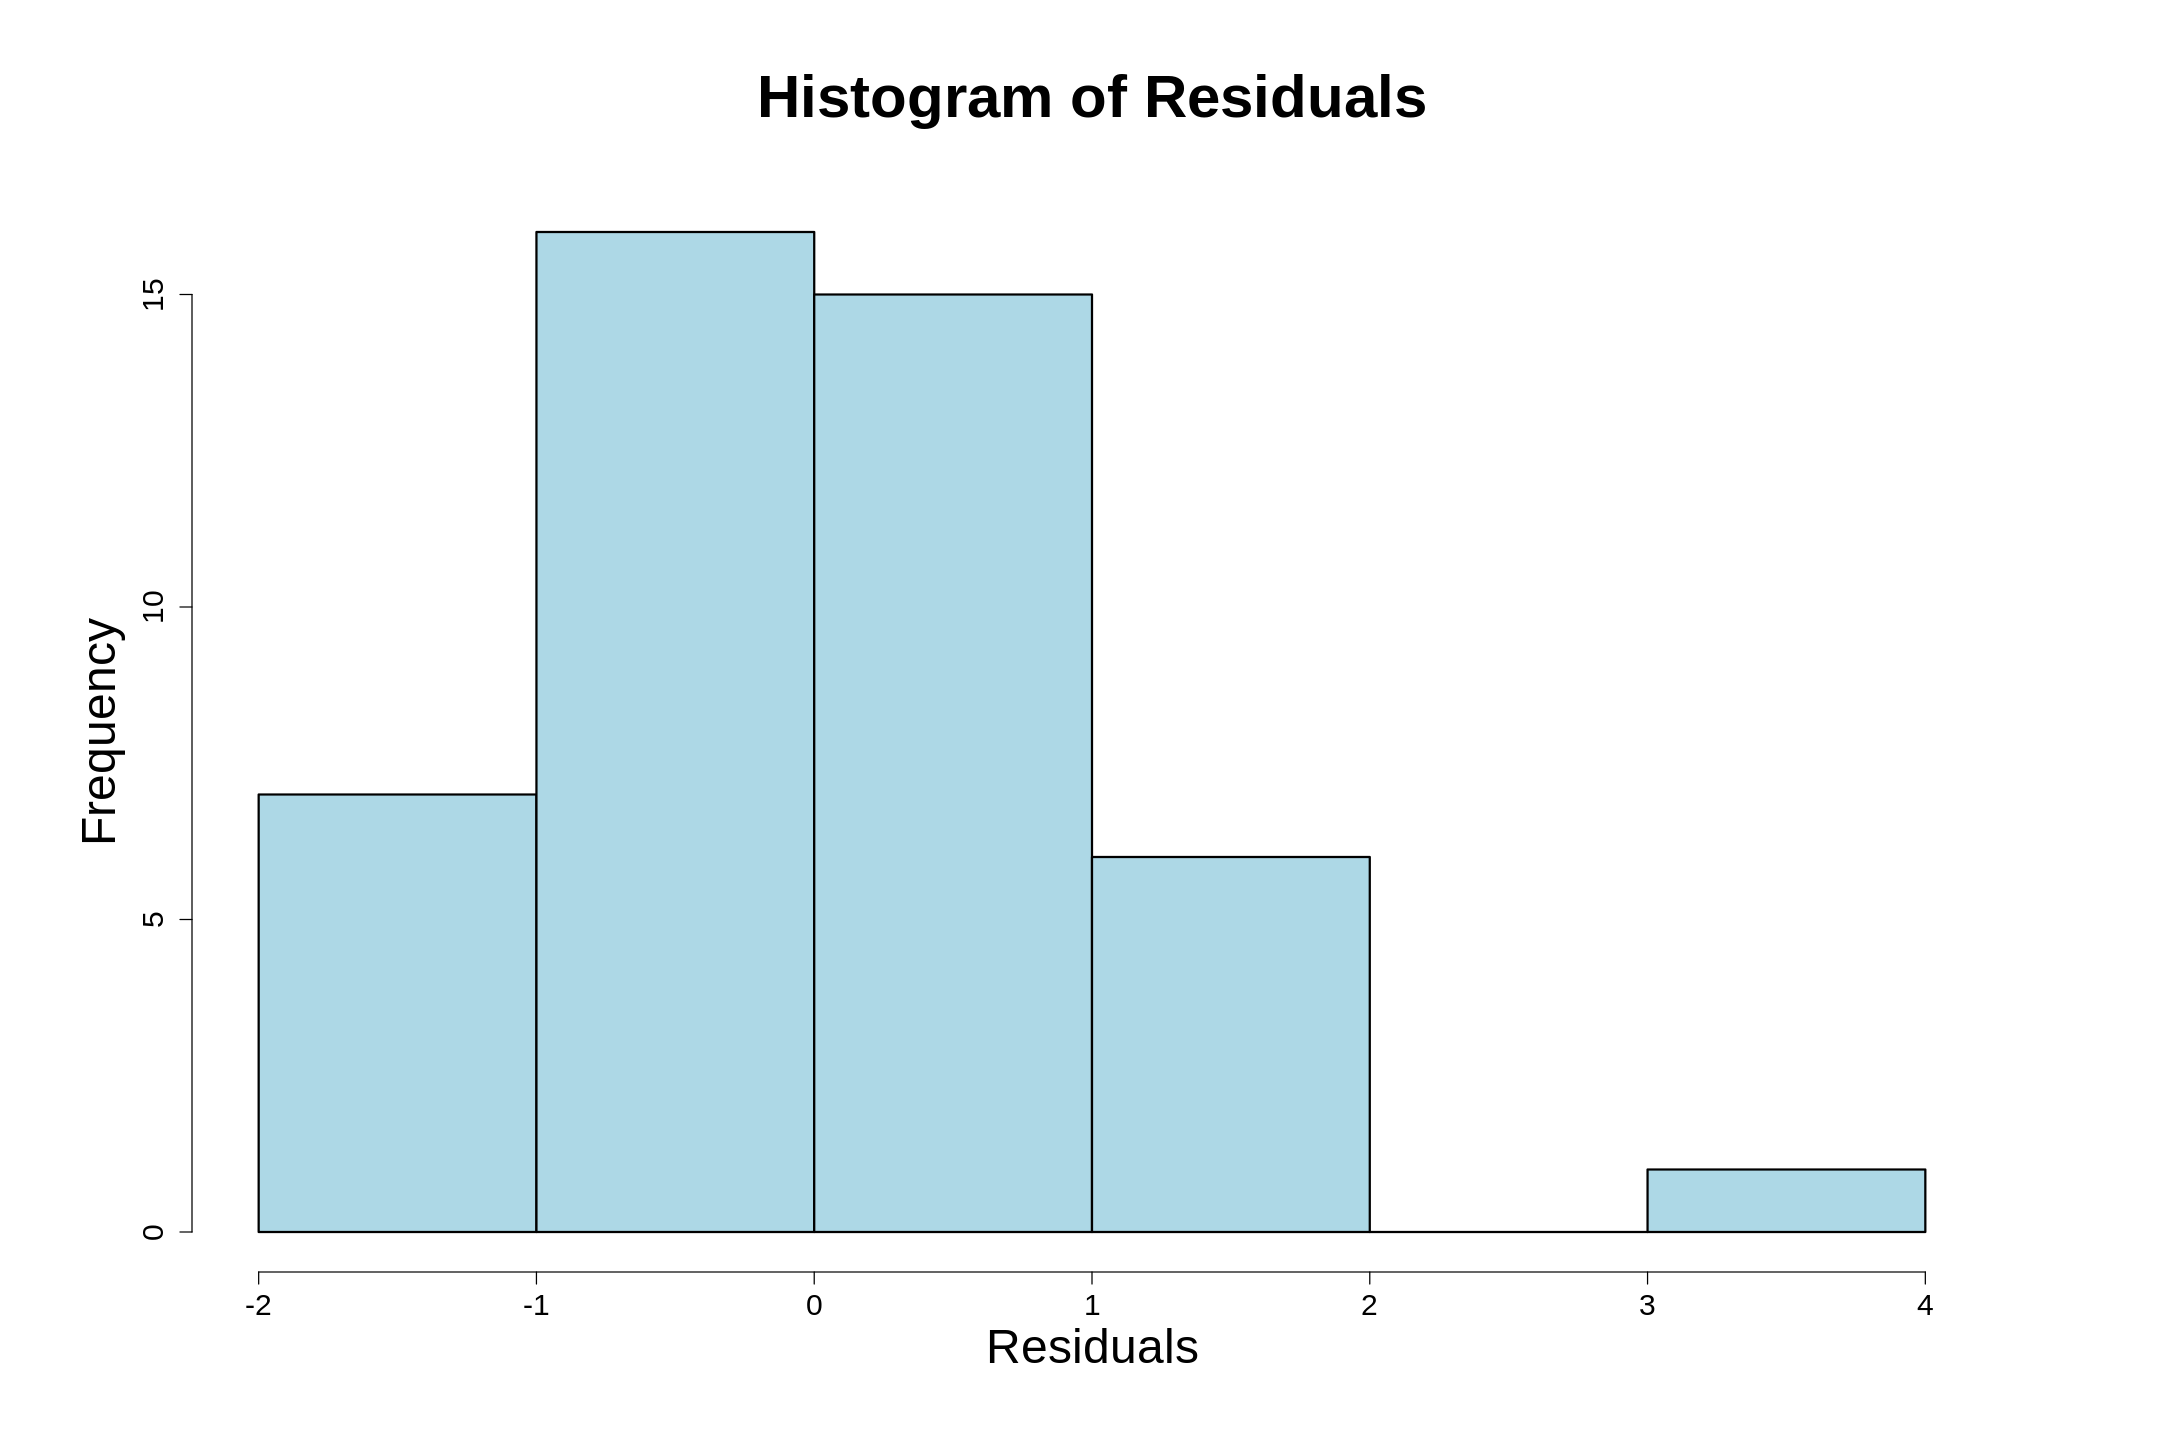

In [54]:
fplot(hist, residuals, main="Histogram of Residuals", xlab="Residuals", col="lightblue")

In [55]:
shapiro.test(residuals)
Box.test(residuals, lag=20, type="Ljung-Box")


	Shapiro-Wilk normality test

data:  residuals
W = 0.95239, p-value = 0.0626



	Box-Ljung test

data:  residuals
X-squared = 10.732, df = 20, p-value = 0.9529


This model is also working

In [56]:
model4 <- arima(tsbcddf, order = c(1, 0, 1))

In [57]:
summary(model4)


Call:
arima(x = tsbcddf, order = c(1, 0, 1))

Coefficients:
          ar1      ma1  intercept
      -0.4704  -0.7302    -0.0030
s.e.   0.1721   0.2180     0.0323

sigma^2 estimated as 1.083:  log likelihood = -66.44,  aic = 140.88

Training set error measures:
                      ME     RMSE       MAE       MPE     MAPE      MASE
Training set 0.008254192 1.040464 0.7736626 -3.237673 115.9523 0.2981929
                  ACF1
Training set 0.1001172

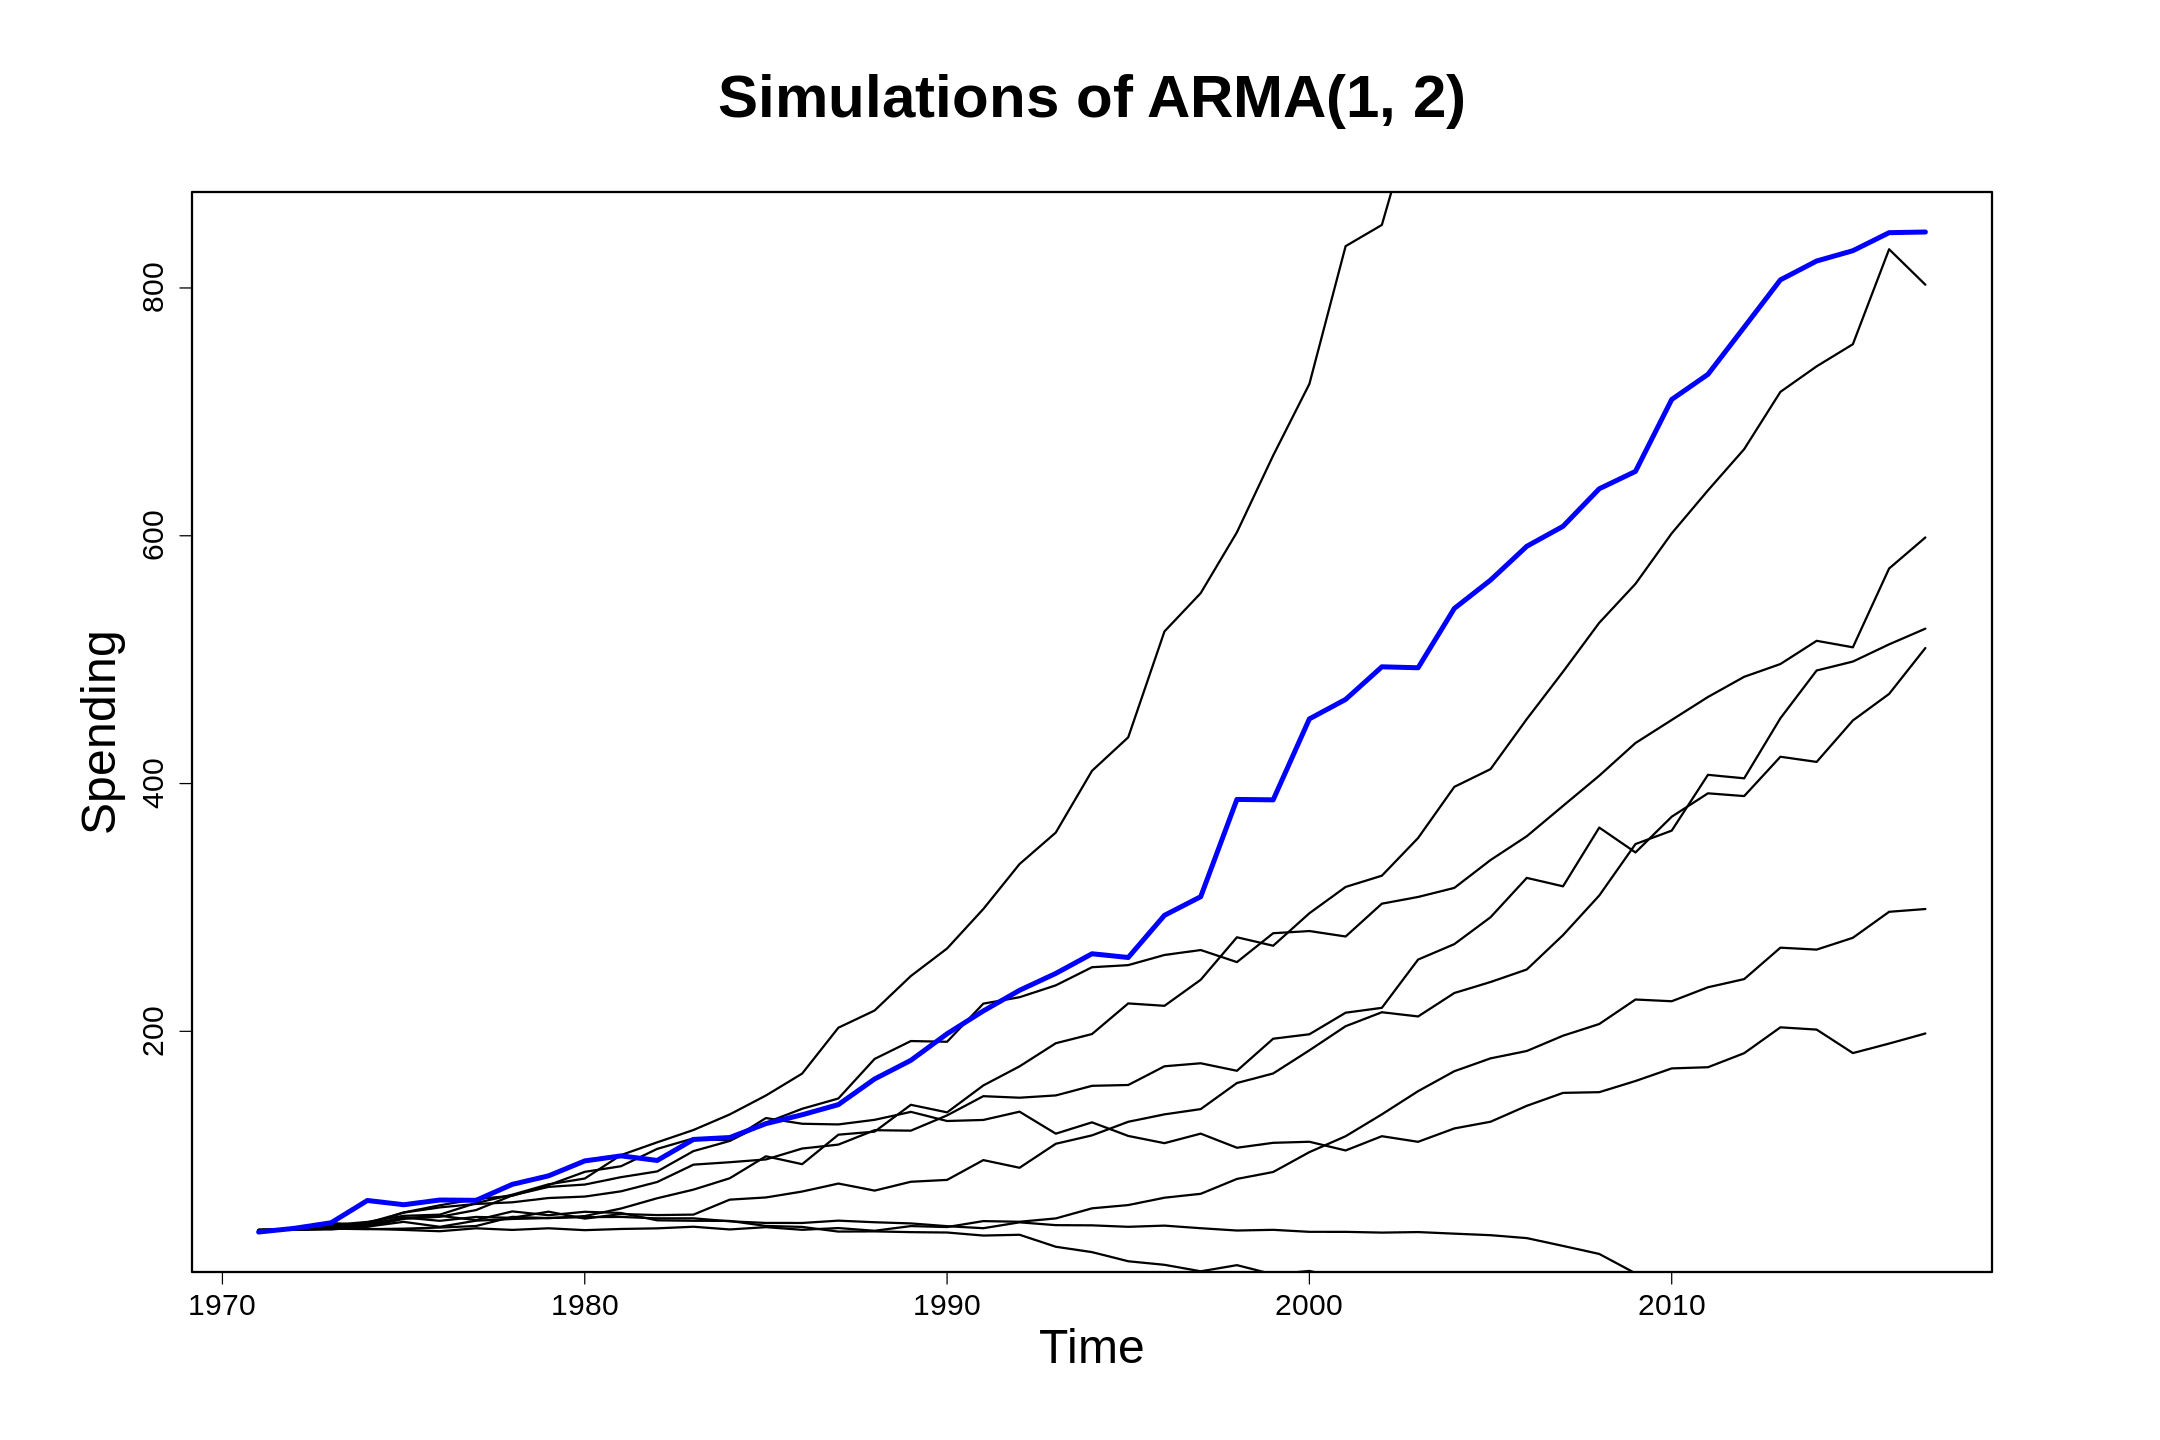

In [58]:
plot_sims(seeds, model4, tsr, ylab="Spending", main="Simulations of ARMA(1, 2)", col="blue")

In [59]:
residuals <- residuals(model4)

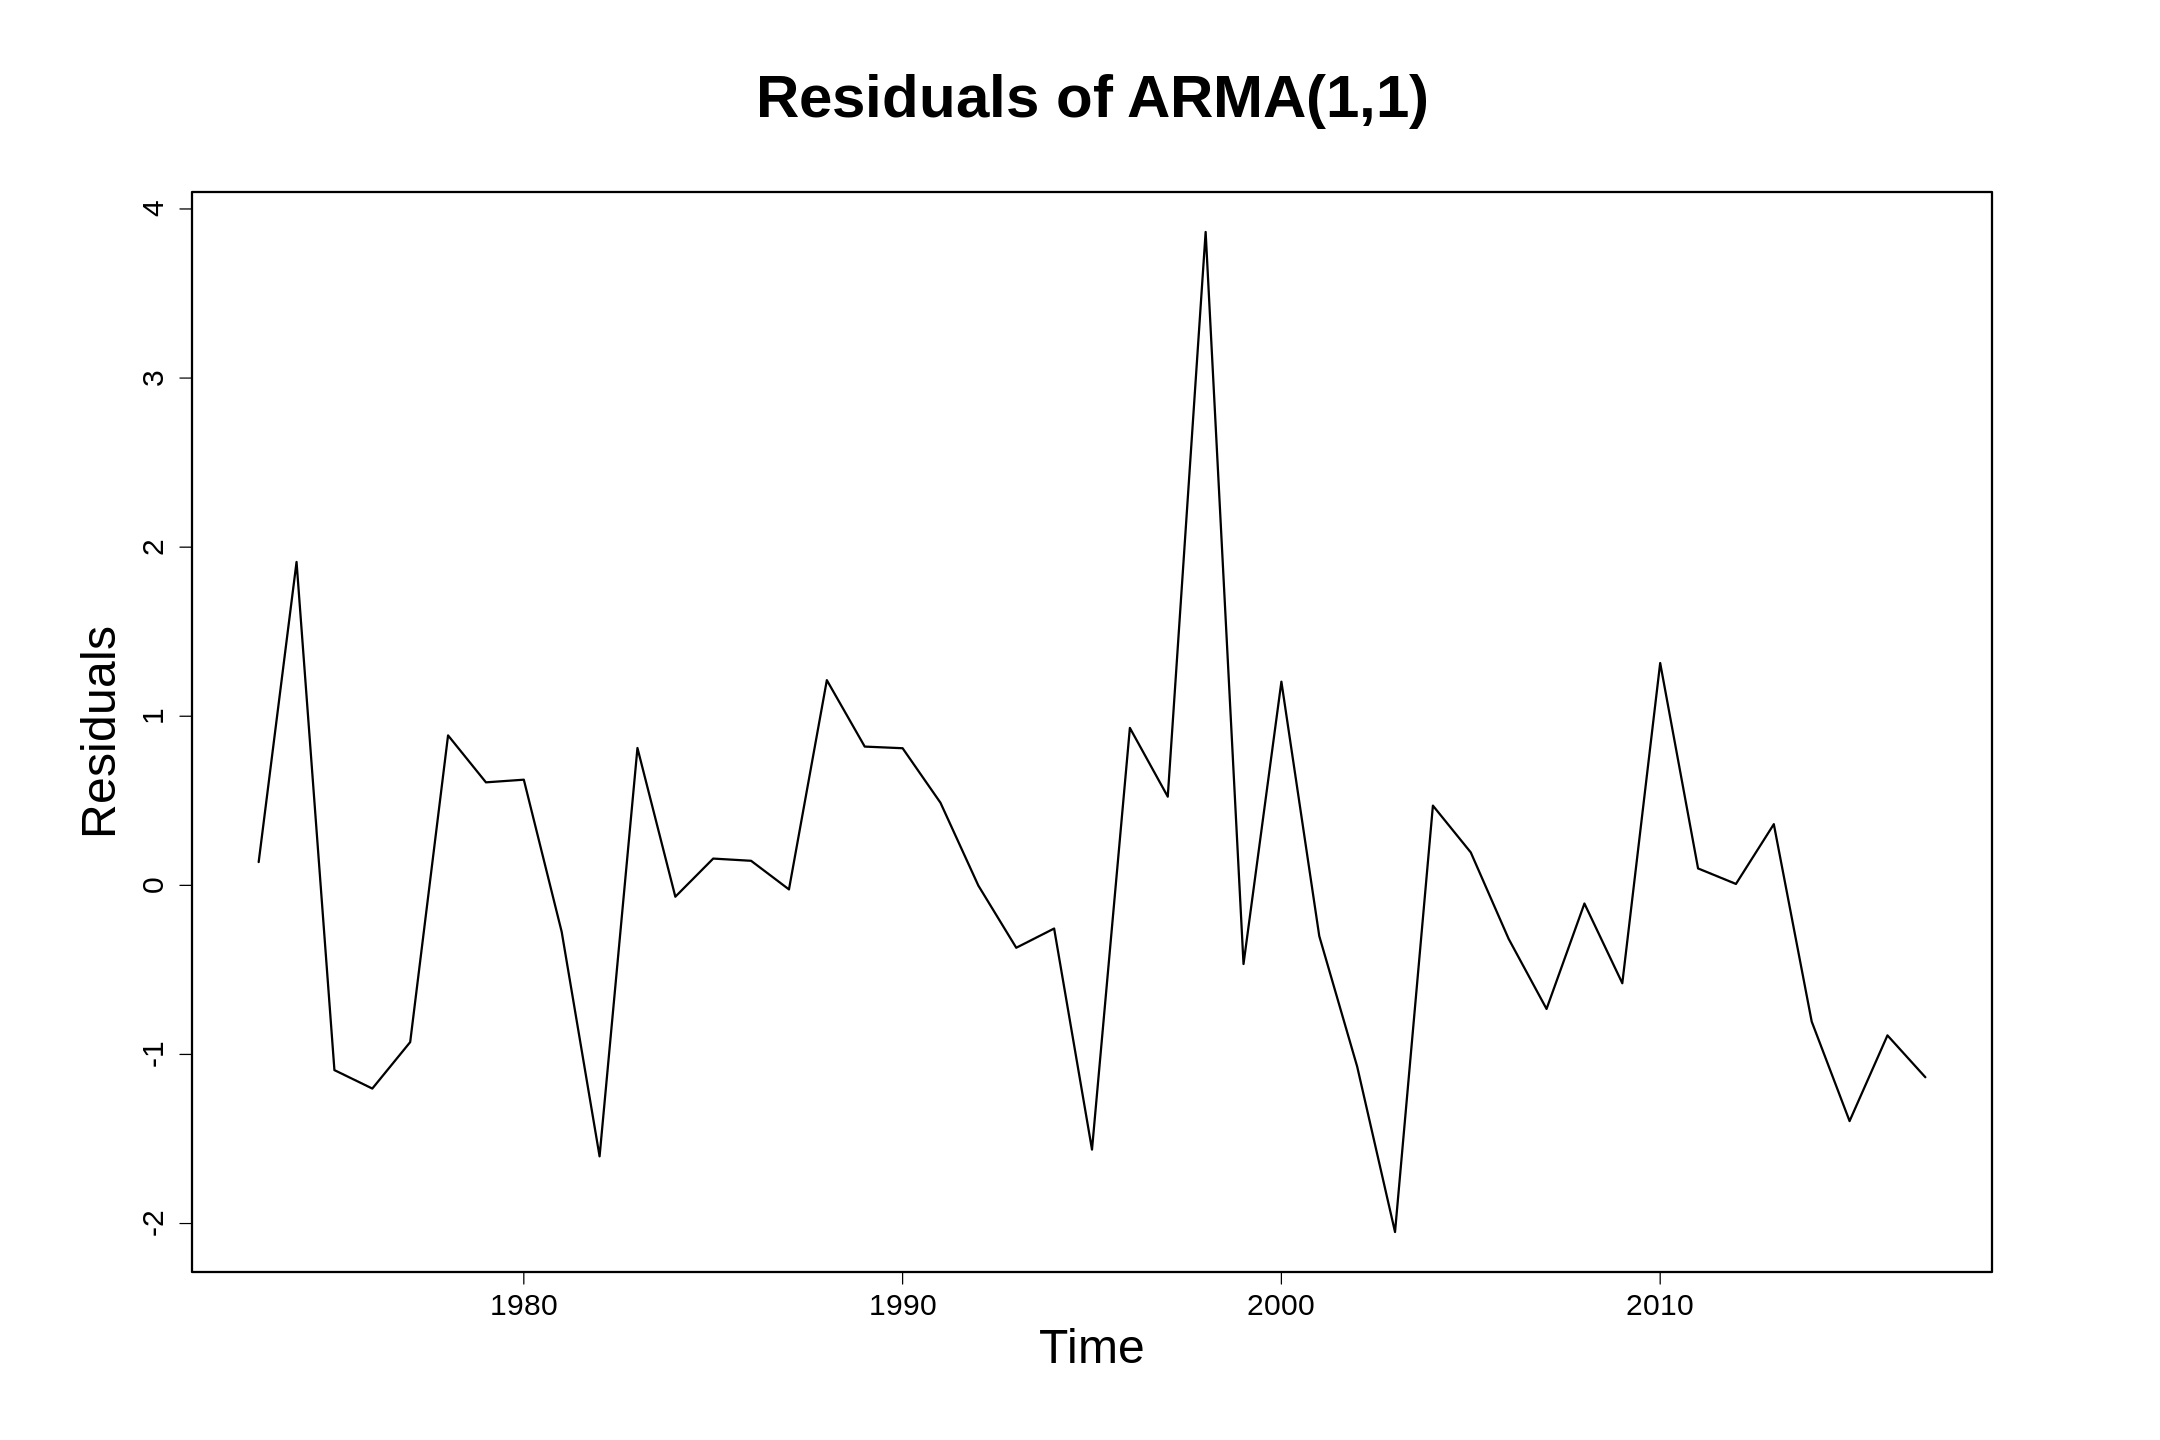

In [60]:
fplot(plot, residuals, main="Residuals of ARMA(1,1)", ylab="Residuals", xlab="Time", type="l")

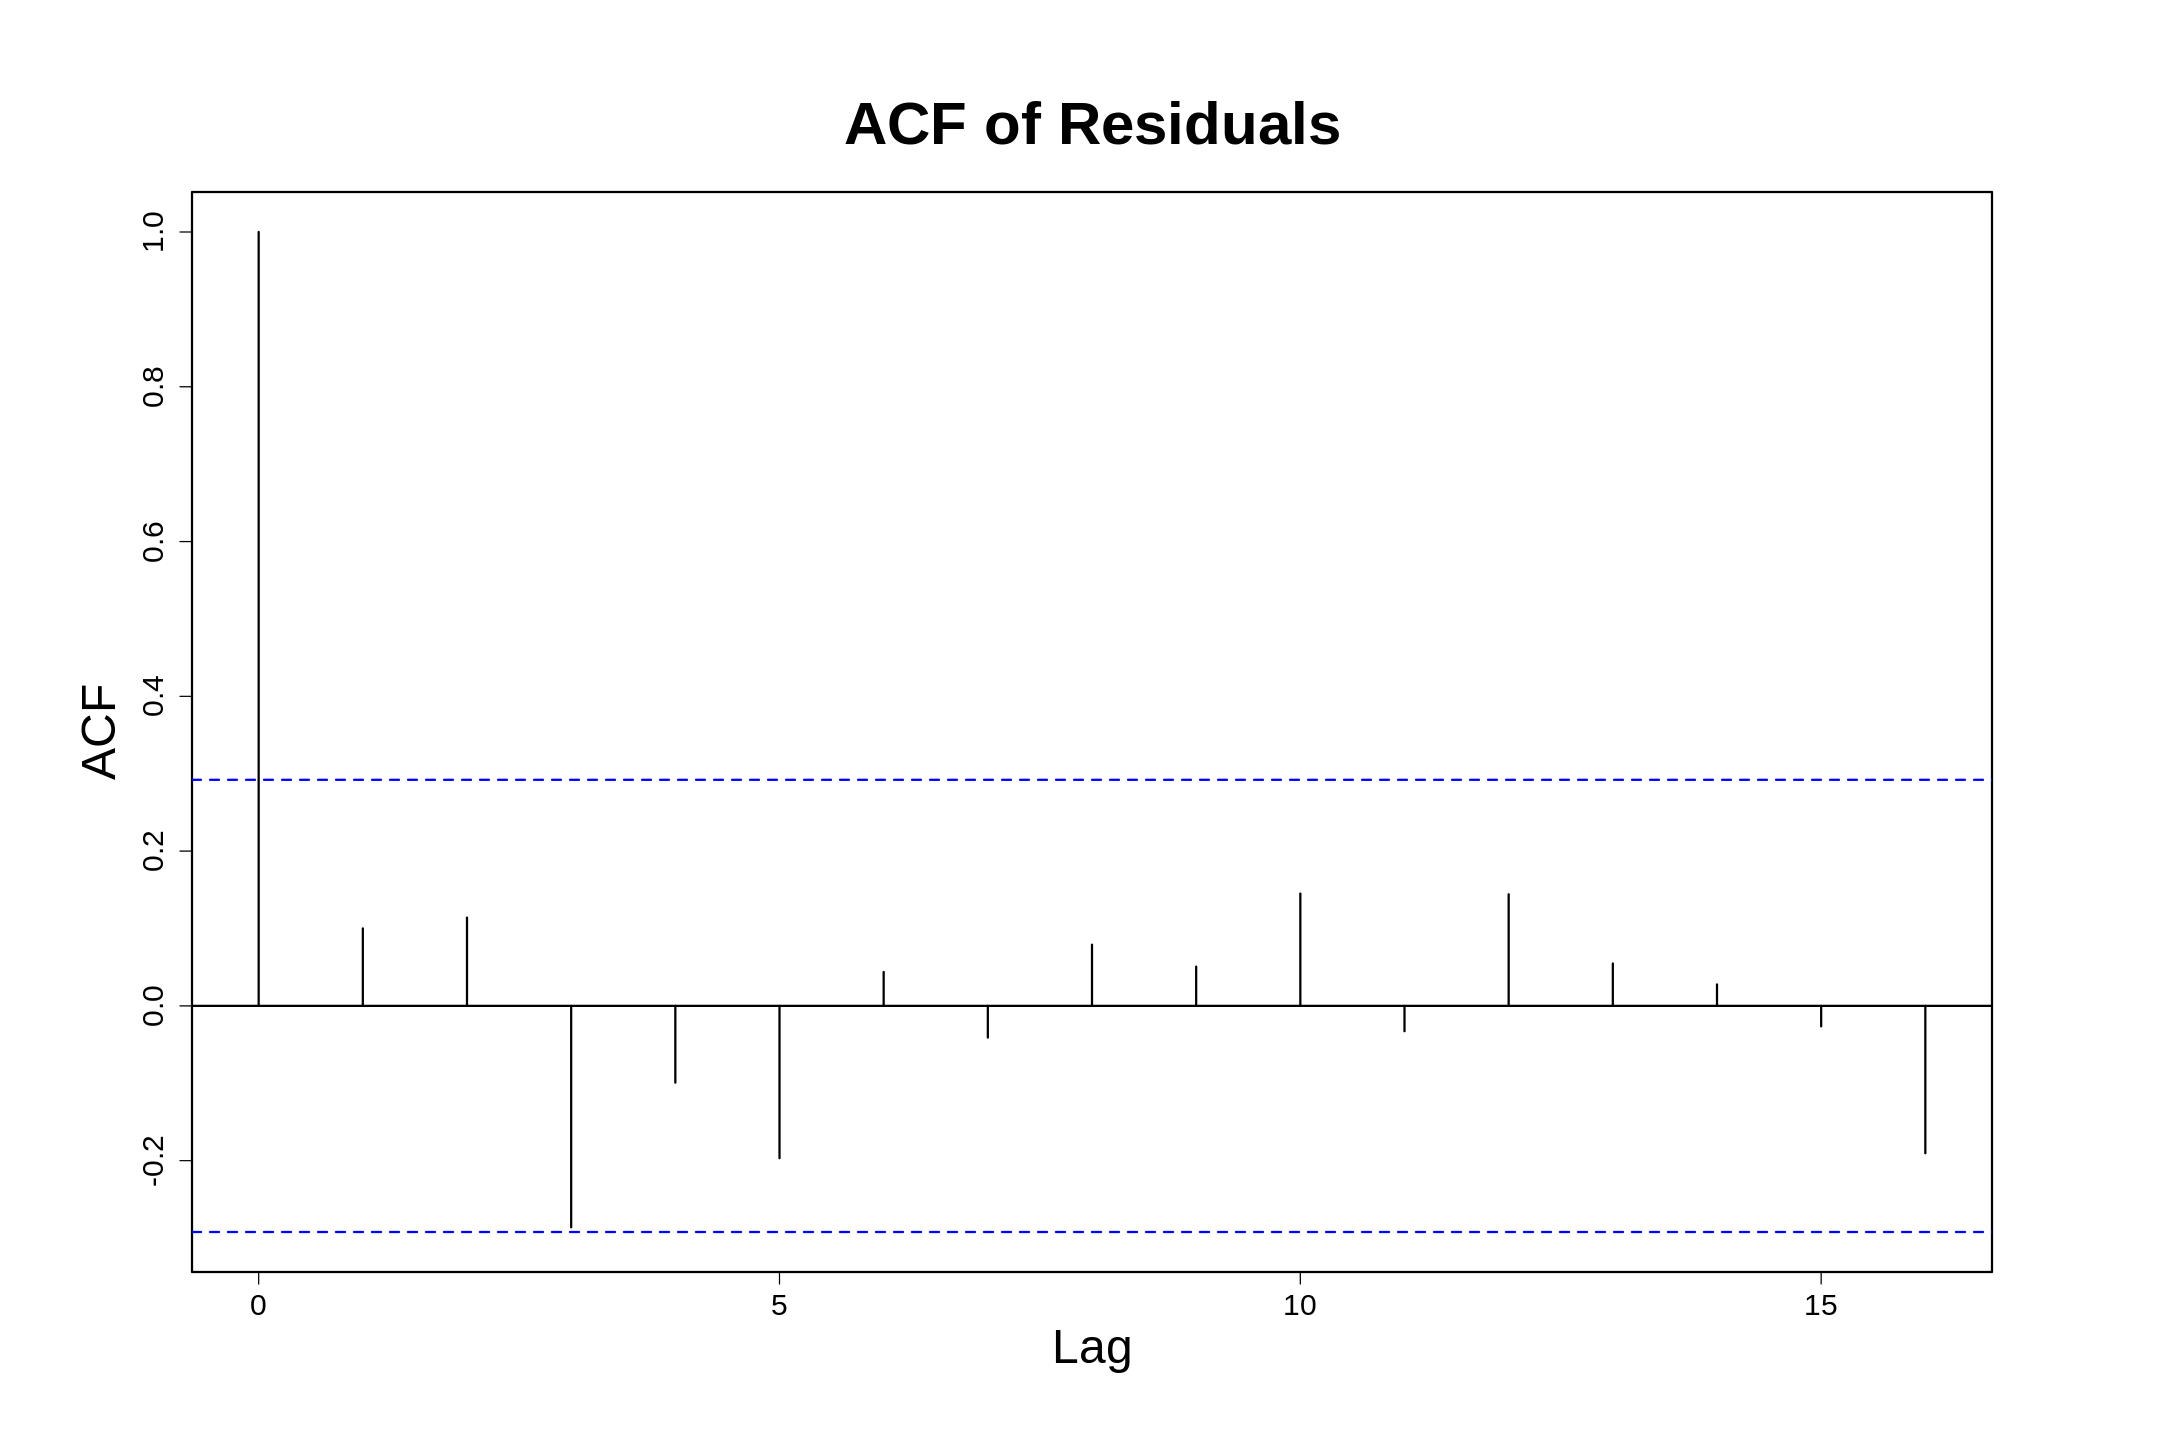

In [61]:
fplot(acf, residuals, main="ACF of Residuals")

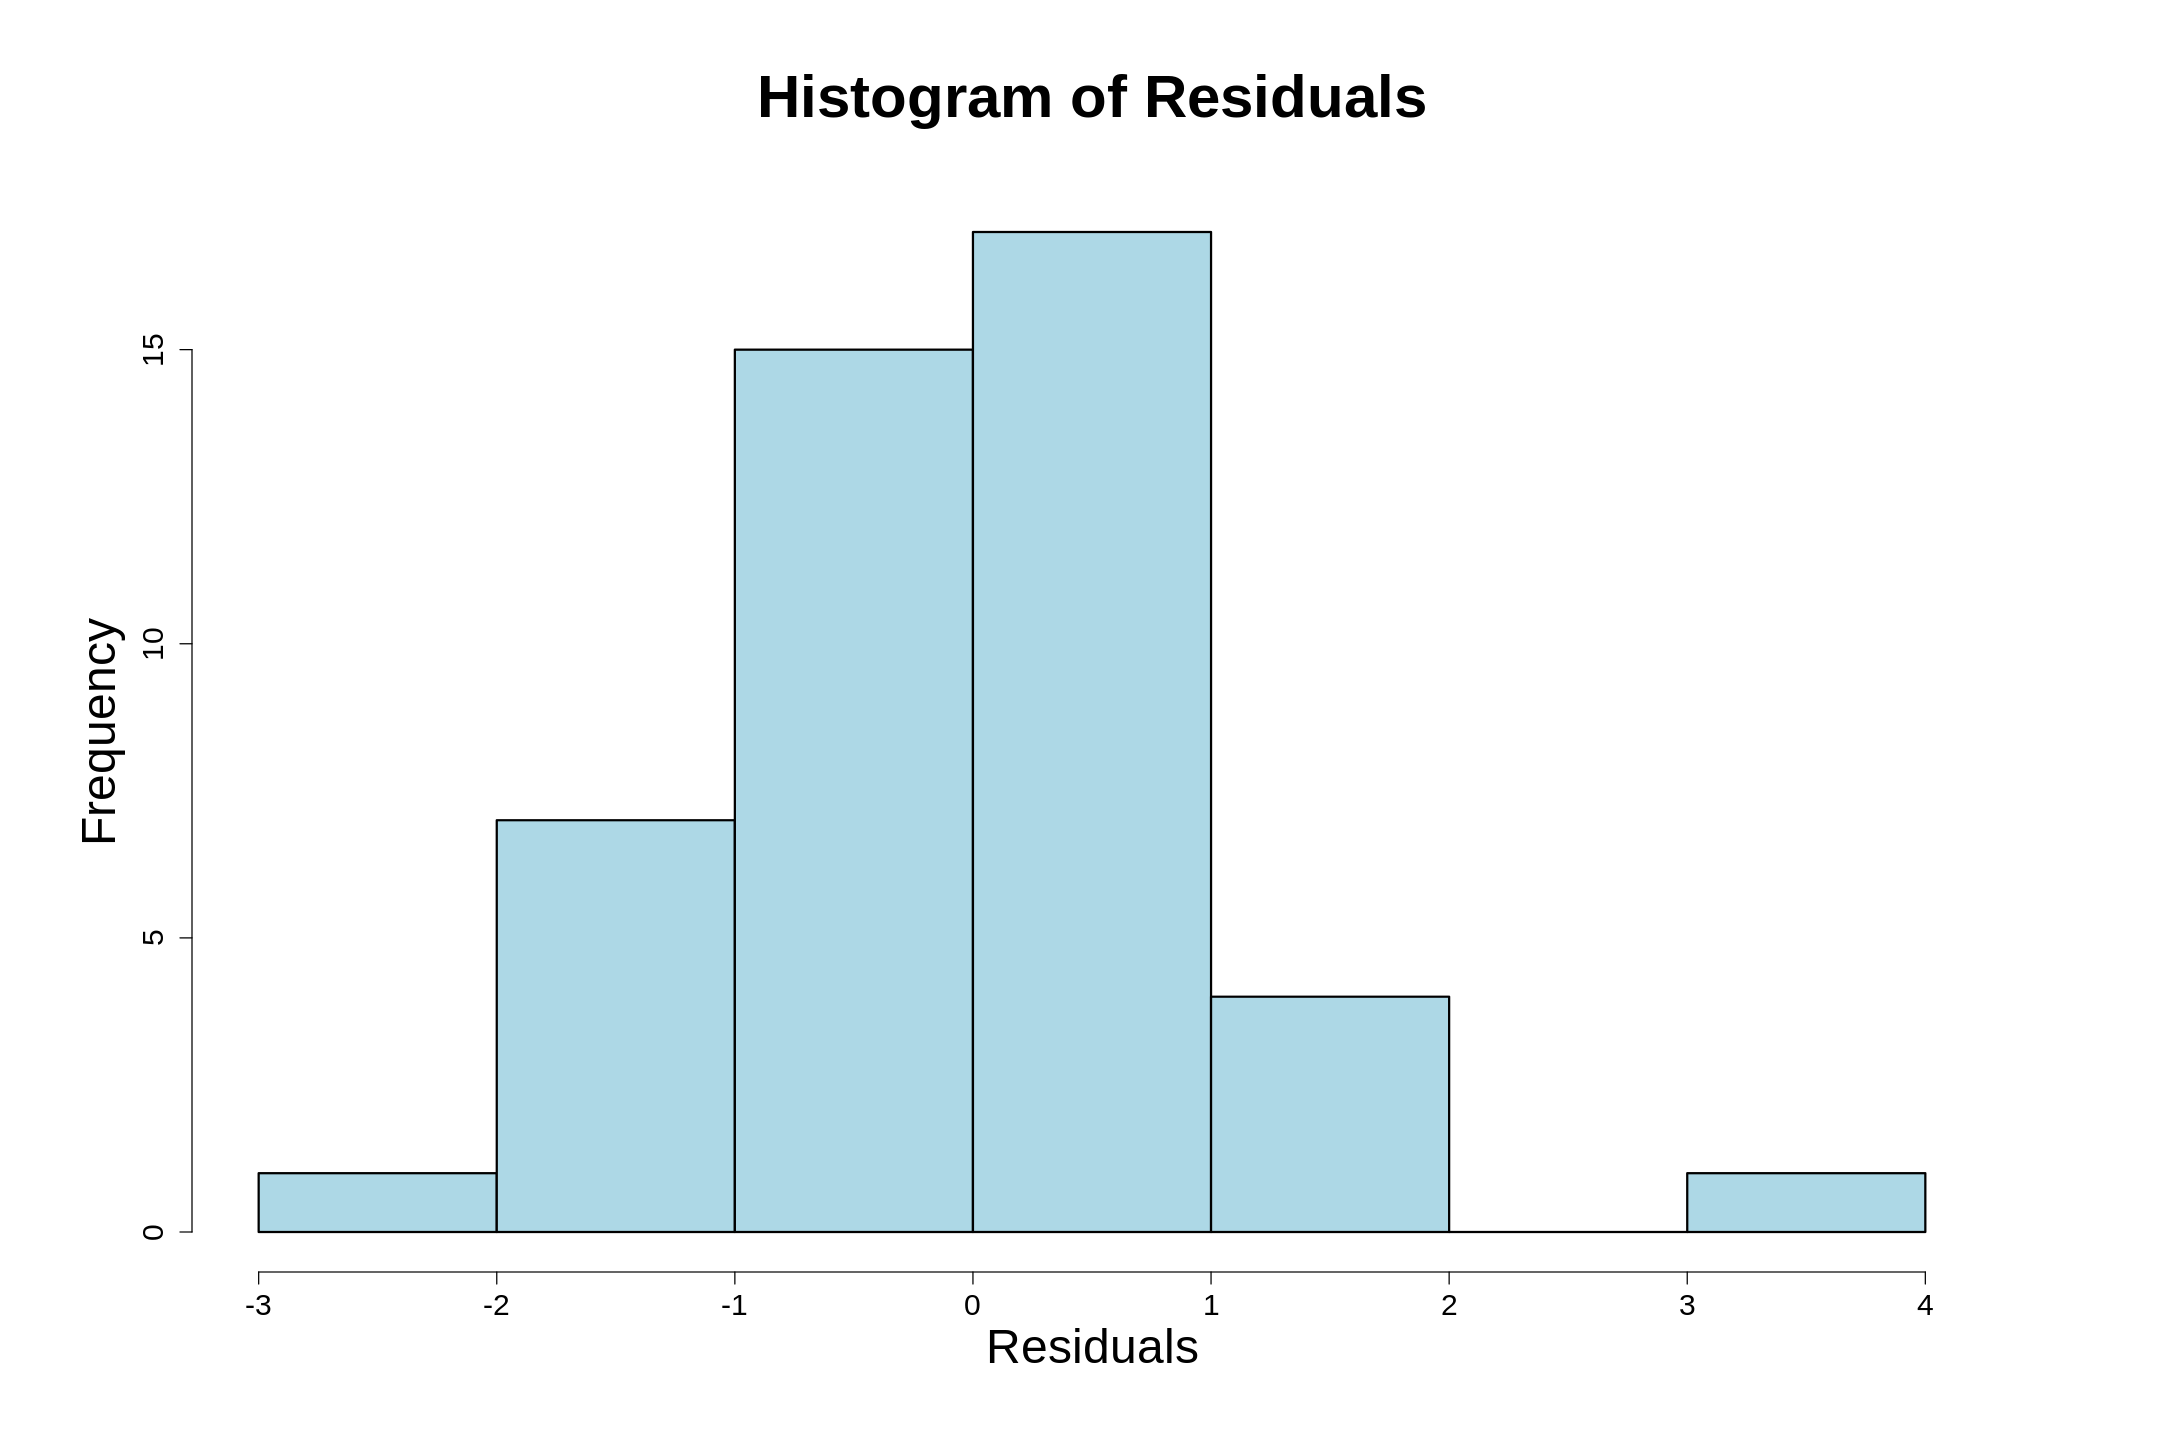

In [62]:
fplot(hist, residuals, main="Histogram of Residuals", xlab="Residuals", col="lightblue")

In [63]:
shapiro.test(residuals)
Box.test(residuals, lag=20, type="Ljung-Box")


	Shapiro-Wilk normality test

data:  residuals
W = 0.94687, p-value = 0.0387



	Box-Ljung test

data:  residuals
X-squared = 16.819, df = 20, p-value = 0.6647


In [64]:
model5 <- auto.arima(tsbcddf)
summary(model5)

Series: tsbcddf 
ARIMA(1,0,2) with zero mean 

Coefficients:
          ar1      ma1      ma2
      -0.8587  -0.2541  -0.4827
s.e.   0.1233   0.2054   0.2038

sigma^2 = 1.053:  log likelihood = -64.39
AIC=136.77   AICc=137.77   BIC=144

Training set error measures:
                    ME      RMSE       MAE      MPE     MAPE      MASE
Training set 0.0293385 0.9913646 0.7563312 -42.3679 137.4805 0.2915129
                   ACF1
Training set 0.02285567

In [65]:
residuals <- residuals(model5)
shapiro.test(residuals)
Box.test(residuals, lag=20, type="Ljung-Box")


	Shapiro-Wilk normality test

data:  residuals
W = 0.94649, p-value = 0.03746



	Box-Ljung test

data:  residuals
X-squared = 12.714, df = 20, p-value = 0.8893


model returned from auto.arima function is ARIMA(1,0,2), despite that residuals are not normal (according to Shapiro-Wilk test)


# Task 2 🐕 Woof

### Data input 🦒

In [66]:
TBGK <- read.csv(file="/content/dane_TBGK3.csv")

In [67]:
TBGK <- ts(TBGK["Sales"],start=c(2001,1),frequency=12)

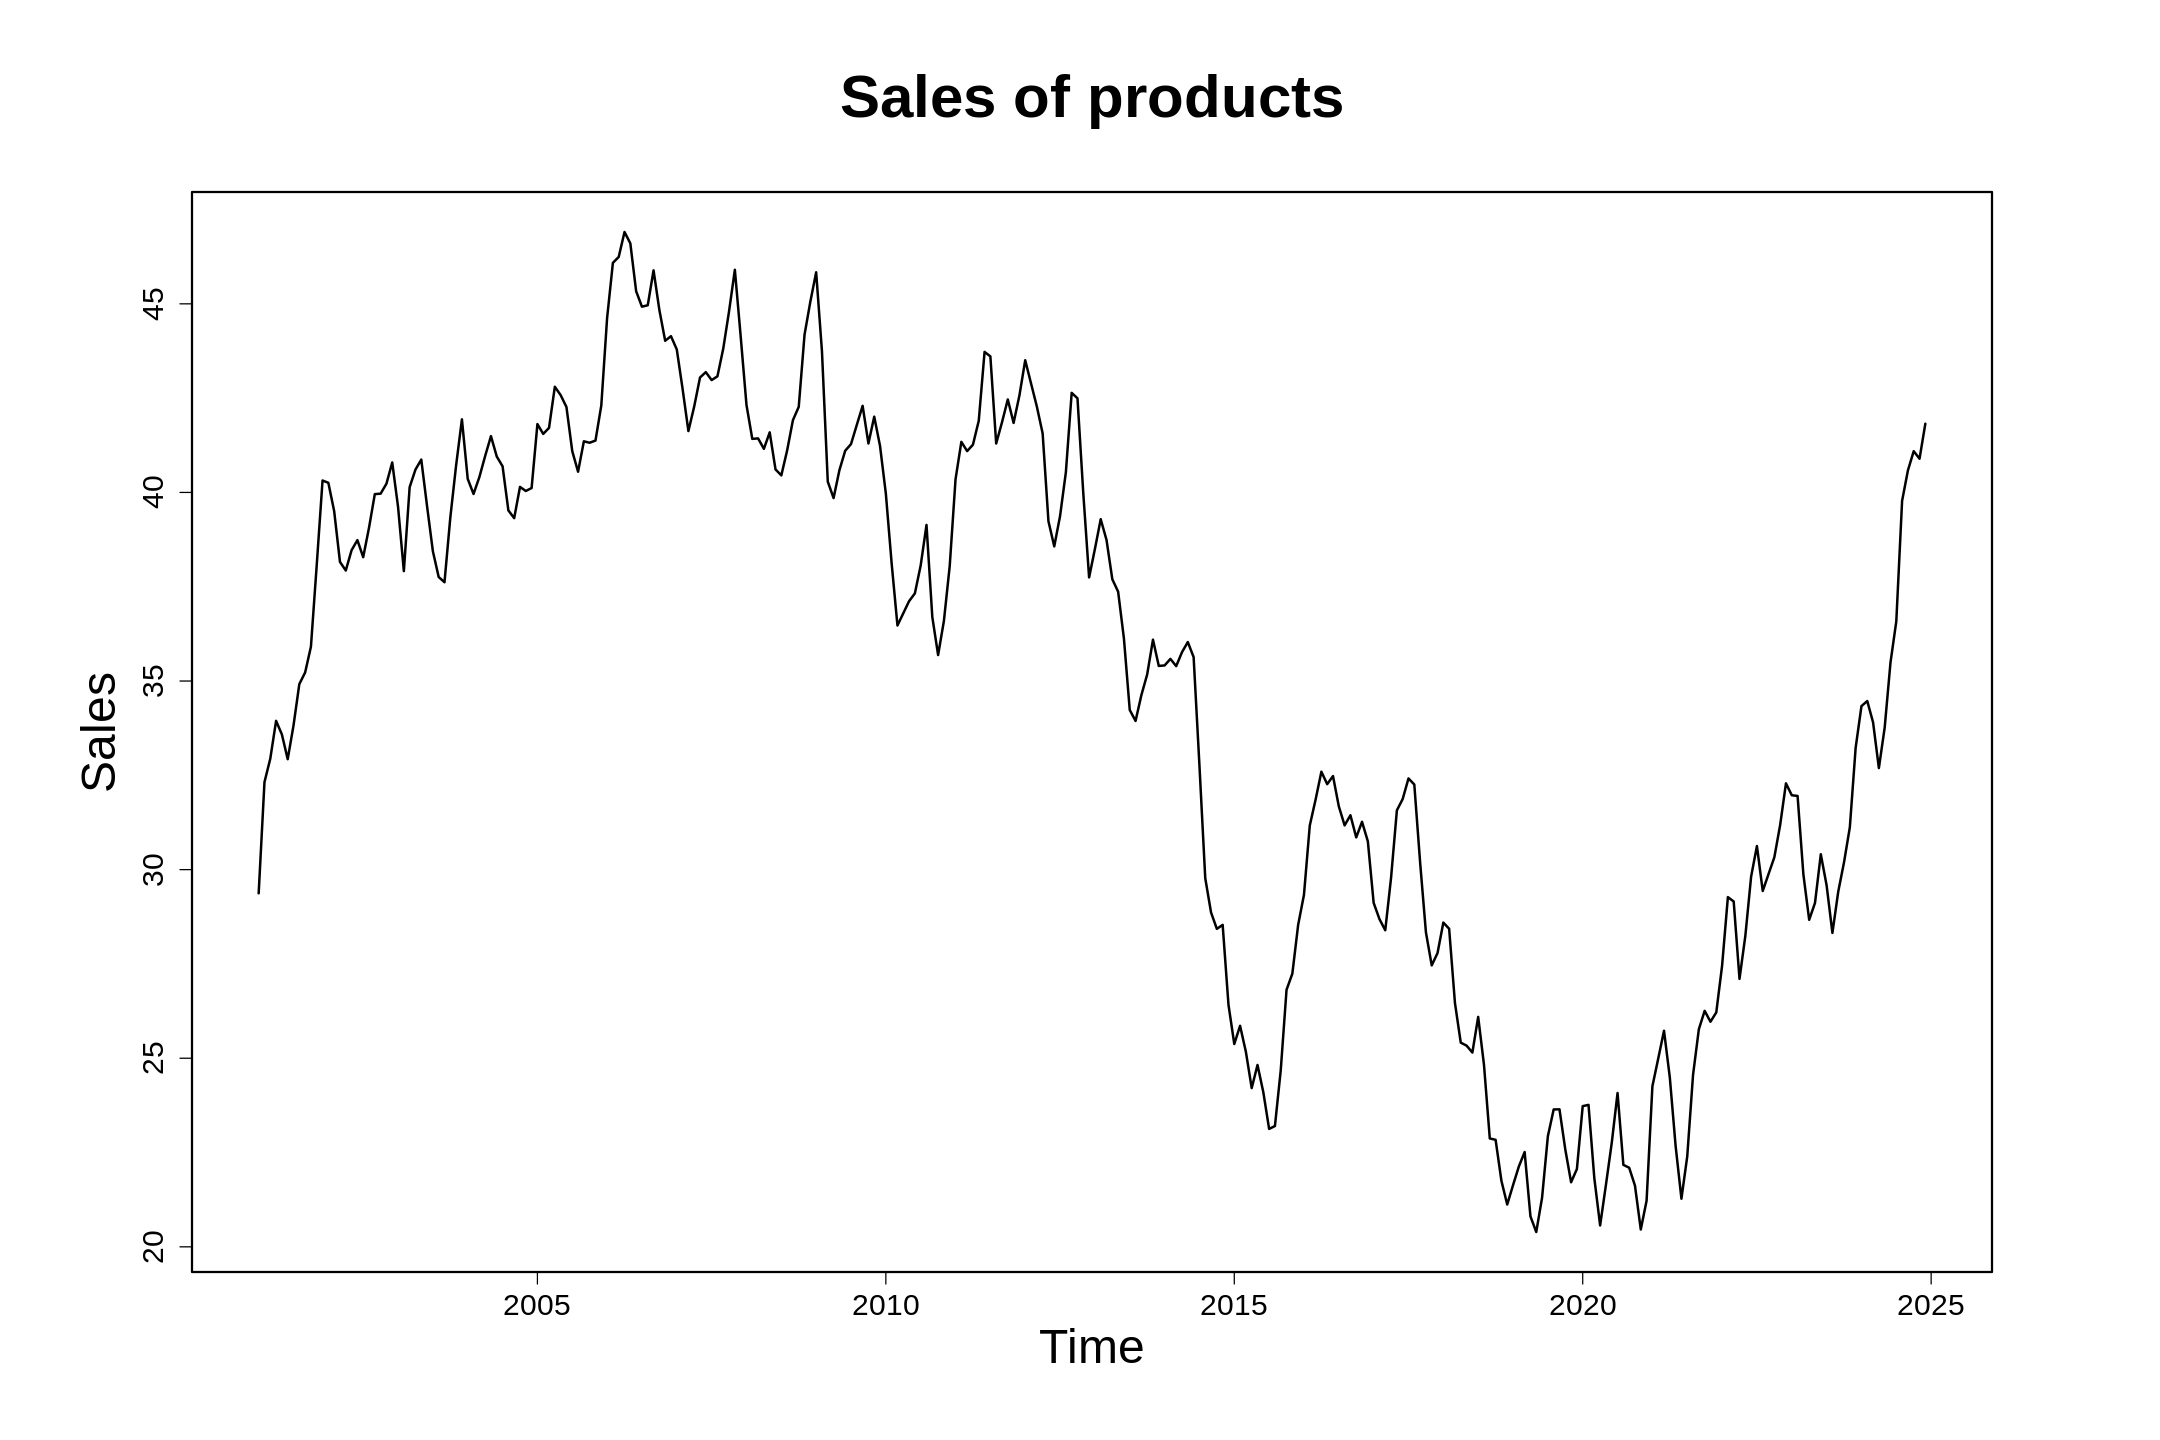

In [68]:
fplot(plot, TBGK, main = "Sales of products", lwd=2.)

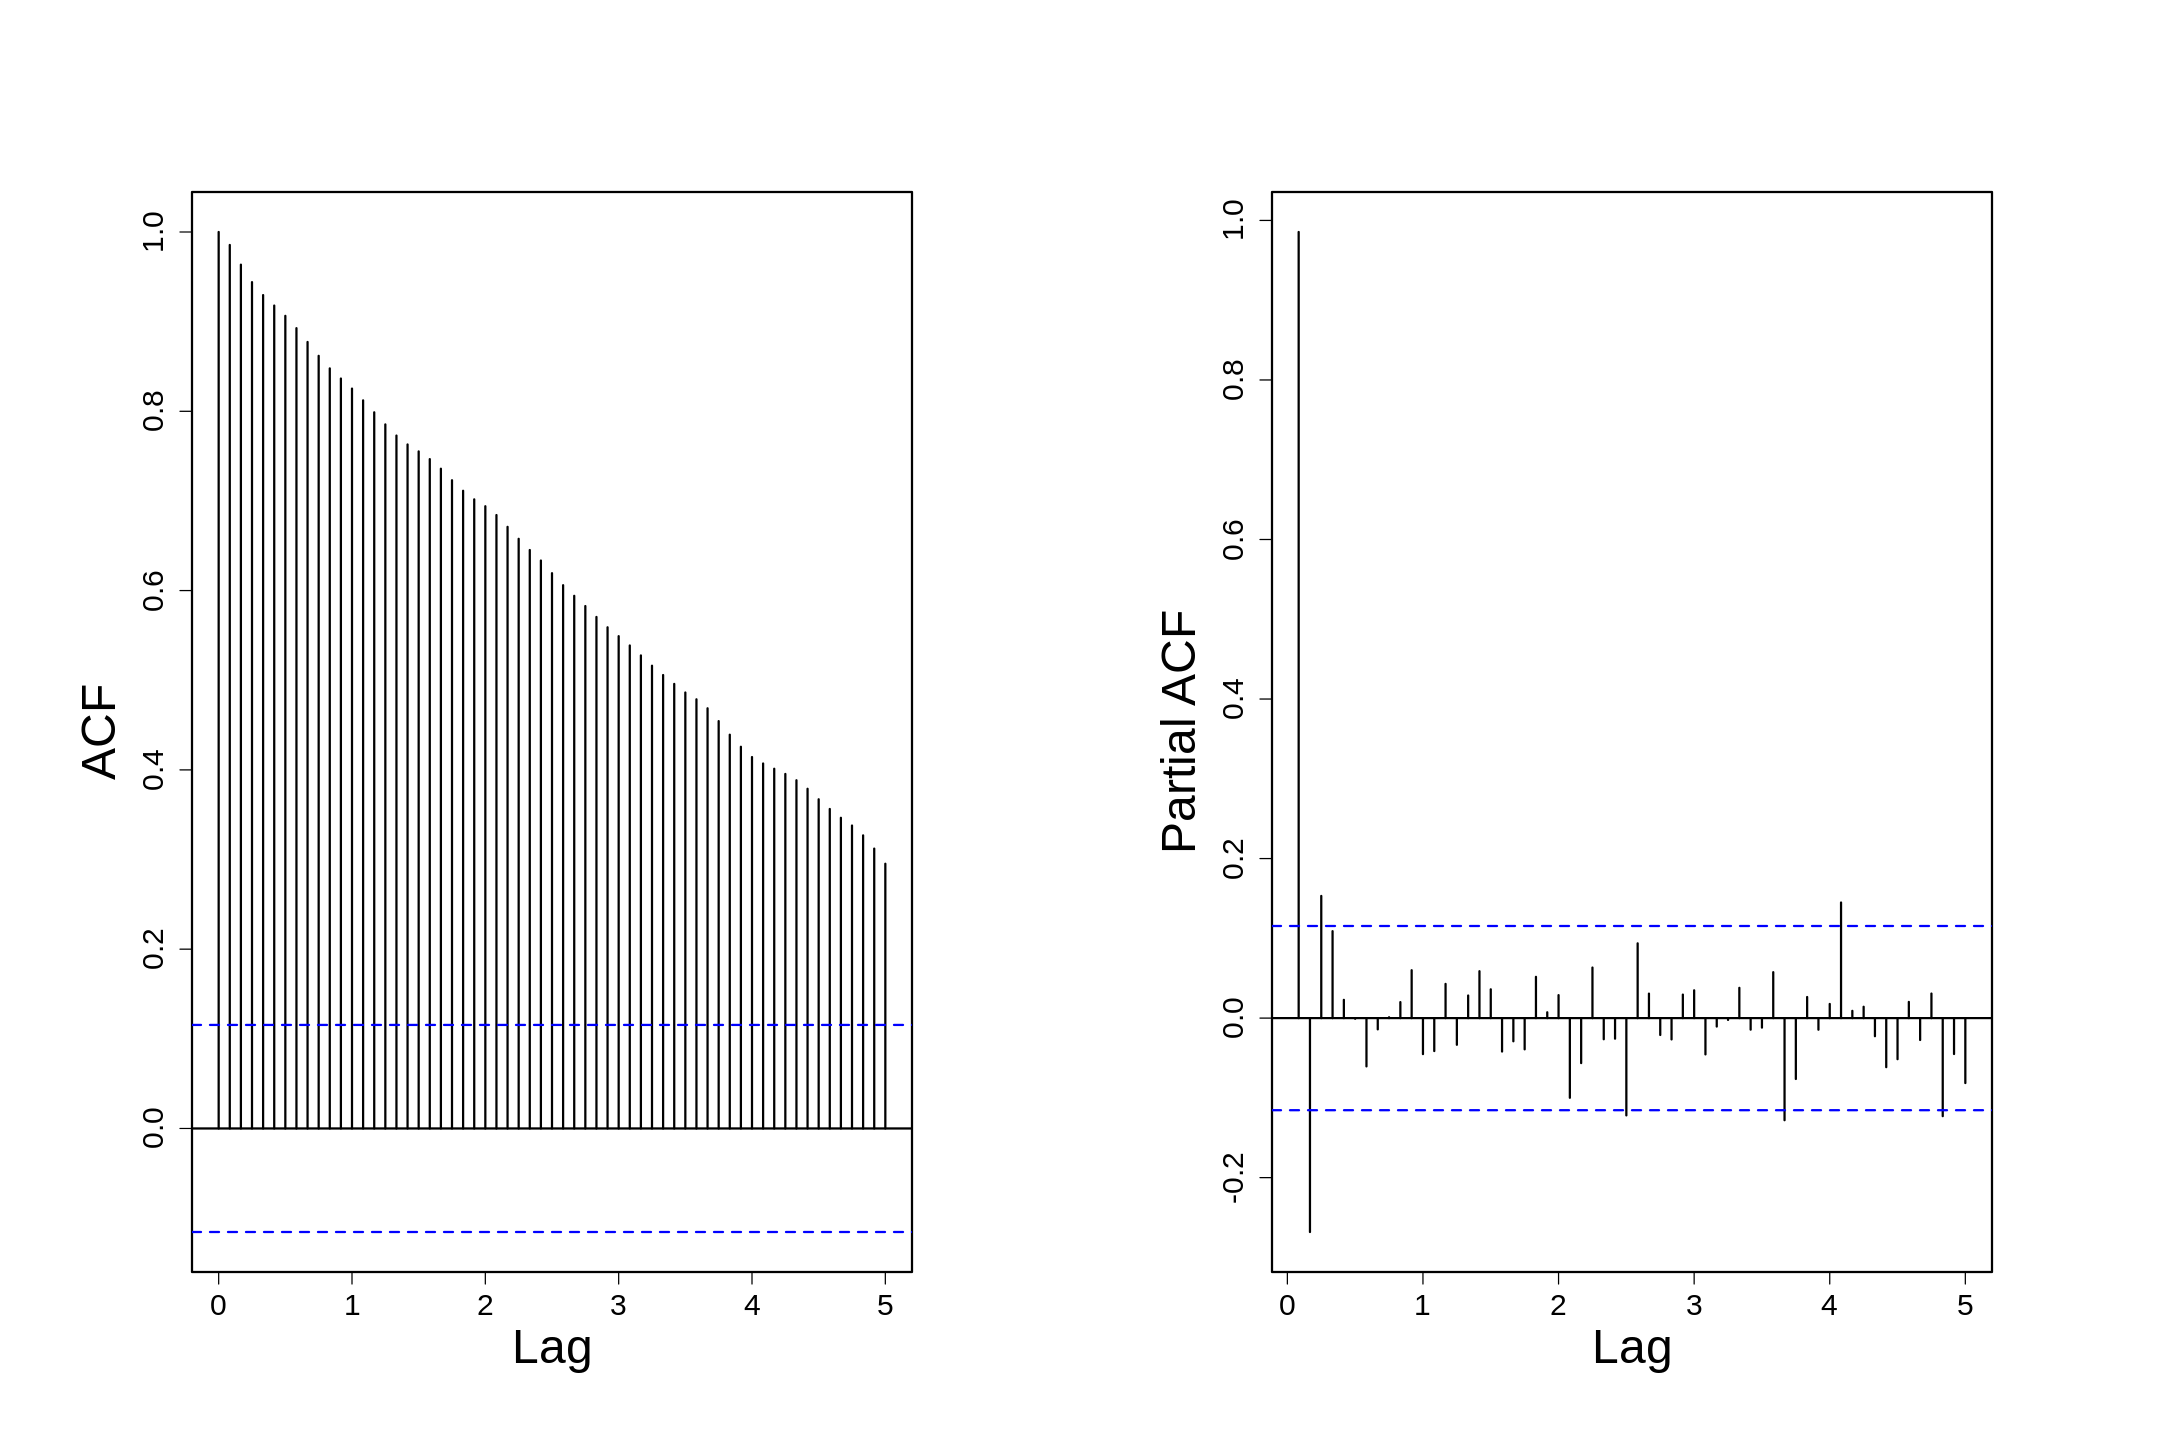

In [69]:
par(mfrow=c(1,2))
fplot(acf, TBGK,  main=" ",lag.max=60, ci=.95)
fplot(pacf, TBGK, main=" ",lag.max=60, ci=.95)

## Spectral density estimators 🦥

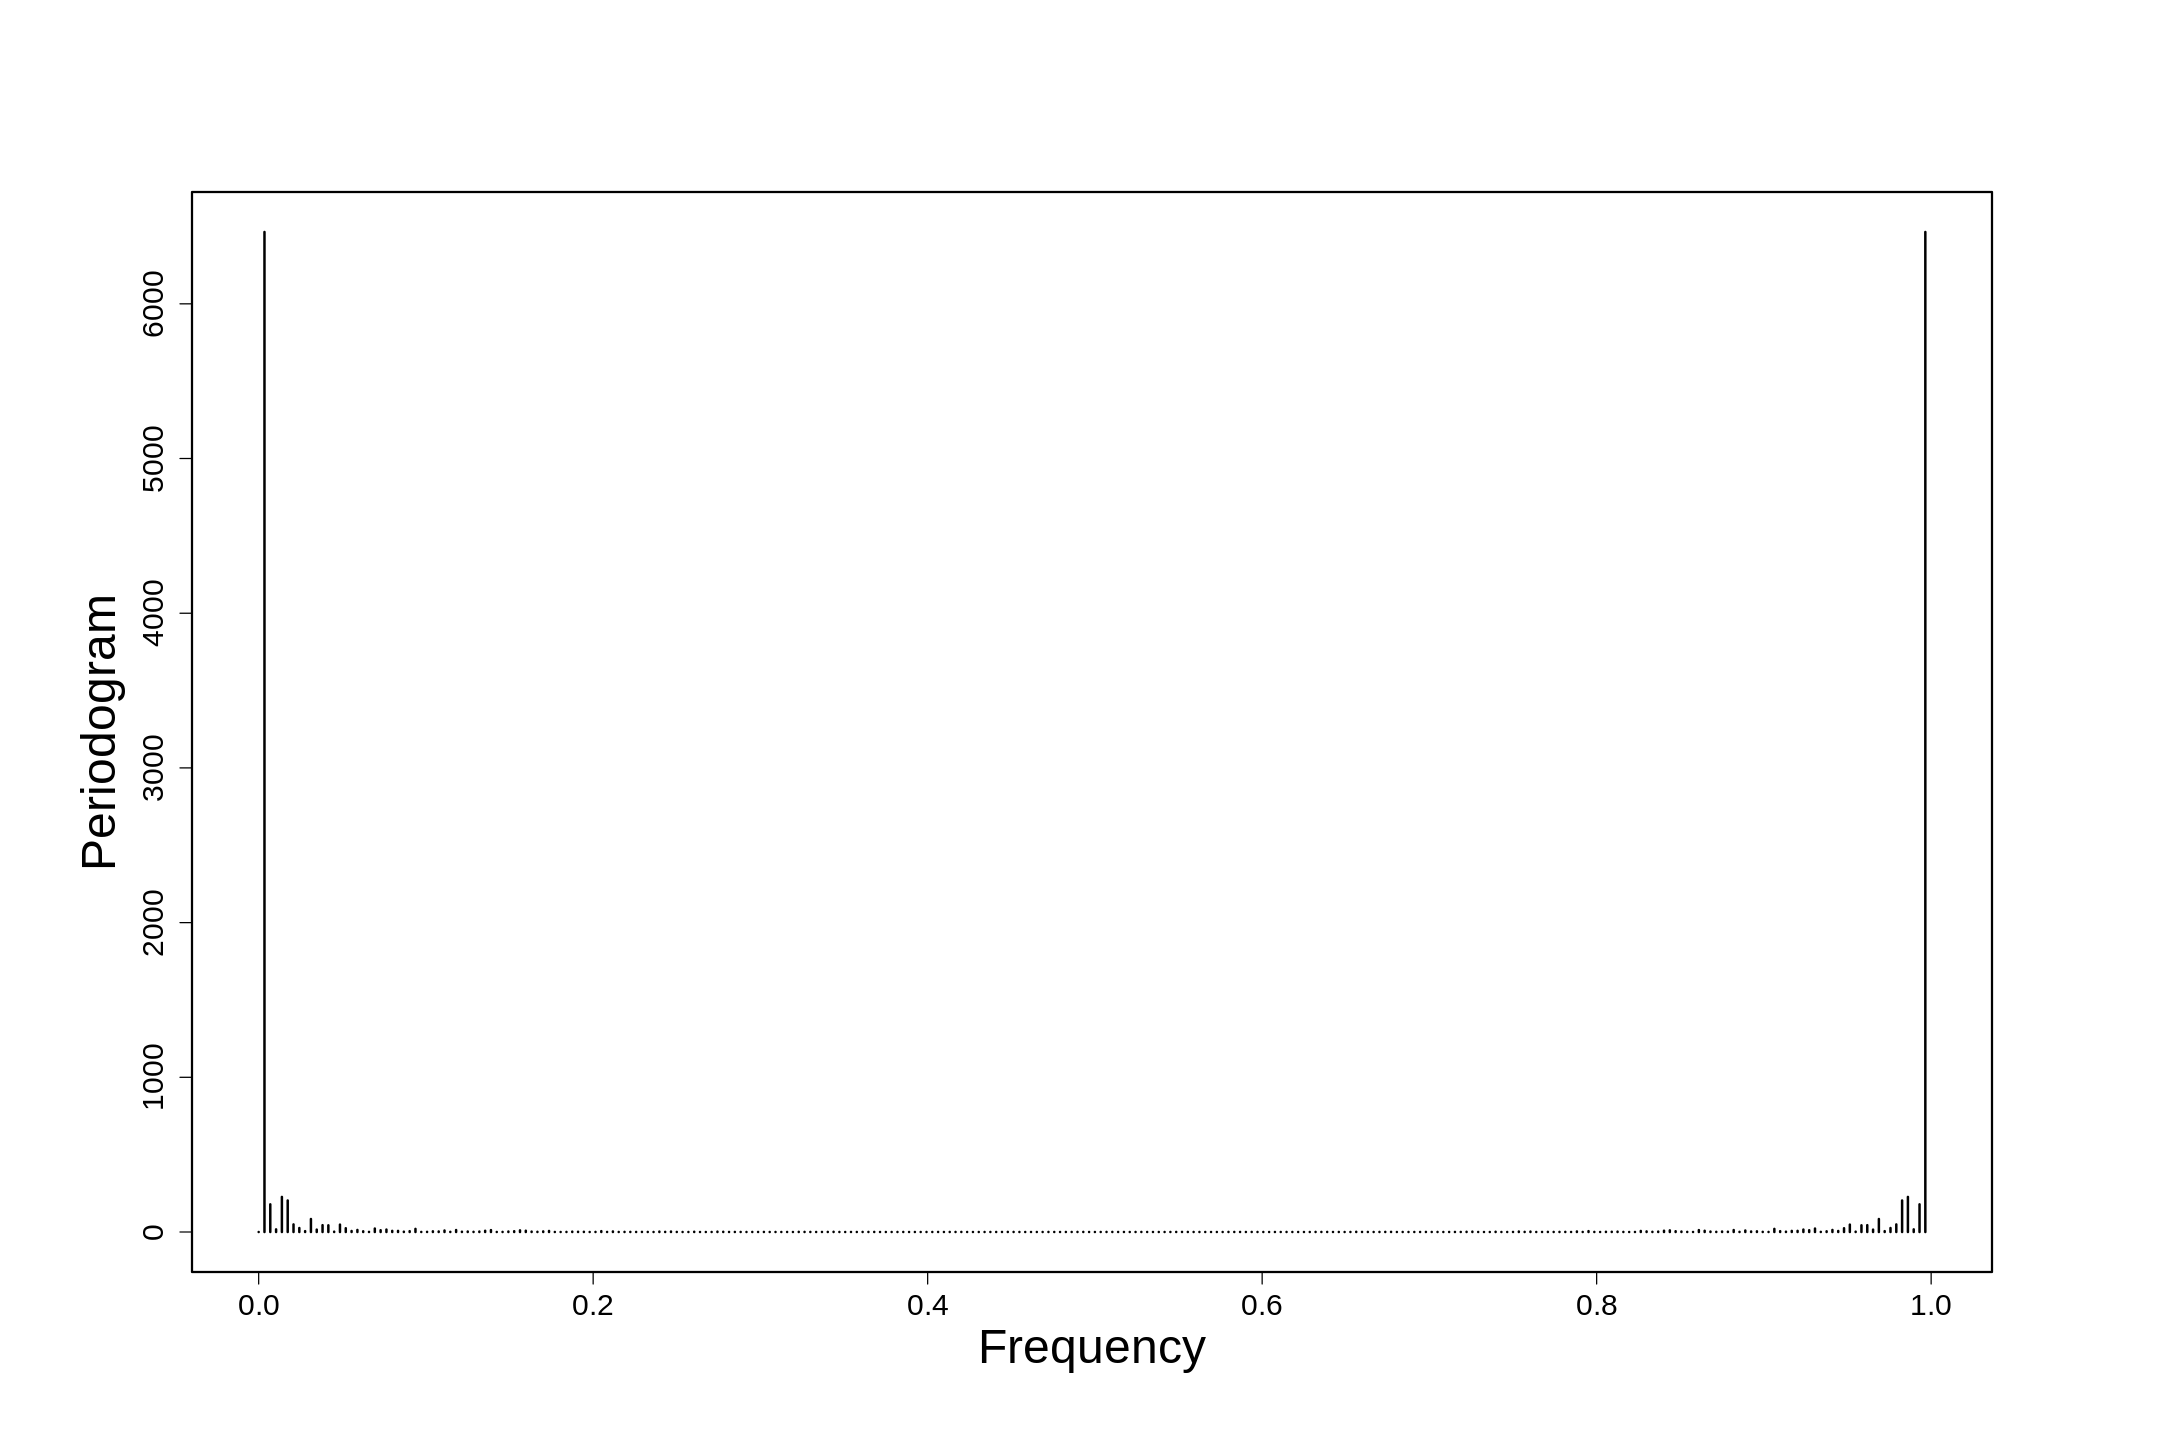

In [70]:
n = length(TBGK)
Per= Mod(fft(TBGK-mean(TBGK)))^2/n
Freq = (1:n -1)/n
fplot(plot, Freq[1:n], Per[1:n], type='h', lwd=2, ylab="Periodogram", xlab="Frequency")

We want to know for which frequency. We use function which.max.

In [71]:
nn=n/2

u = which.max(Per[1:nn])
uu = which.max(Per[1:nn][-u])
1/Freq[u]

[1] 288

288 months = 24 years

In [72]:
1/Freq[uu]

[1] 96

8 years

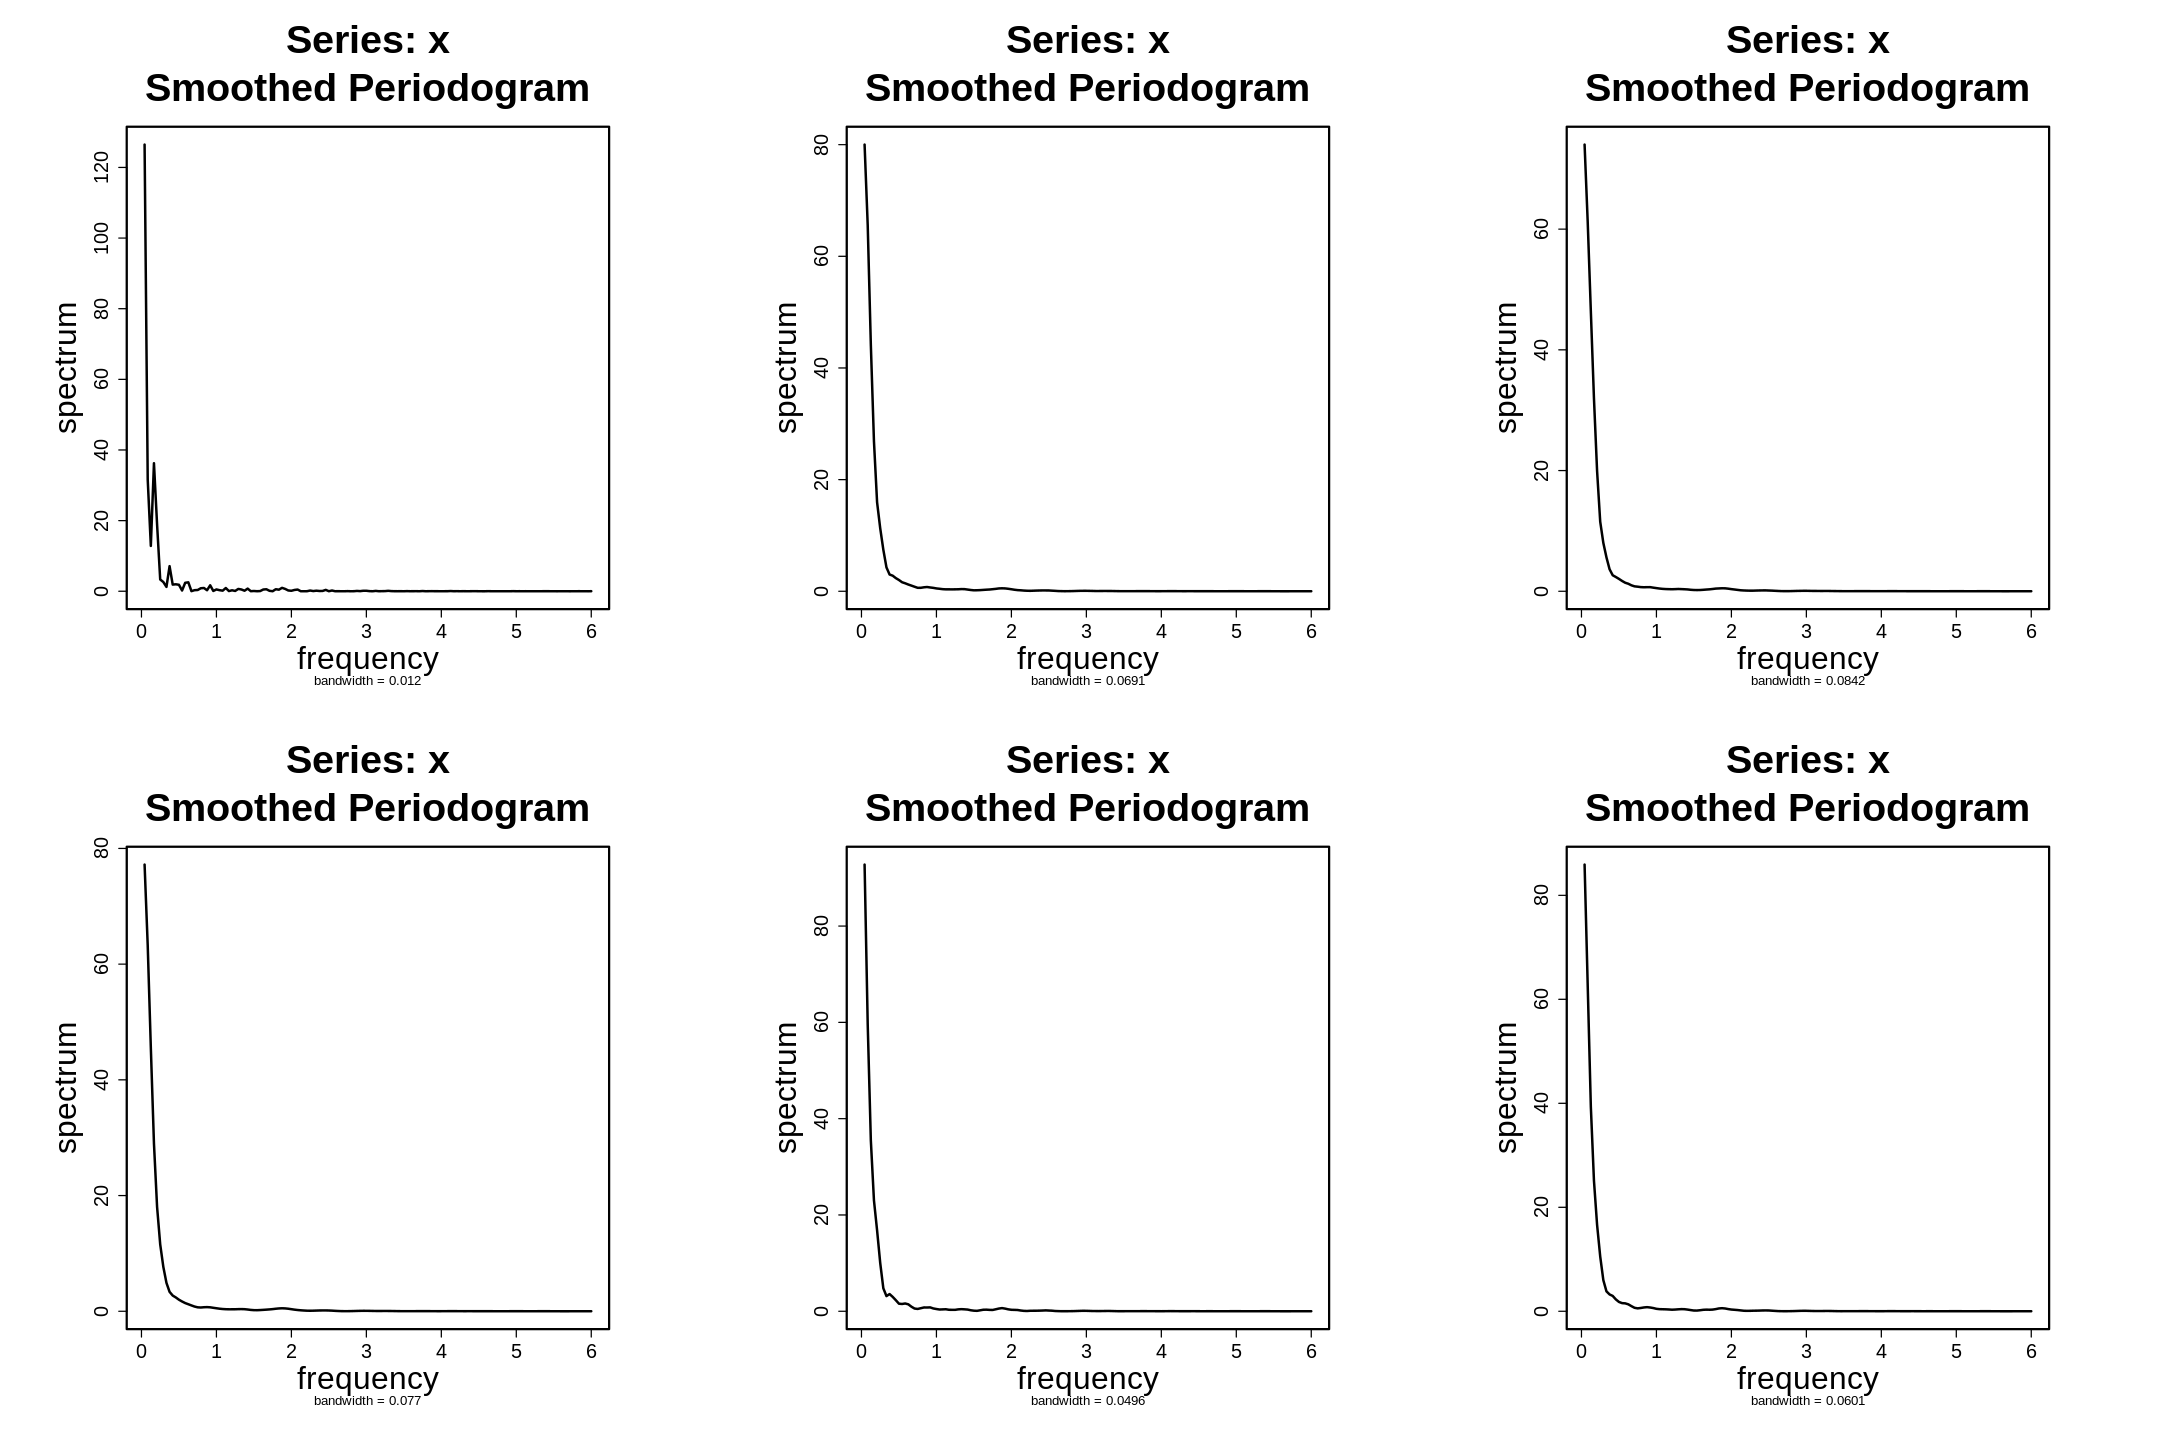

In [73]:
par(mfrow = c(2, 3))

kernels <- list(
    c(0,0,0),
    c(2,1,0),
    c(2,2,0),
    c(2,1,1),
    c(1,1,0),
    c(1,1,1)
)
for (ker in kernels) {
    fplot(spectrum, TBGK-mean(TBGK), kernel=kernel("daniell", ker),log="no", lwd=2.)
}

Examining plots we can clearly see that all estimated spectral densities exhibit striking resemblance.

Bandwidth: 0.253 | Degrees of Freedom: 12.16 | split taper: 0% 
Bandwidth: 0.306 | Degrees of Freedom: 14.71 | split taper: 0% 
Bandwidth: 0.28 | Degrees of Freedom: 13.46 | split taper: 0% 
Bandwidth: 0.178 | Degrees of Freedom: 8.53 | split taper: 0% 
Bandwidth: 0.215 | Degrees of Freedom: 10.34 | split taper: 0% 


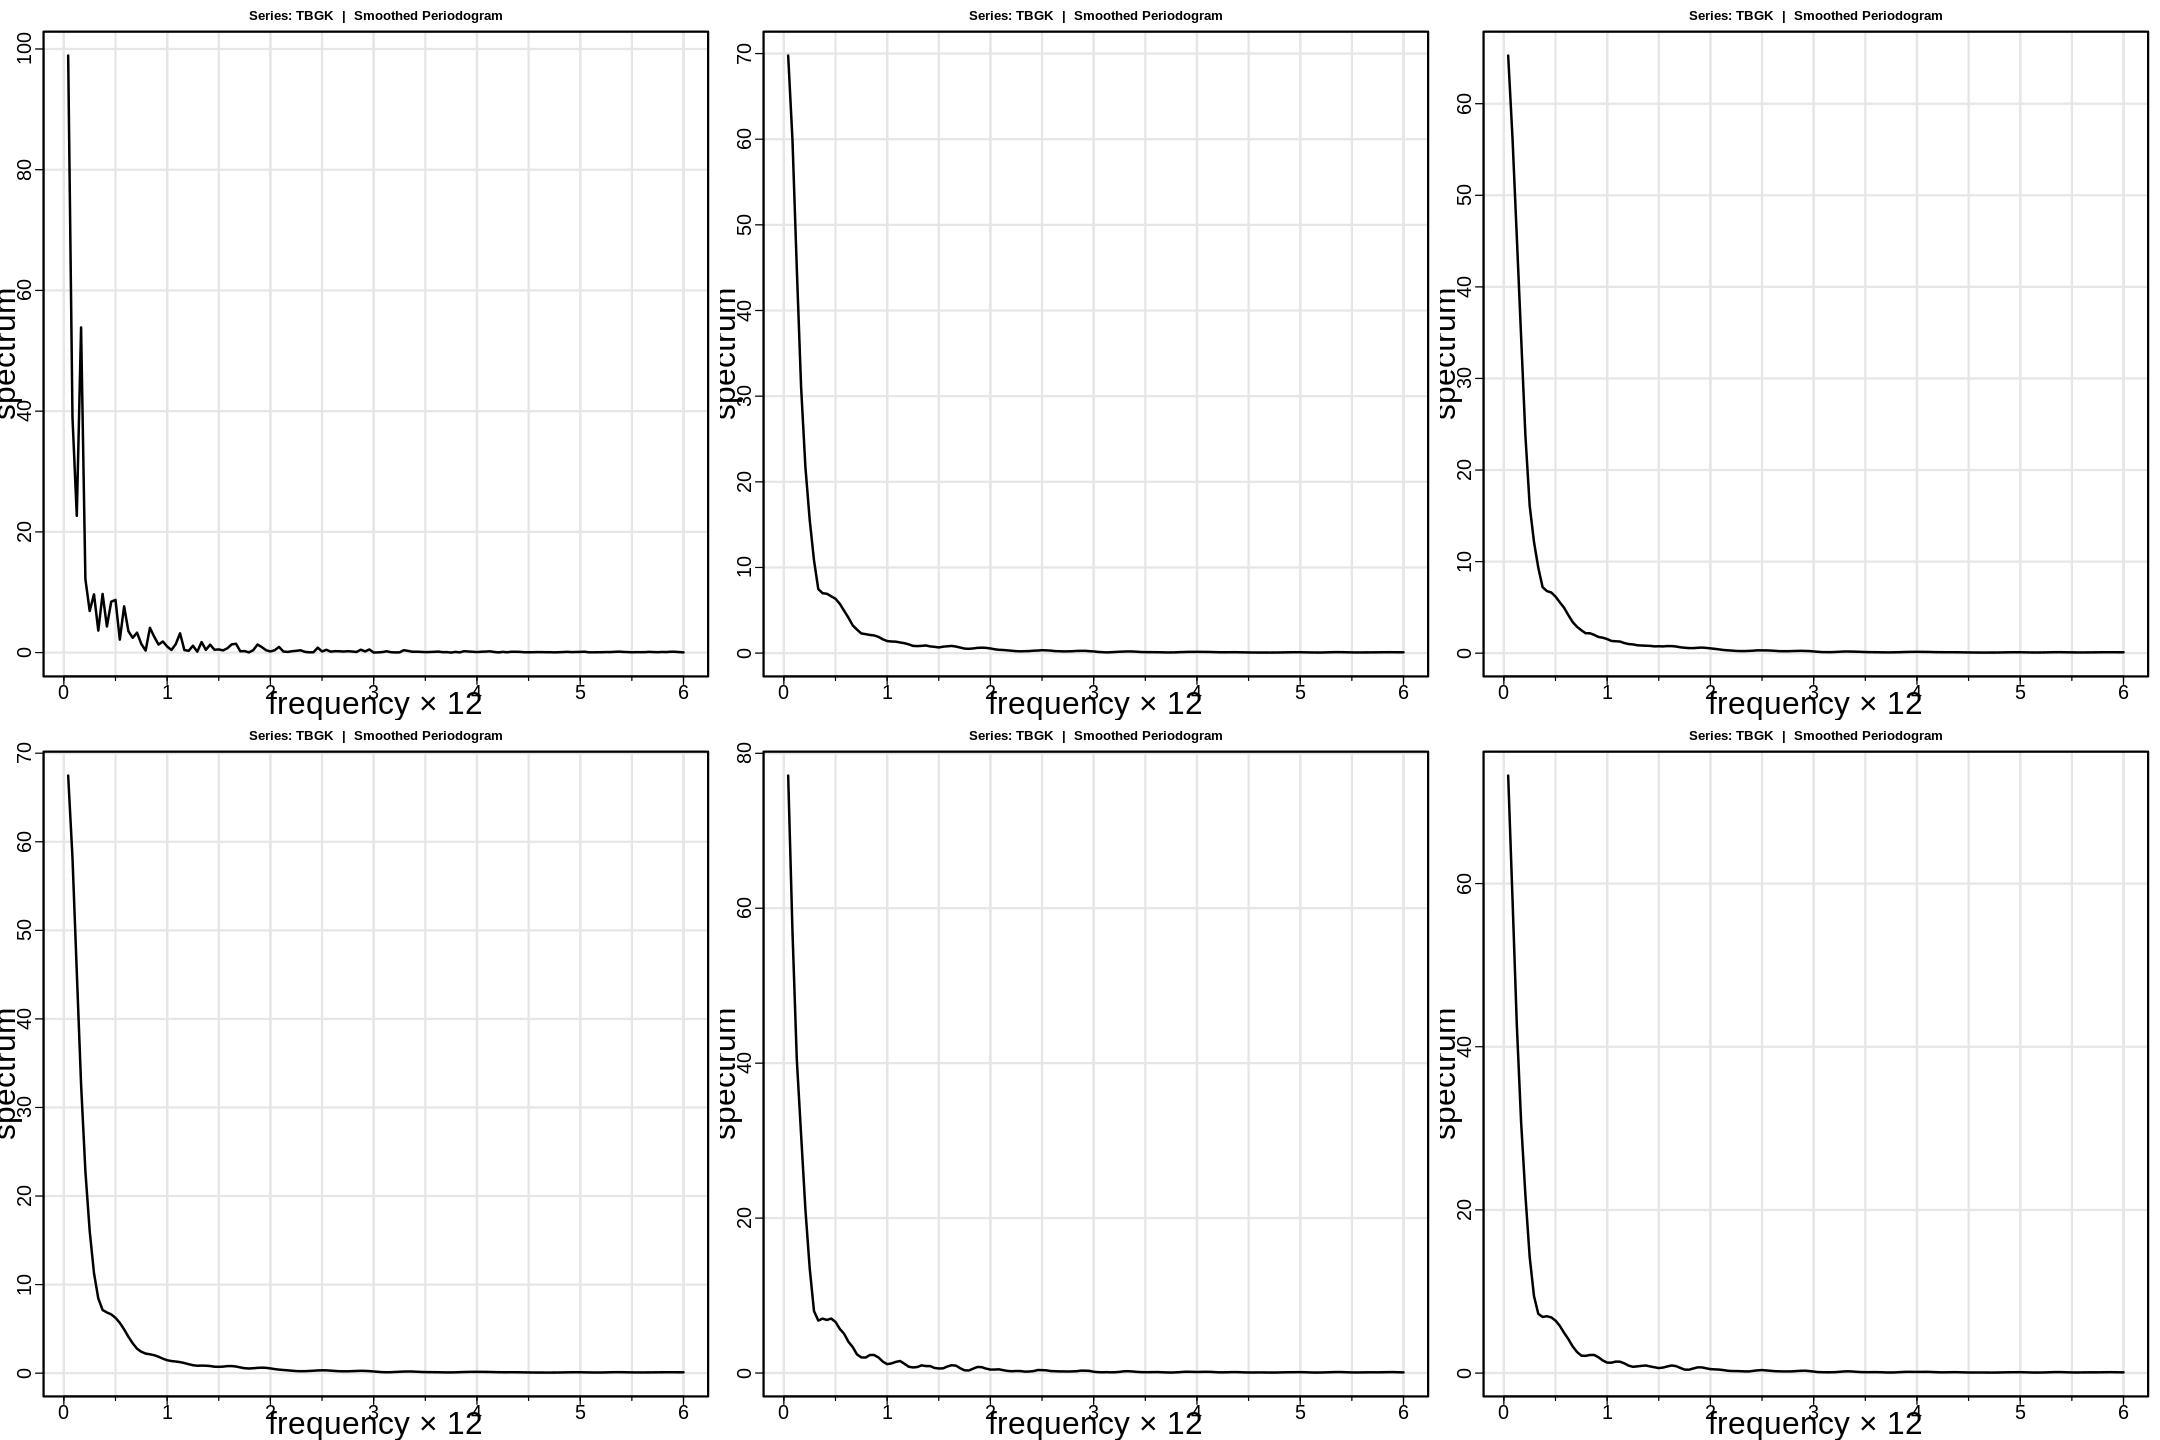

In [74]:
par(mfrow = c(2, 3))

kernels <- list(
    c(0,0,0),
    c(2,1,0),
    c(2,2,0),
    c(2,1,1),
    c(1,1,0),
    c(1,1,1)
)
for (ker in kernels) {
    fplot(mvspec, TBGK, kernel=kernel("daniell", ker), lwd=2.)
}


## Forecasting 🐠

Firstly, we transform the data to non-stationary form.

In [75]:
dTBGK <- diff(TBGK)

In [76]:
adf.test(dTBGK)

Warning message in adf.test(dTBGK):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  dTBGK
Dickey-Fuller = -5.4963, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


Dataset is stationary

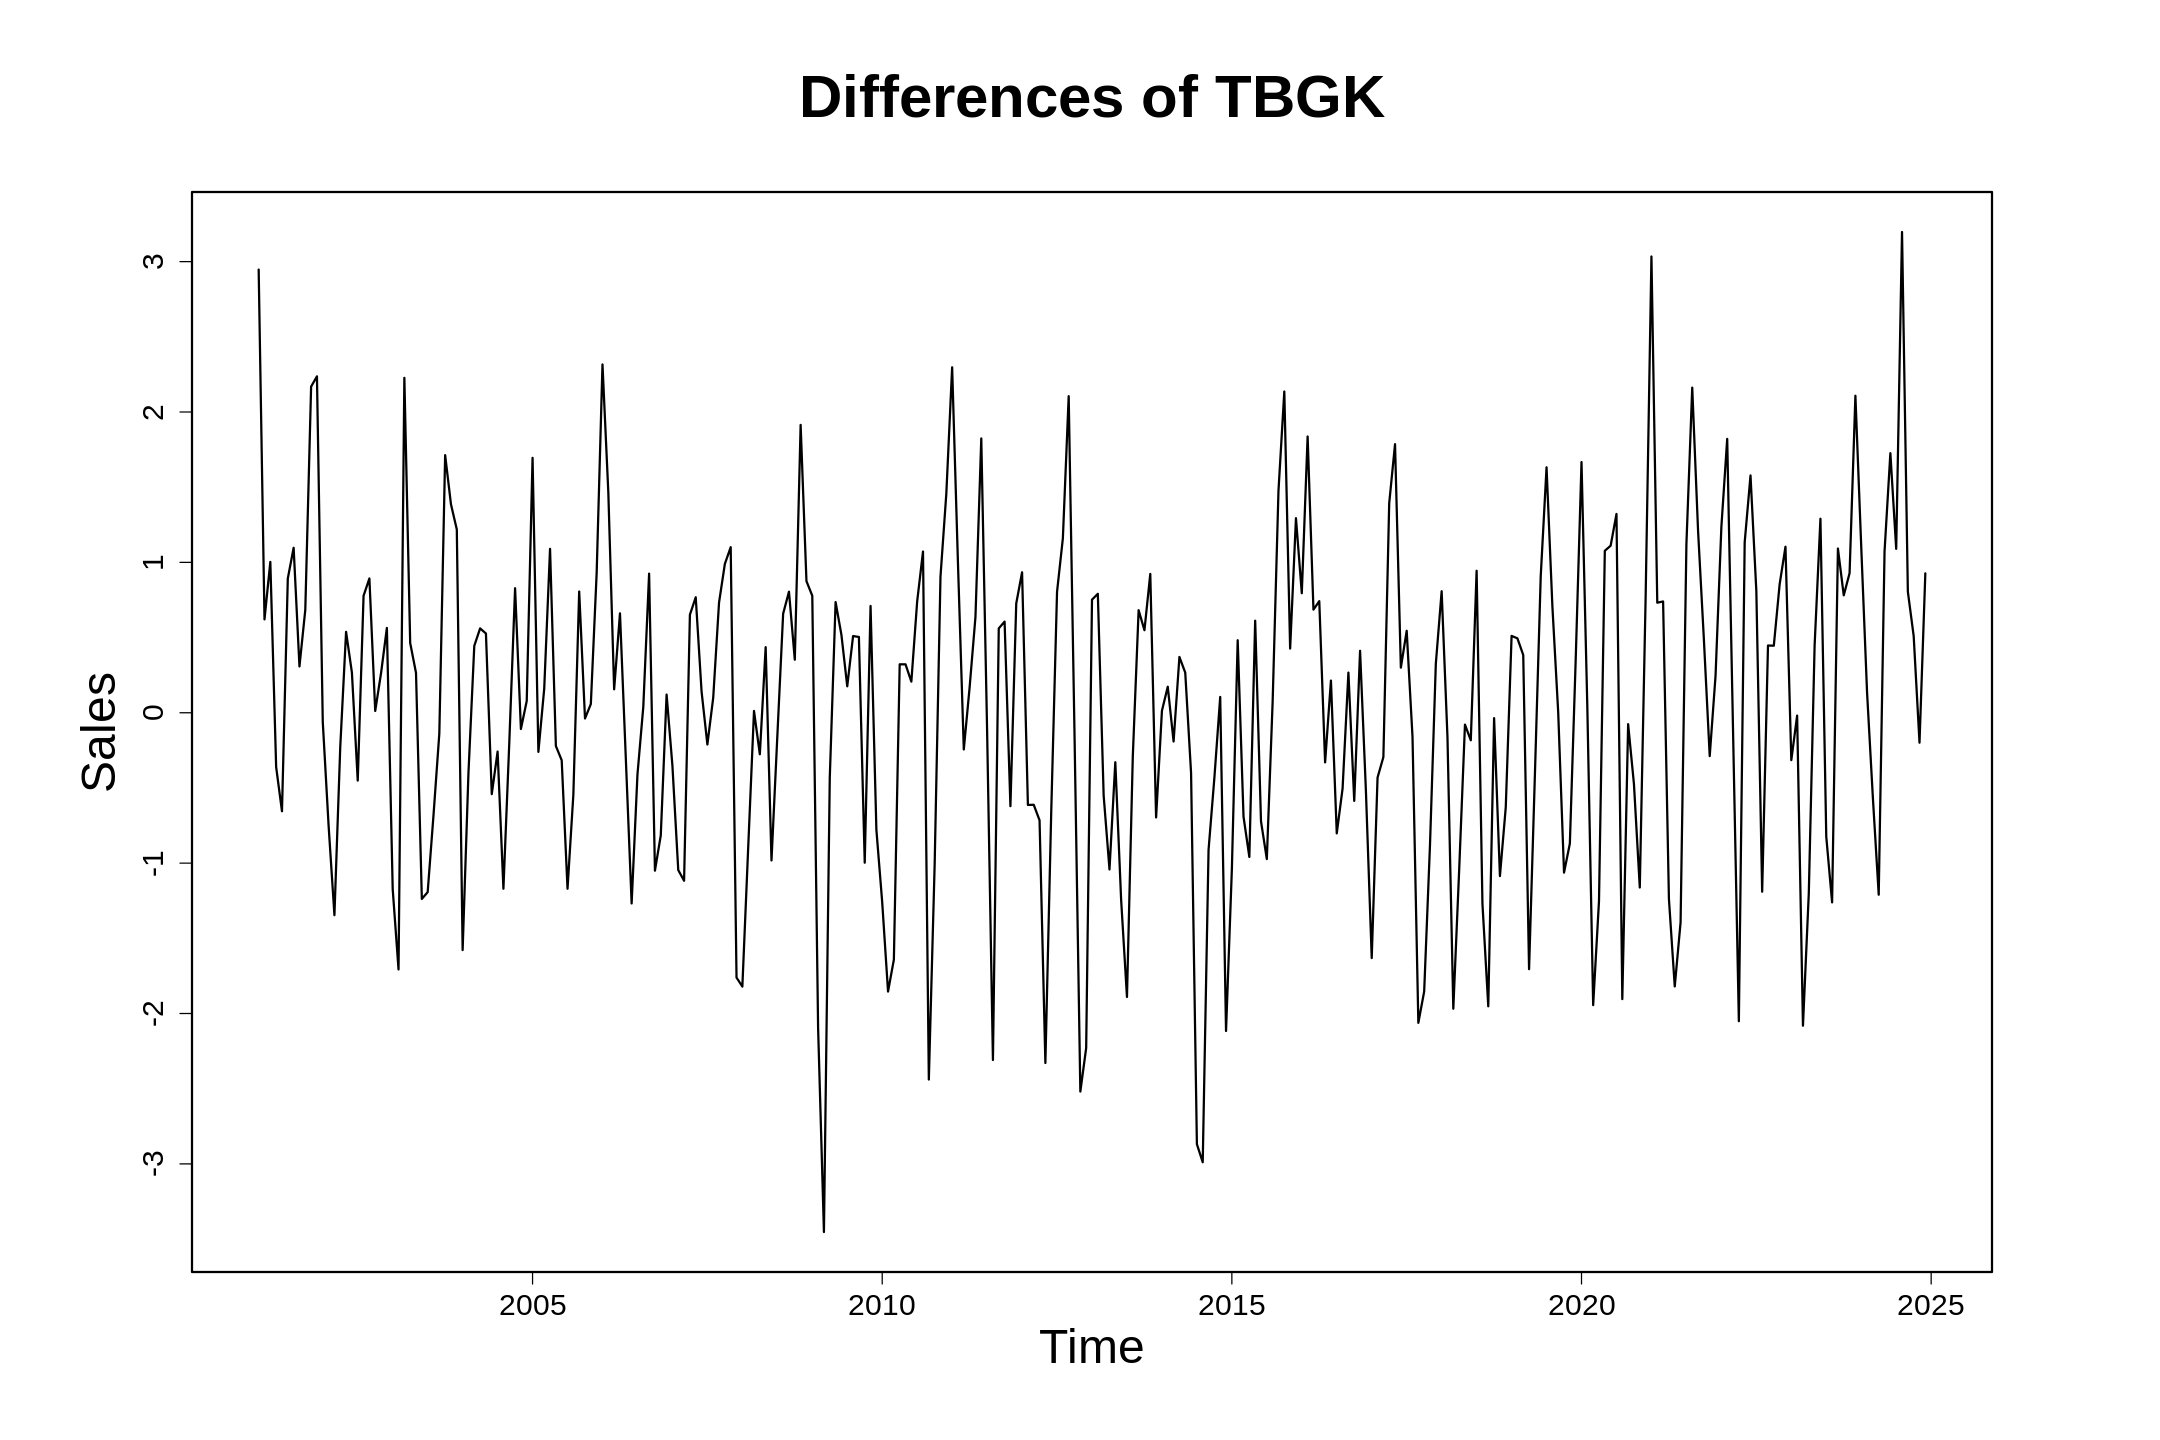

In [77]:
fplot(plot, dTBGK, main="Differences of TBGK")

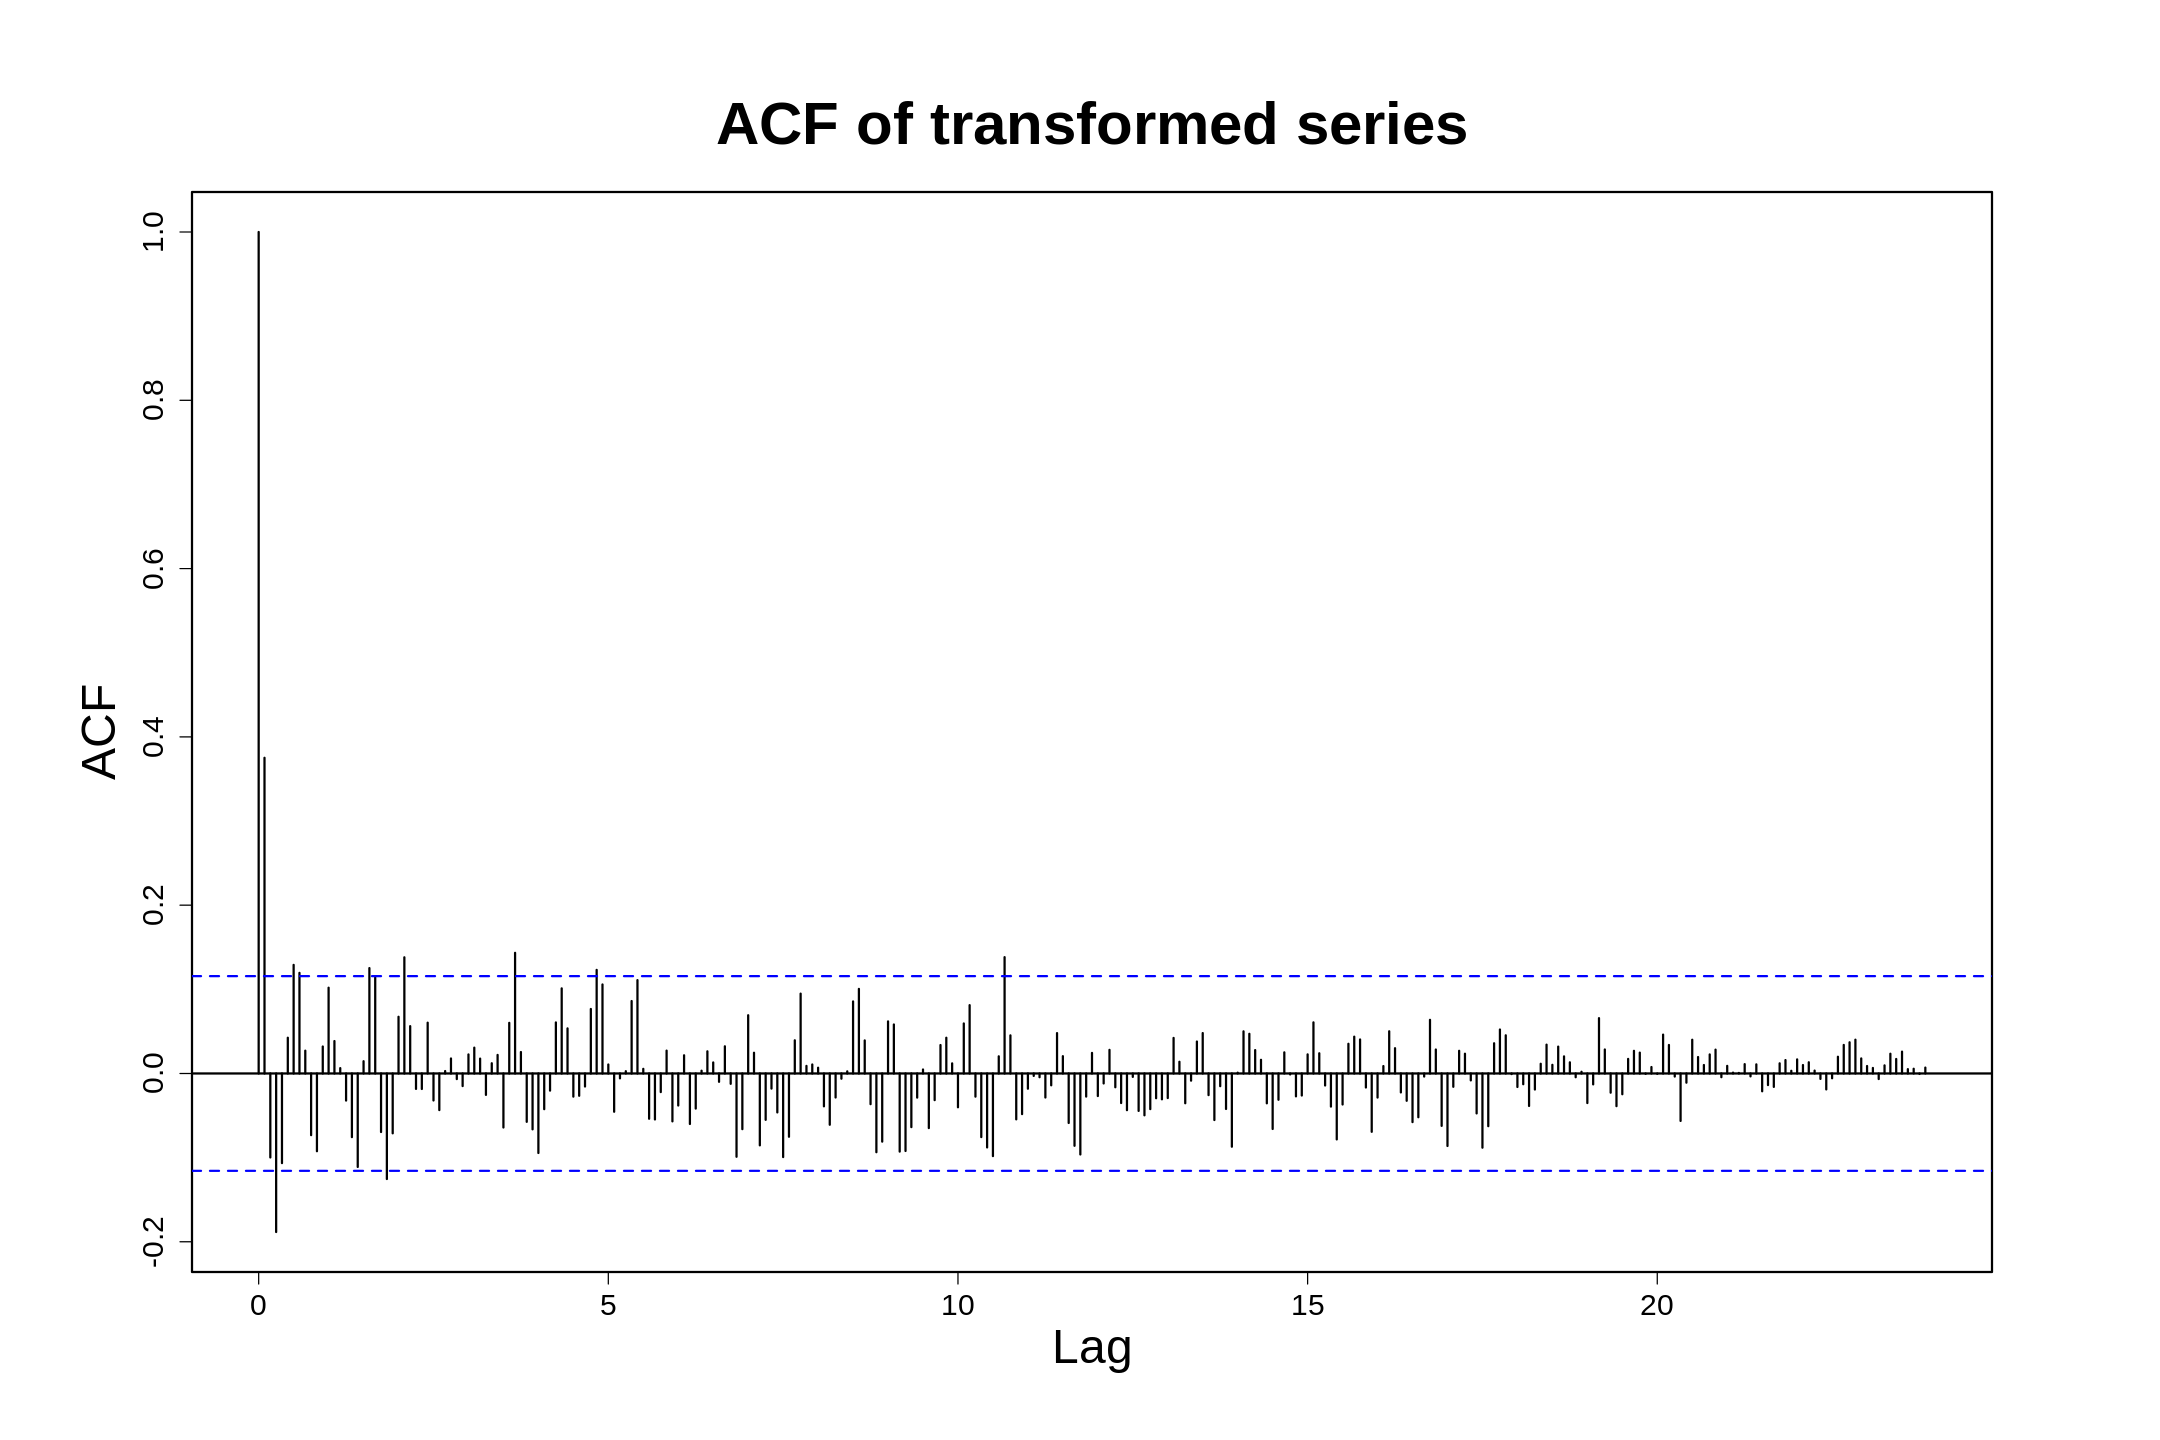

In [78]:
fplot(acf, dTBGK,lag = 1000, main = "ACF of transformed series")

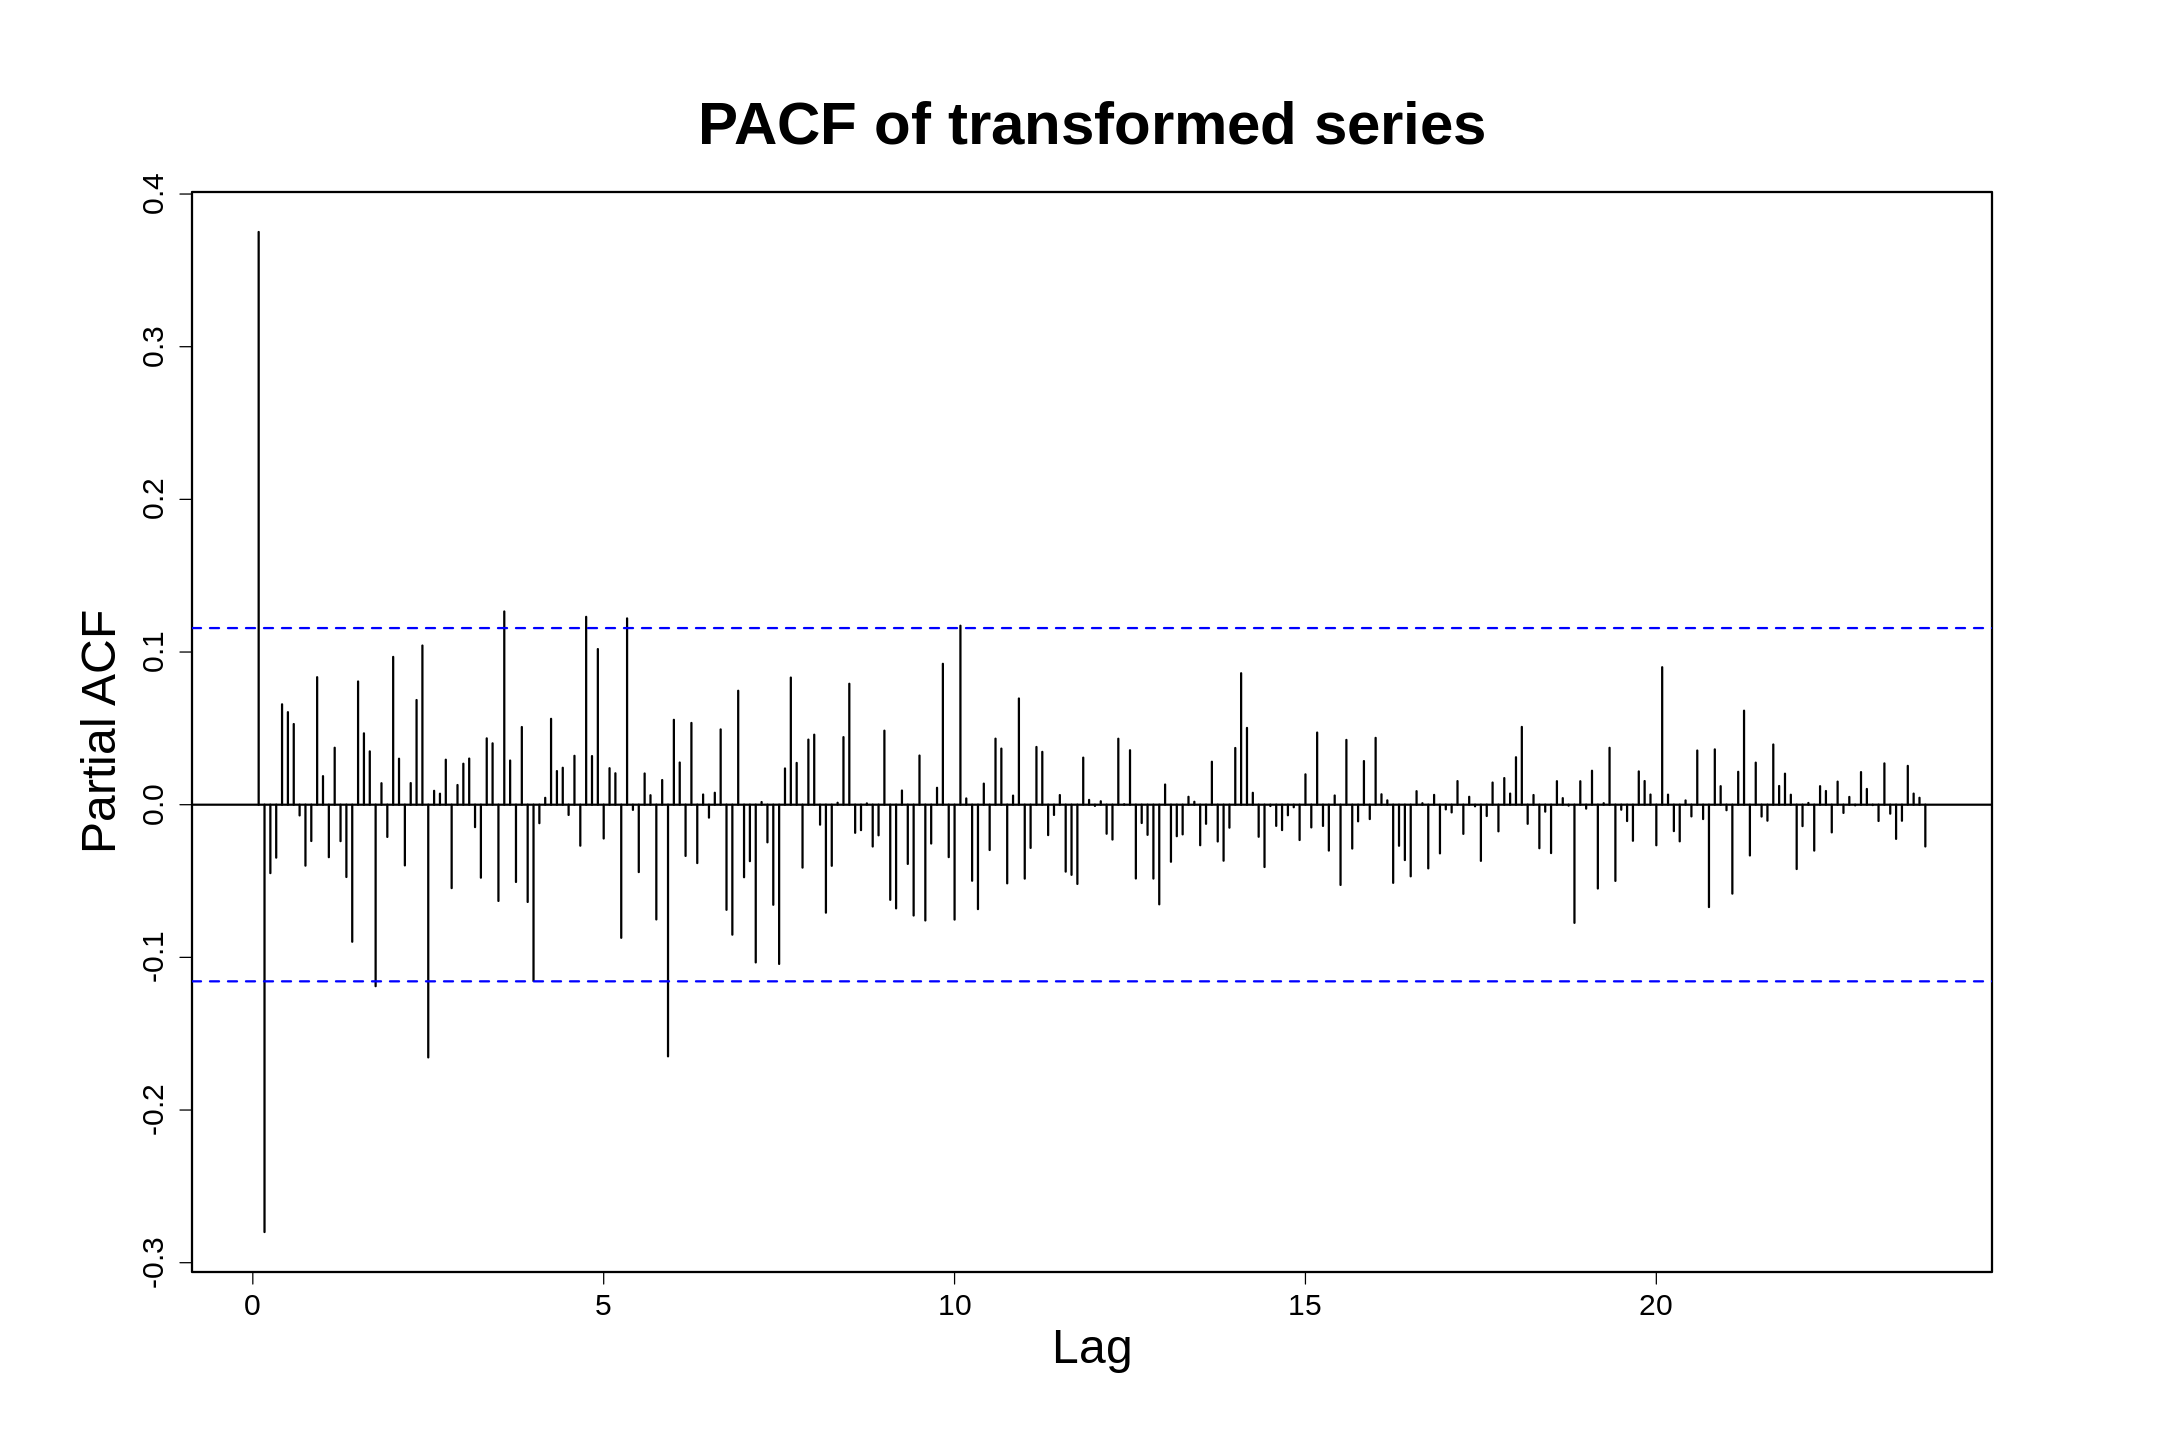

In [79]:
fplot(pacf, dTBGK,lag=1000, main = "PACF of transformed series")

In [80]:
inverse_tranform <- inverse_diff_transform_generator(ndiff=1, inits=list(TBGK[1]))

In [81]:
model1 <- auto.arima(dTBGK)
summary(model1)

Series: dTBGK 
ARIMA(2,0,0)(1,0,0)[12] with zero mean 

Coefficients:
         ar1      ar2    sar1
      0.4926  -0.2810  0.0842
s.e.  0.0574   0.0575  0.0615

sigma^2 = 1.009:  log likelihood = -407.16
AIC=822.33   AICc=822.47   BIC=836.97

Training set error measures:
                     ME     RMSE       MAE     MPE     MAPE      MASE
Training set 0.03389025 0.999036 0.7936823 101.928 186.7899 0.6745745
                    ACF1
Training set -0.01880827

In [82]:
residuals <- residuals(model1)

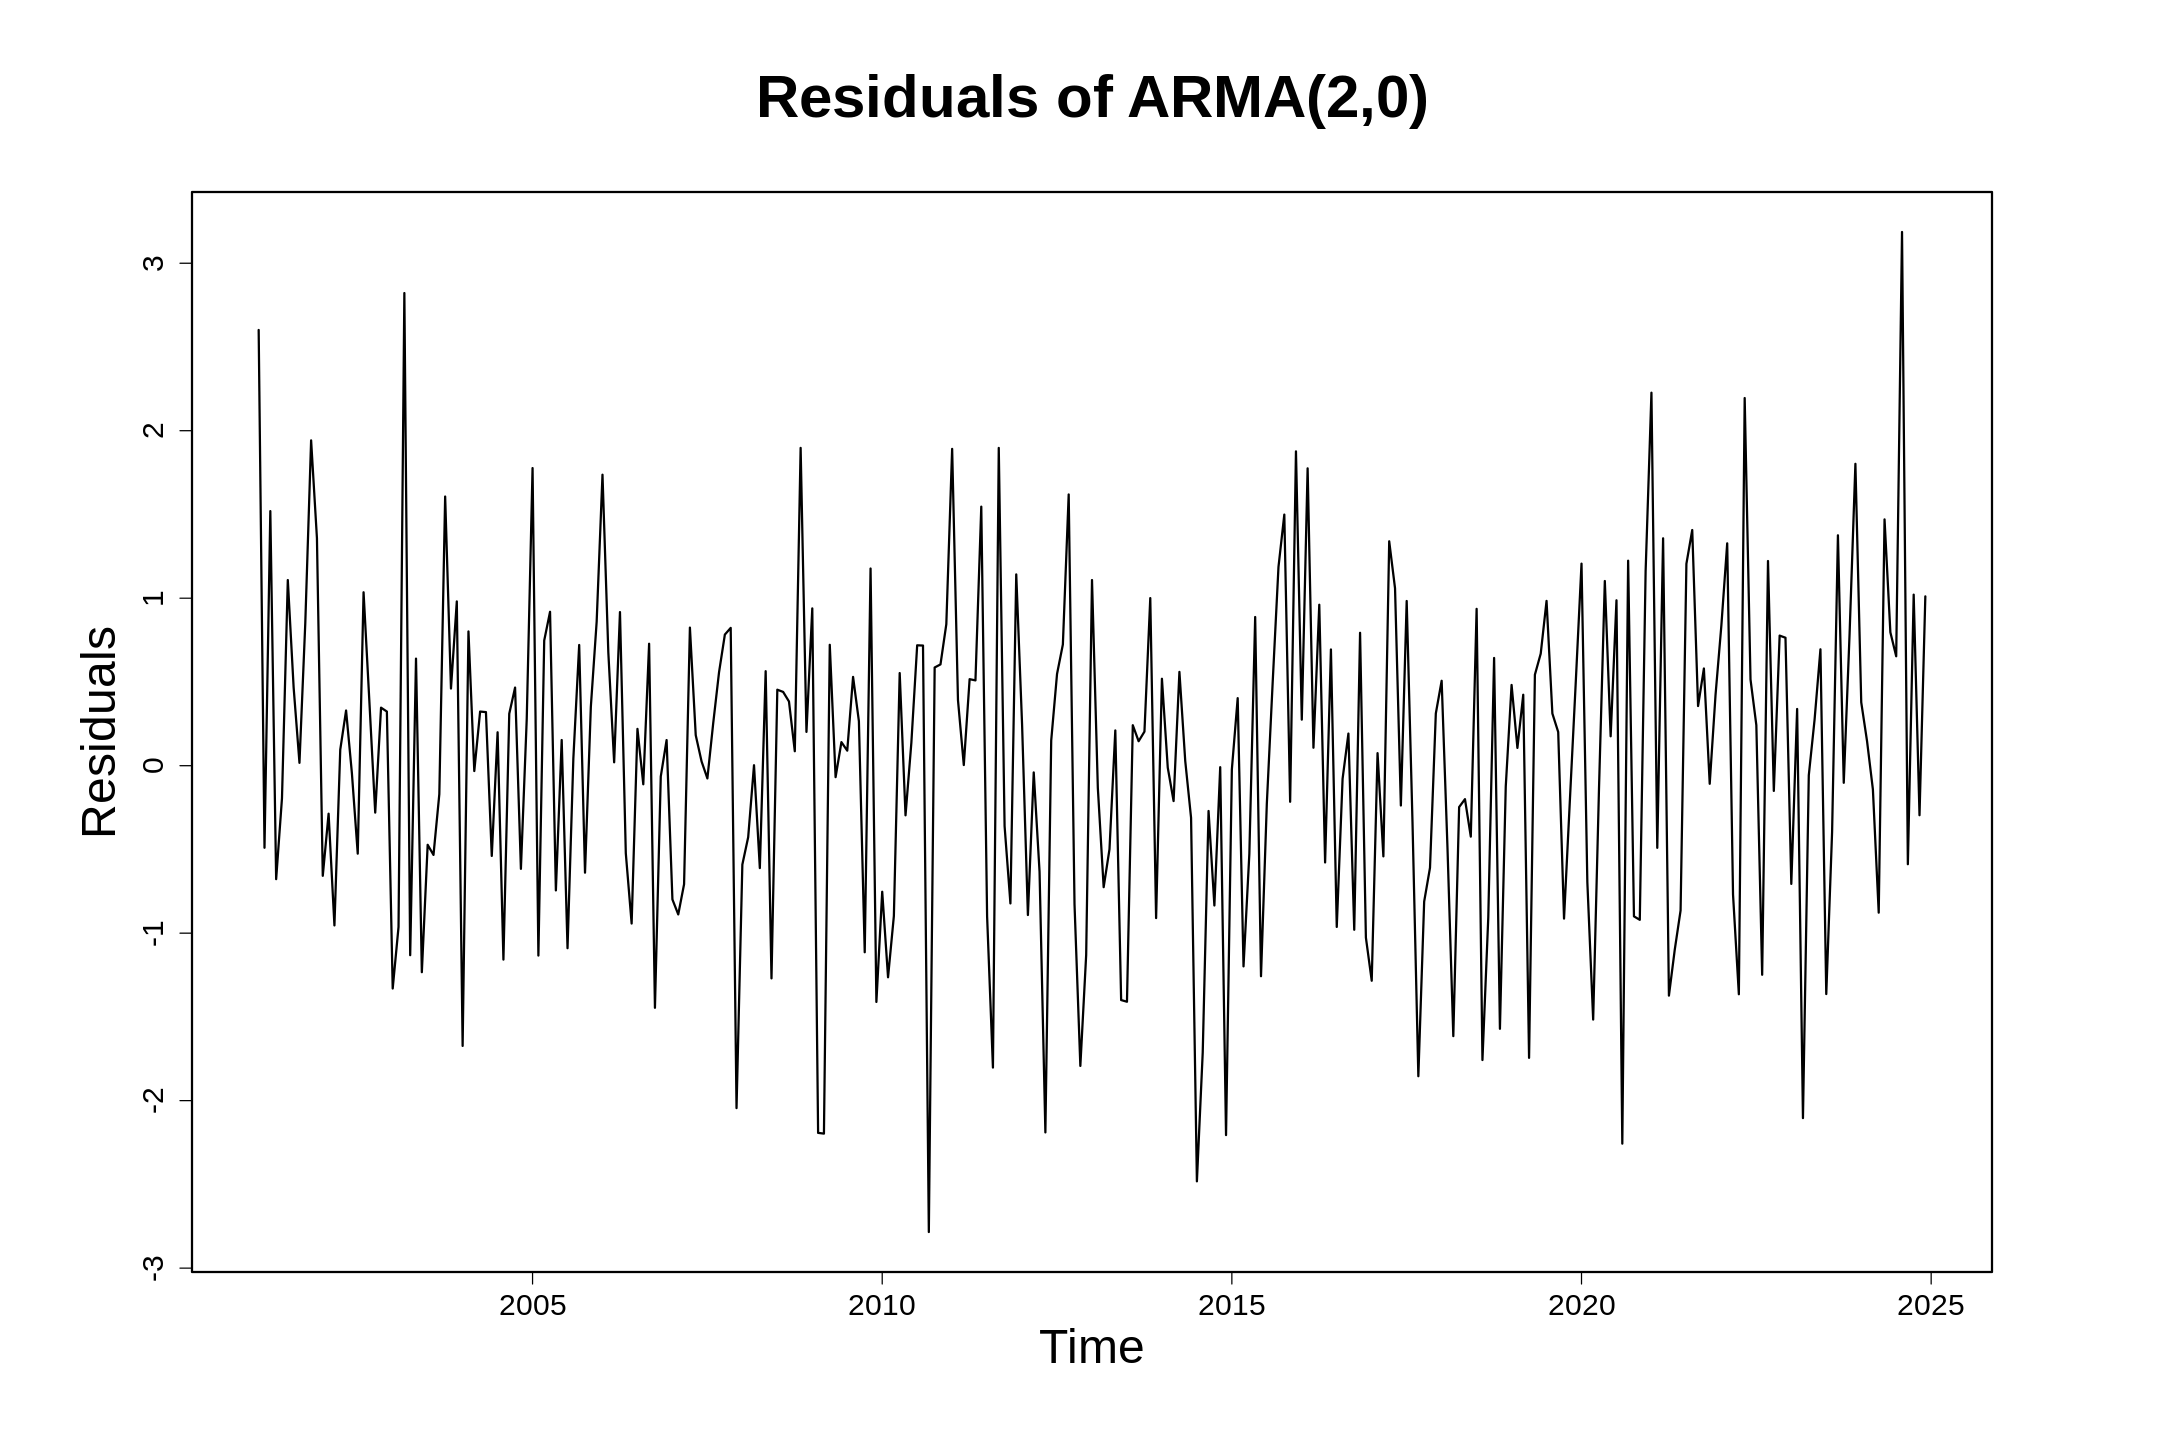

In [83]:
fplot(plot, residuals, main="Residuals of ARMA(2,0)", ylab="Residuals", xlab="Time", type="l")

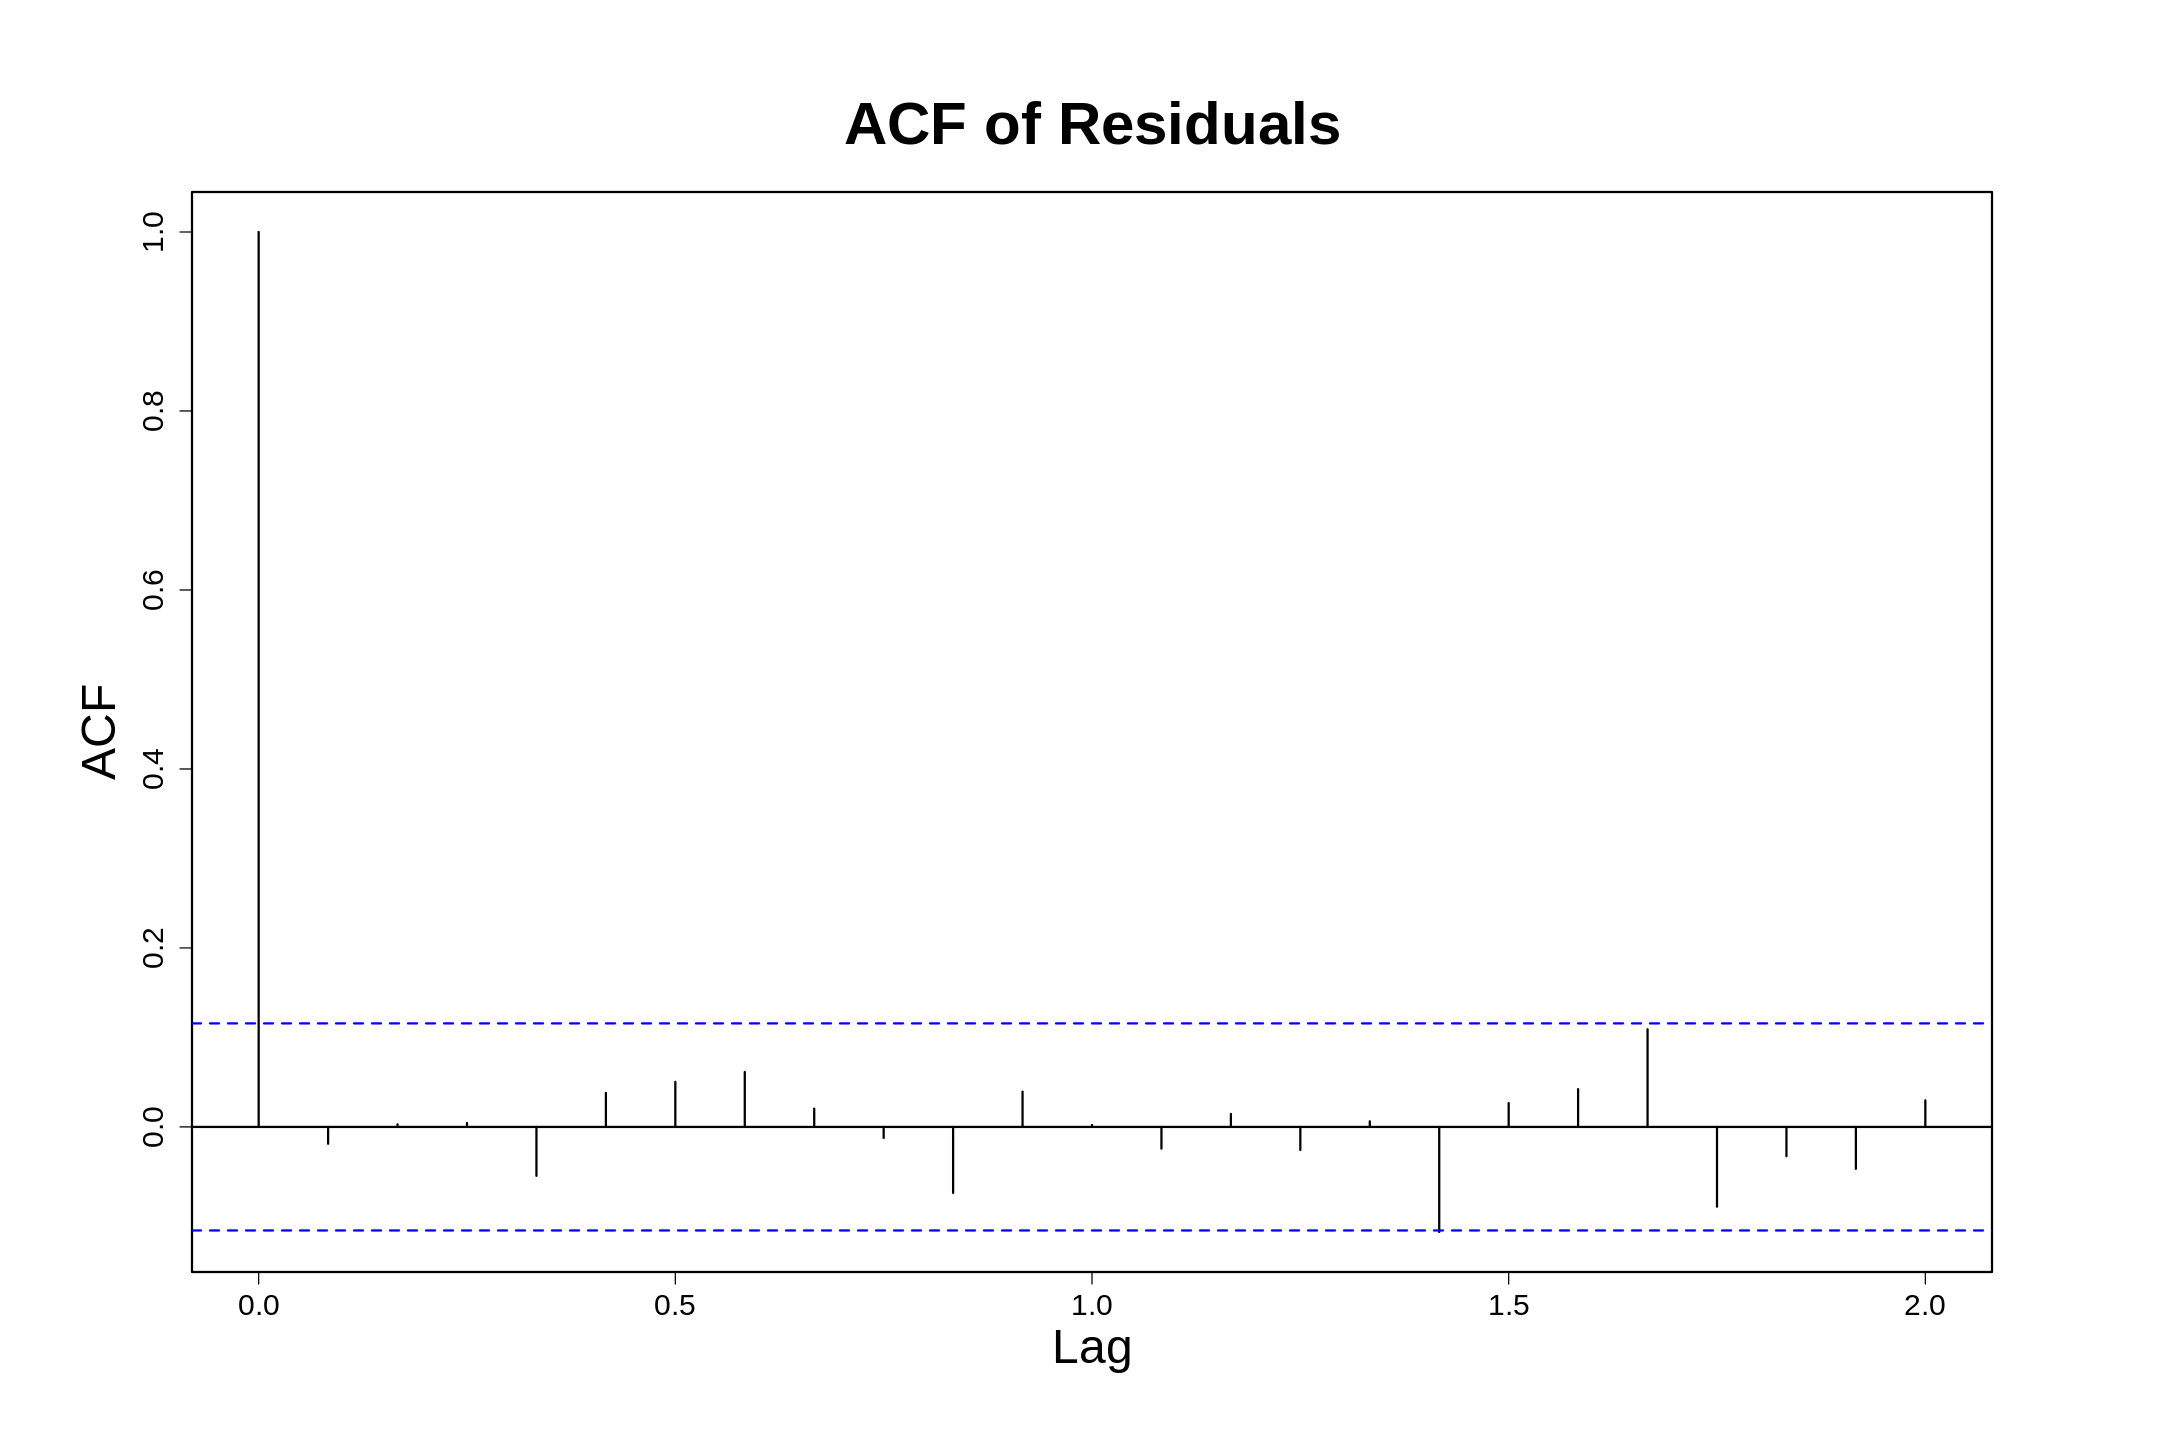

In [84]:
fplot(acf, residuals, main="ACF of Residuals")

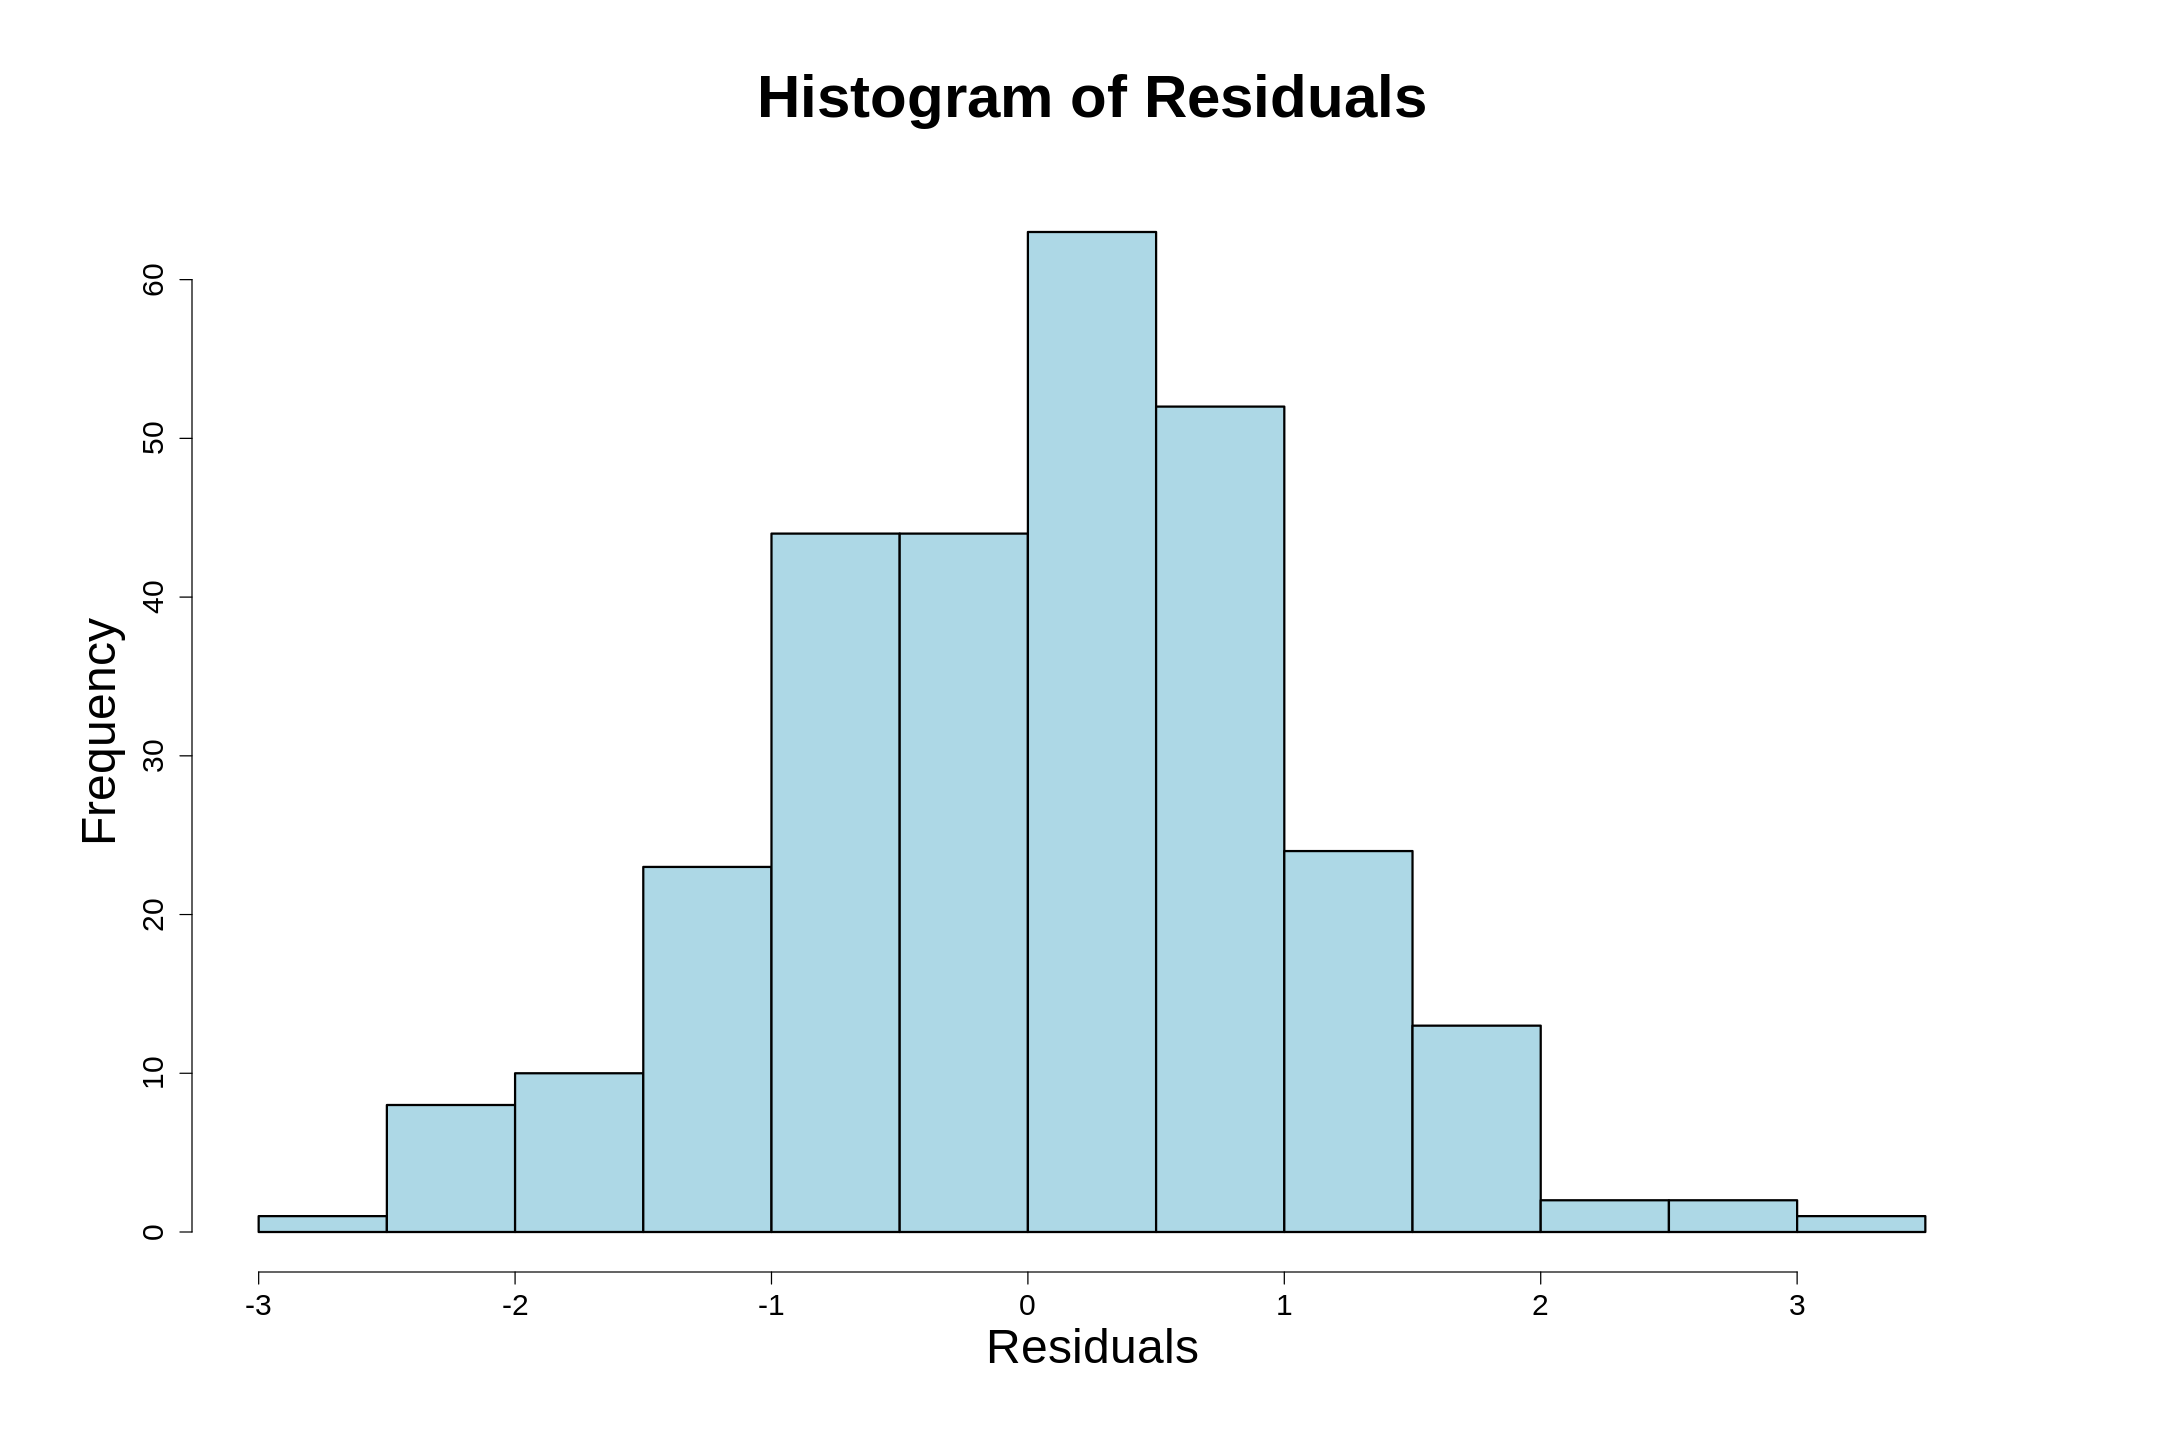

In [85]:
fplot(hist, residuals, main="Histogram of Residuals", xlab="Residuals", col="lightblue")

In [86]:
shapiro.test(residuals)
Box.test(residuals, lag=20, type="Ljung-Box")


	Shapiro-Wilk normality test

data:  residuals
W = 0.99544, p-value = 0.5644



	Box-Ljung test

data:  residuals
X-squared = 14.702, df = 20, p-value = 0.7932


In [87]:
future <- predict(model1,n.ahead = 12)
prederrorh <- future$pred+future$se
prederrorl <- future$pred-future$se

predTBGK <- ts(inverse_tranform(c(dTBGK,future$pred)),start=start(TBGK),frequency=12)

intprederrorh <- cumsum(c(TBGK[length(TBGK)],prederrorh))
intprederrorl <- cumsum(c(TBGK[length(TBGK)],prederrorl))

intprederrorh <- intprederrorh[2:13]
intprederrorl <- intprederrorl[2:13]

xx <- c(time(prederrorh),rev(time(prederrorh)))
yy <- c(intprederrorl,rev(intprederrorh))

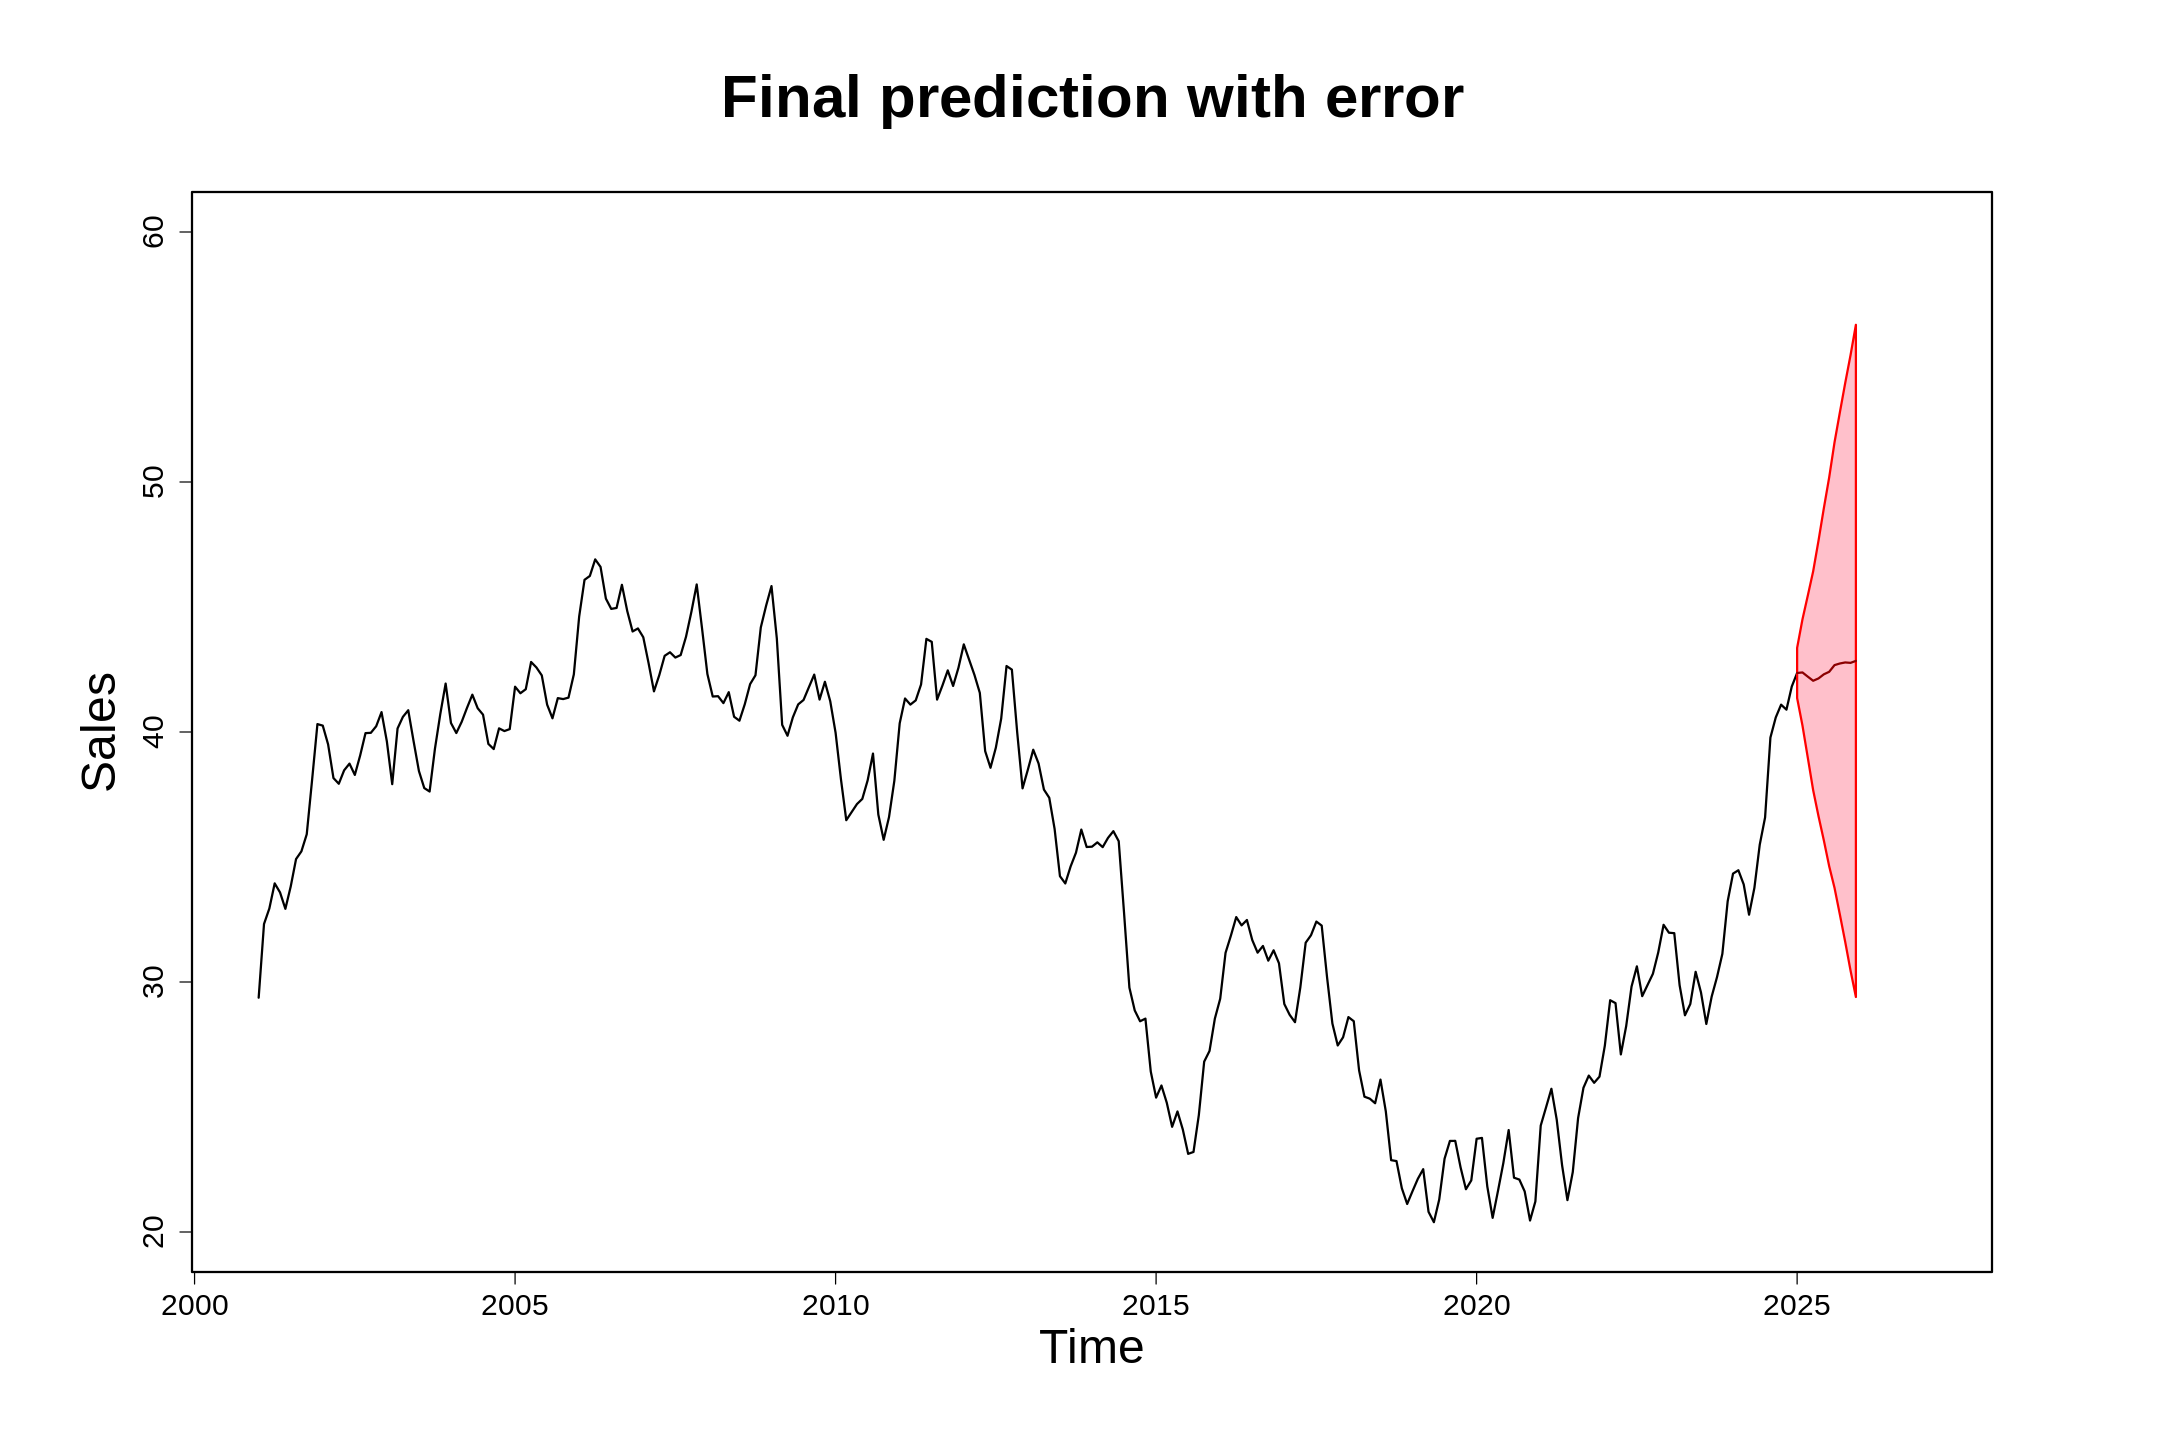

In [88]:
fplot(plot.ts, predTBGK,xlim=c(2001,2027),ylim=c(20,60), main="Final prediction with error", ylab="Sales")
fplot(polygon, xx, yy, col="pink", border="red")
fplot(lines, xx[1:12],predTBGK[289:300],col="darkred")

In [89]:
model <- arima(dTBGK, order = c(2,0,4), include.mean = FALSE)

In [90]:
future <- predict(model,n.ahead = 12)
prederrorh <- future$pred+future$se
prederrorl <- future$pred-future$se

predTBGK <- ts(inverse_tranform(c(dTBGK,future$pred)),start=start(TBGK),frequency=12)

intprederrorh <- cumsum(c(TBGK[length(TBGK)],prederrorh))
intprederrorl <- cumsum(c(TBGK[length(TBGK)],prederrorl))

intprederrorh <- intprederrorh[2:13]
intprederrorl <- intprederrorl[2:13]

xx <- c(time(prederrorh),rev(time(prederrorh)))
yy <- c(intprederrorl,rev(intprederrorh))



In [91]:
summary(model)


Call:
arima(x = dTBGK, order = c(2, 0, 4), include.mean = FALSE)

Coefficients:
         ar1      ar2      ma1     ma2     ma3      ma4
      1.0625  -0.9159  -0.5863  0.3713  0.3702  -0.0076
s.e.  0.0713   0.0758   0.0929  0.0949  0.0890   0.0660

sigma^2 estimated as 0.9821:  log likelihood = -404.91,  aic = 823.83

Training set error measures:
                     ME      RMSE       MAE      MPE     MAPE      MASE
Training set 0.03395337 0.9909852 0.7863698 99.24152 186.7568 0.7870027
                     ACF1
Training set -0.009325268

In [92]:
residuals <- residuals(model)

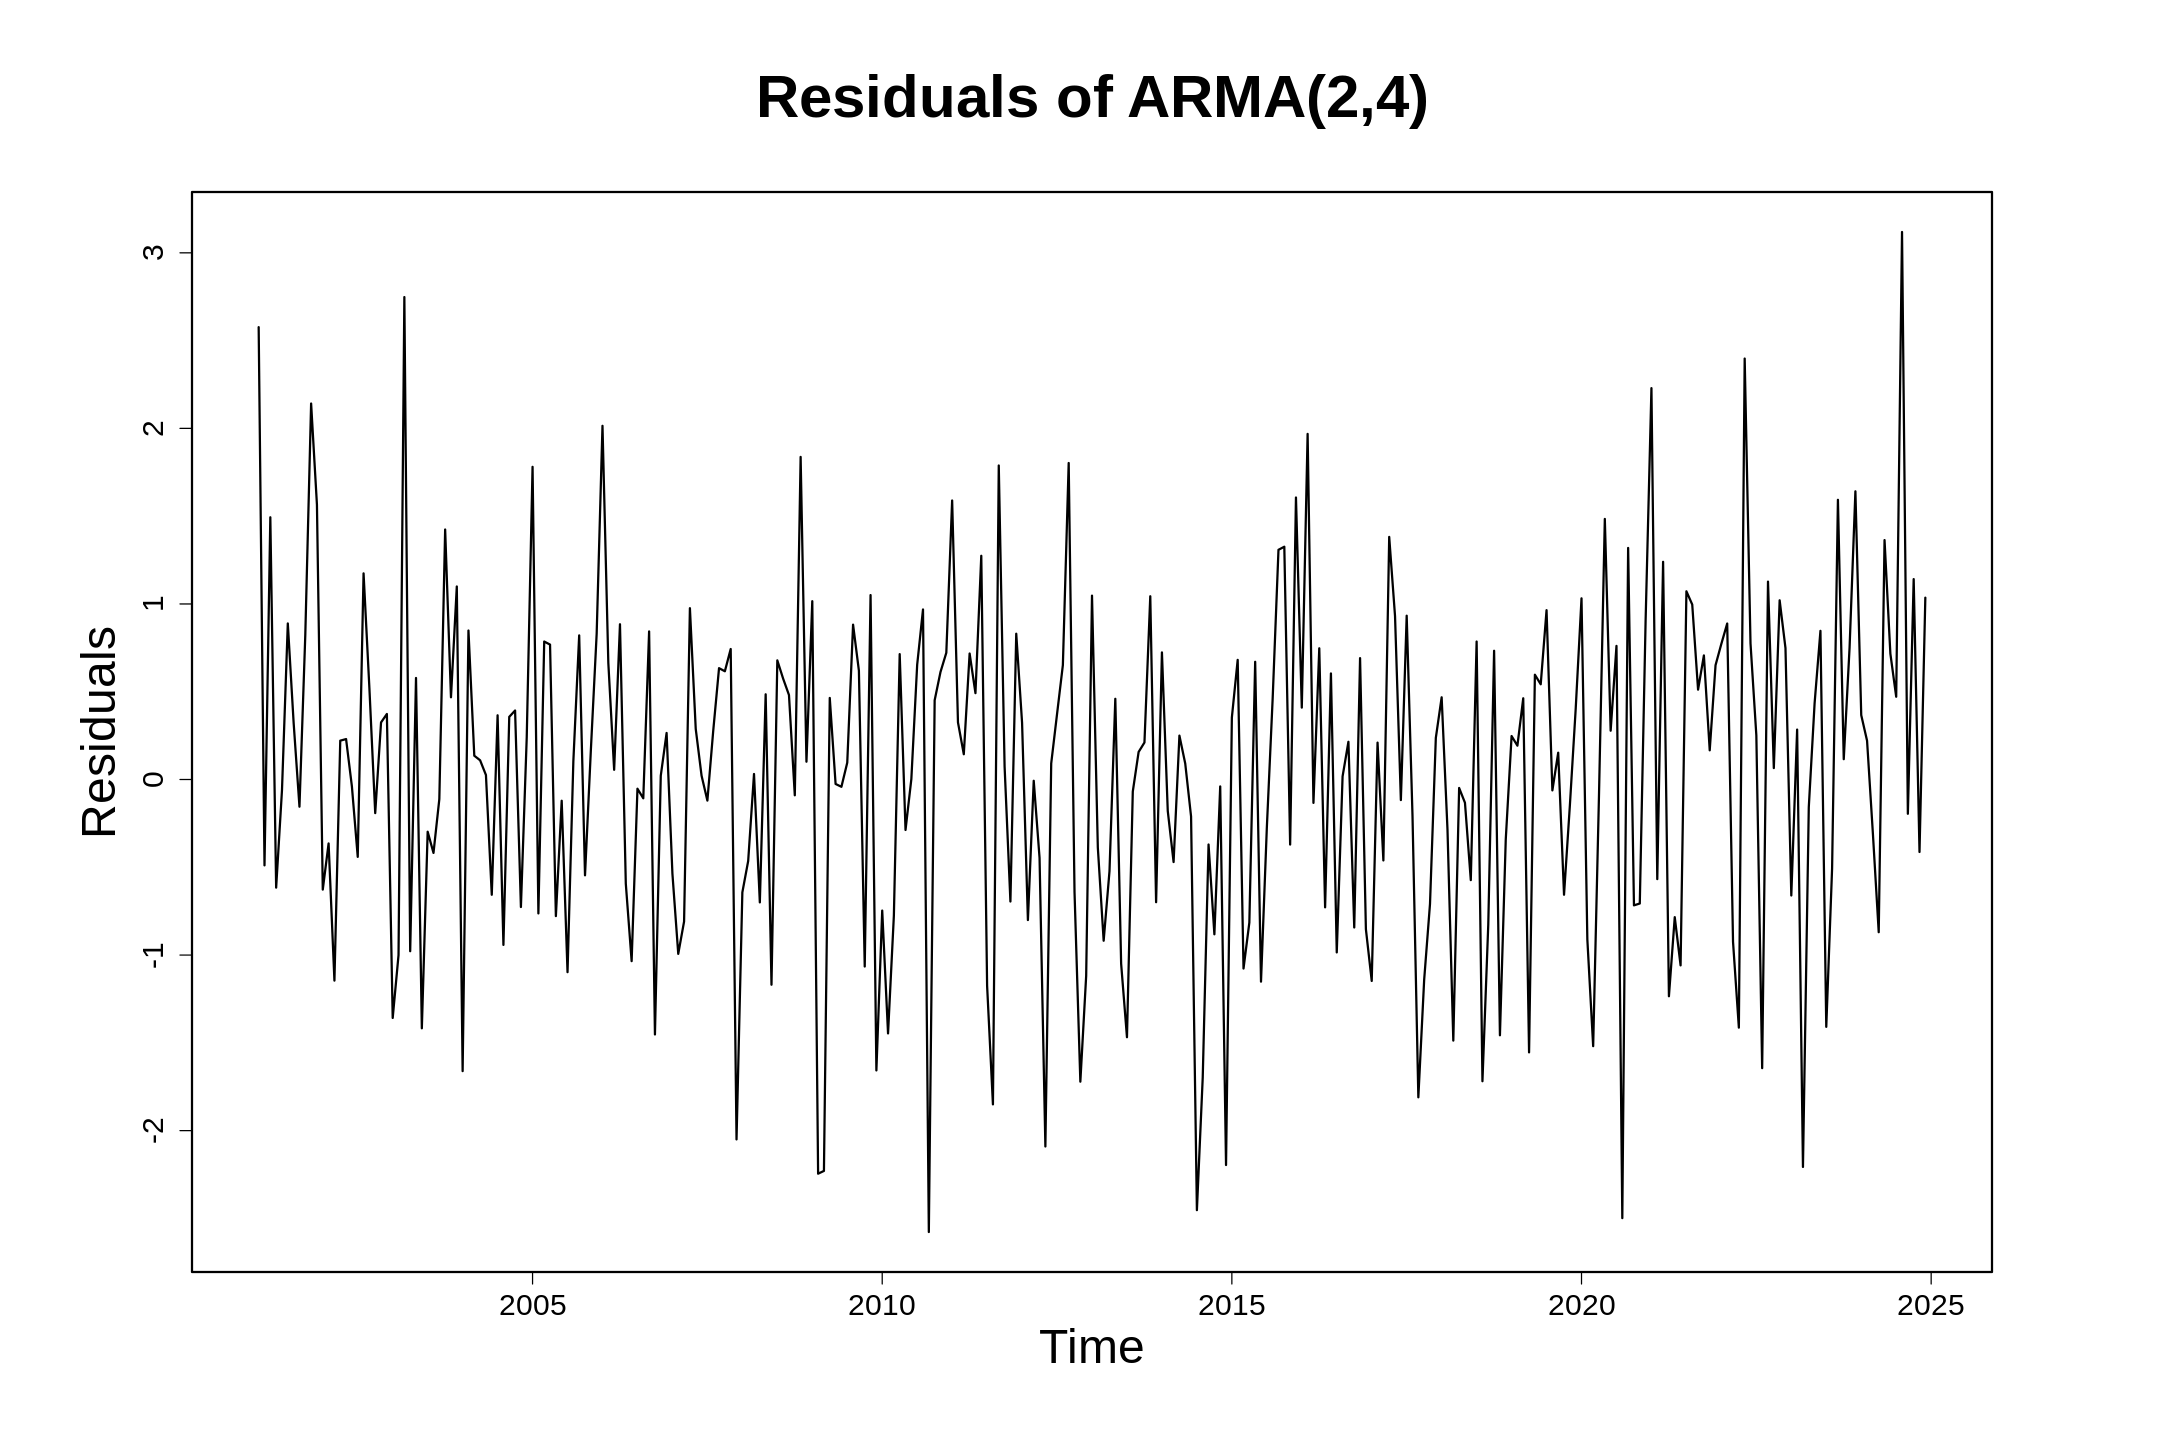

In [93]:
fplot(plot, residuals, main="Residuals of ARMA(2,4)", ylab="Residuals", xlab="Time", type="l")

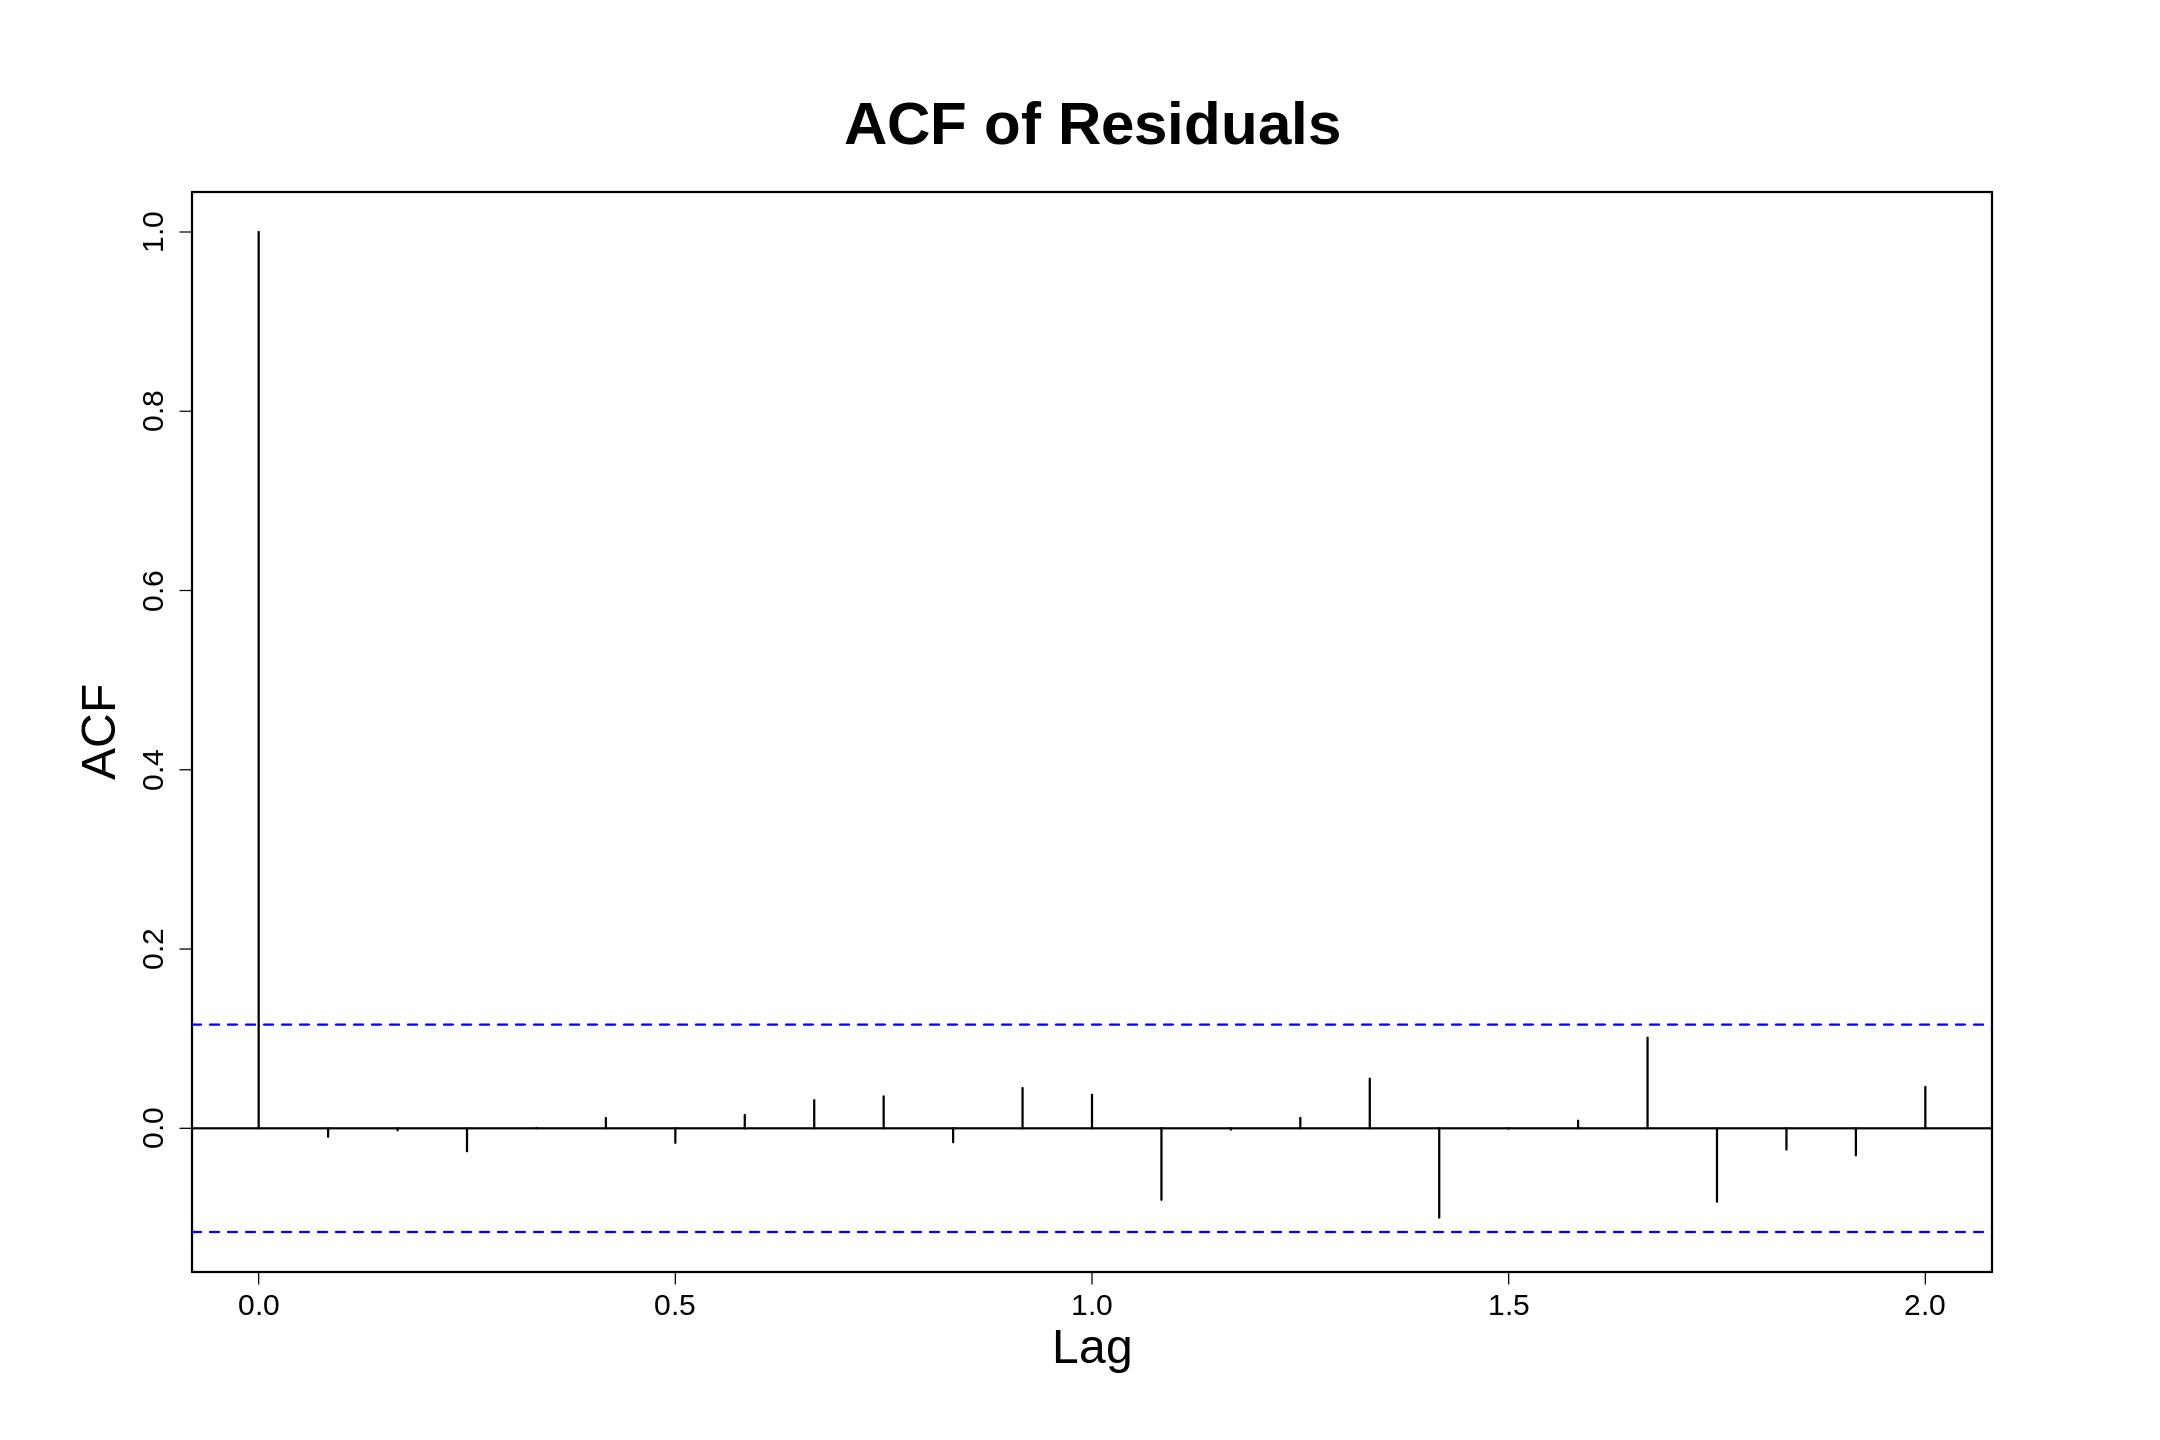

In [94]:
fplot(acf, residuals, main="ACF of Residuals")

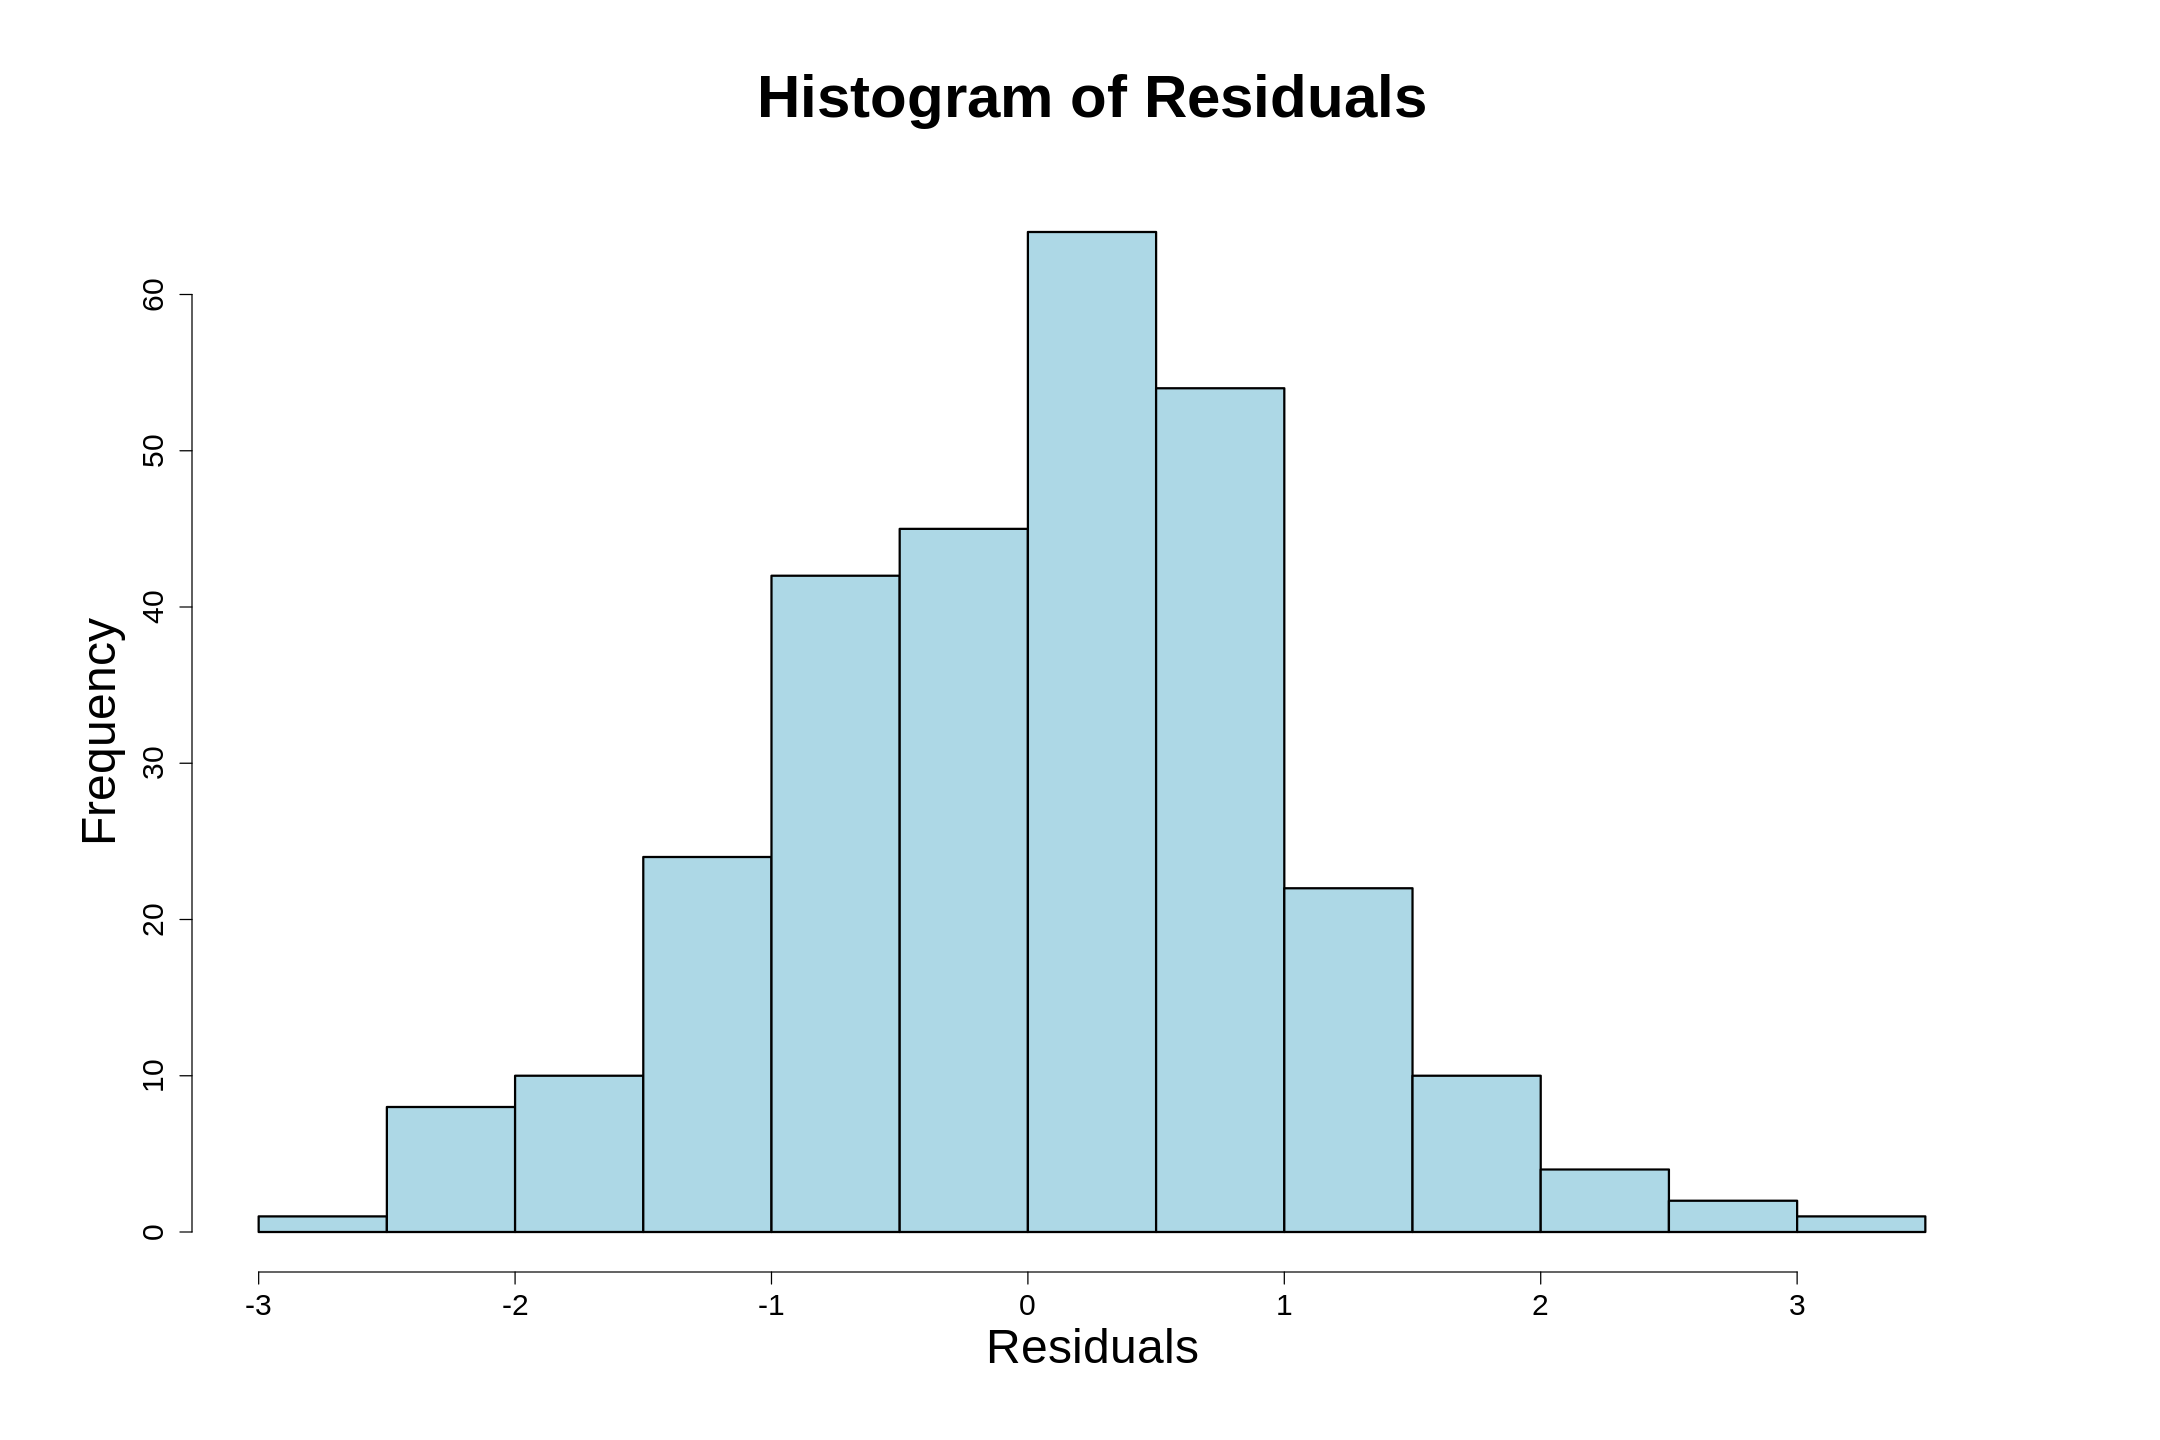

In [95]:
fplot(hist, residuals, main="Histogram of Residuals", xlab="Residuals", col="lightblue")

In [96]:
shapiro.test(residuals)
Box.test(residuals, lag=20, type="Ljung-Box")


	Shapiro-Wilk normality test

data:  residuals
W = 0.99348, p-value = 0.2491



	Box-Ljung test

data:  residuals
X-squared = 11.321, df = 20, p-value = 0.9375


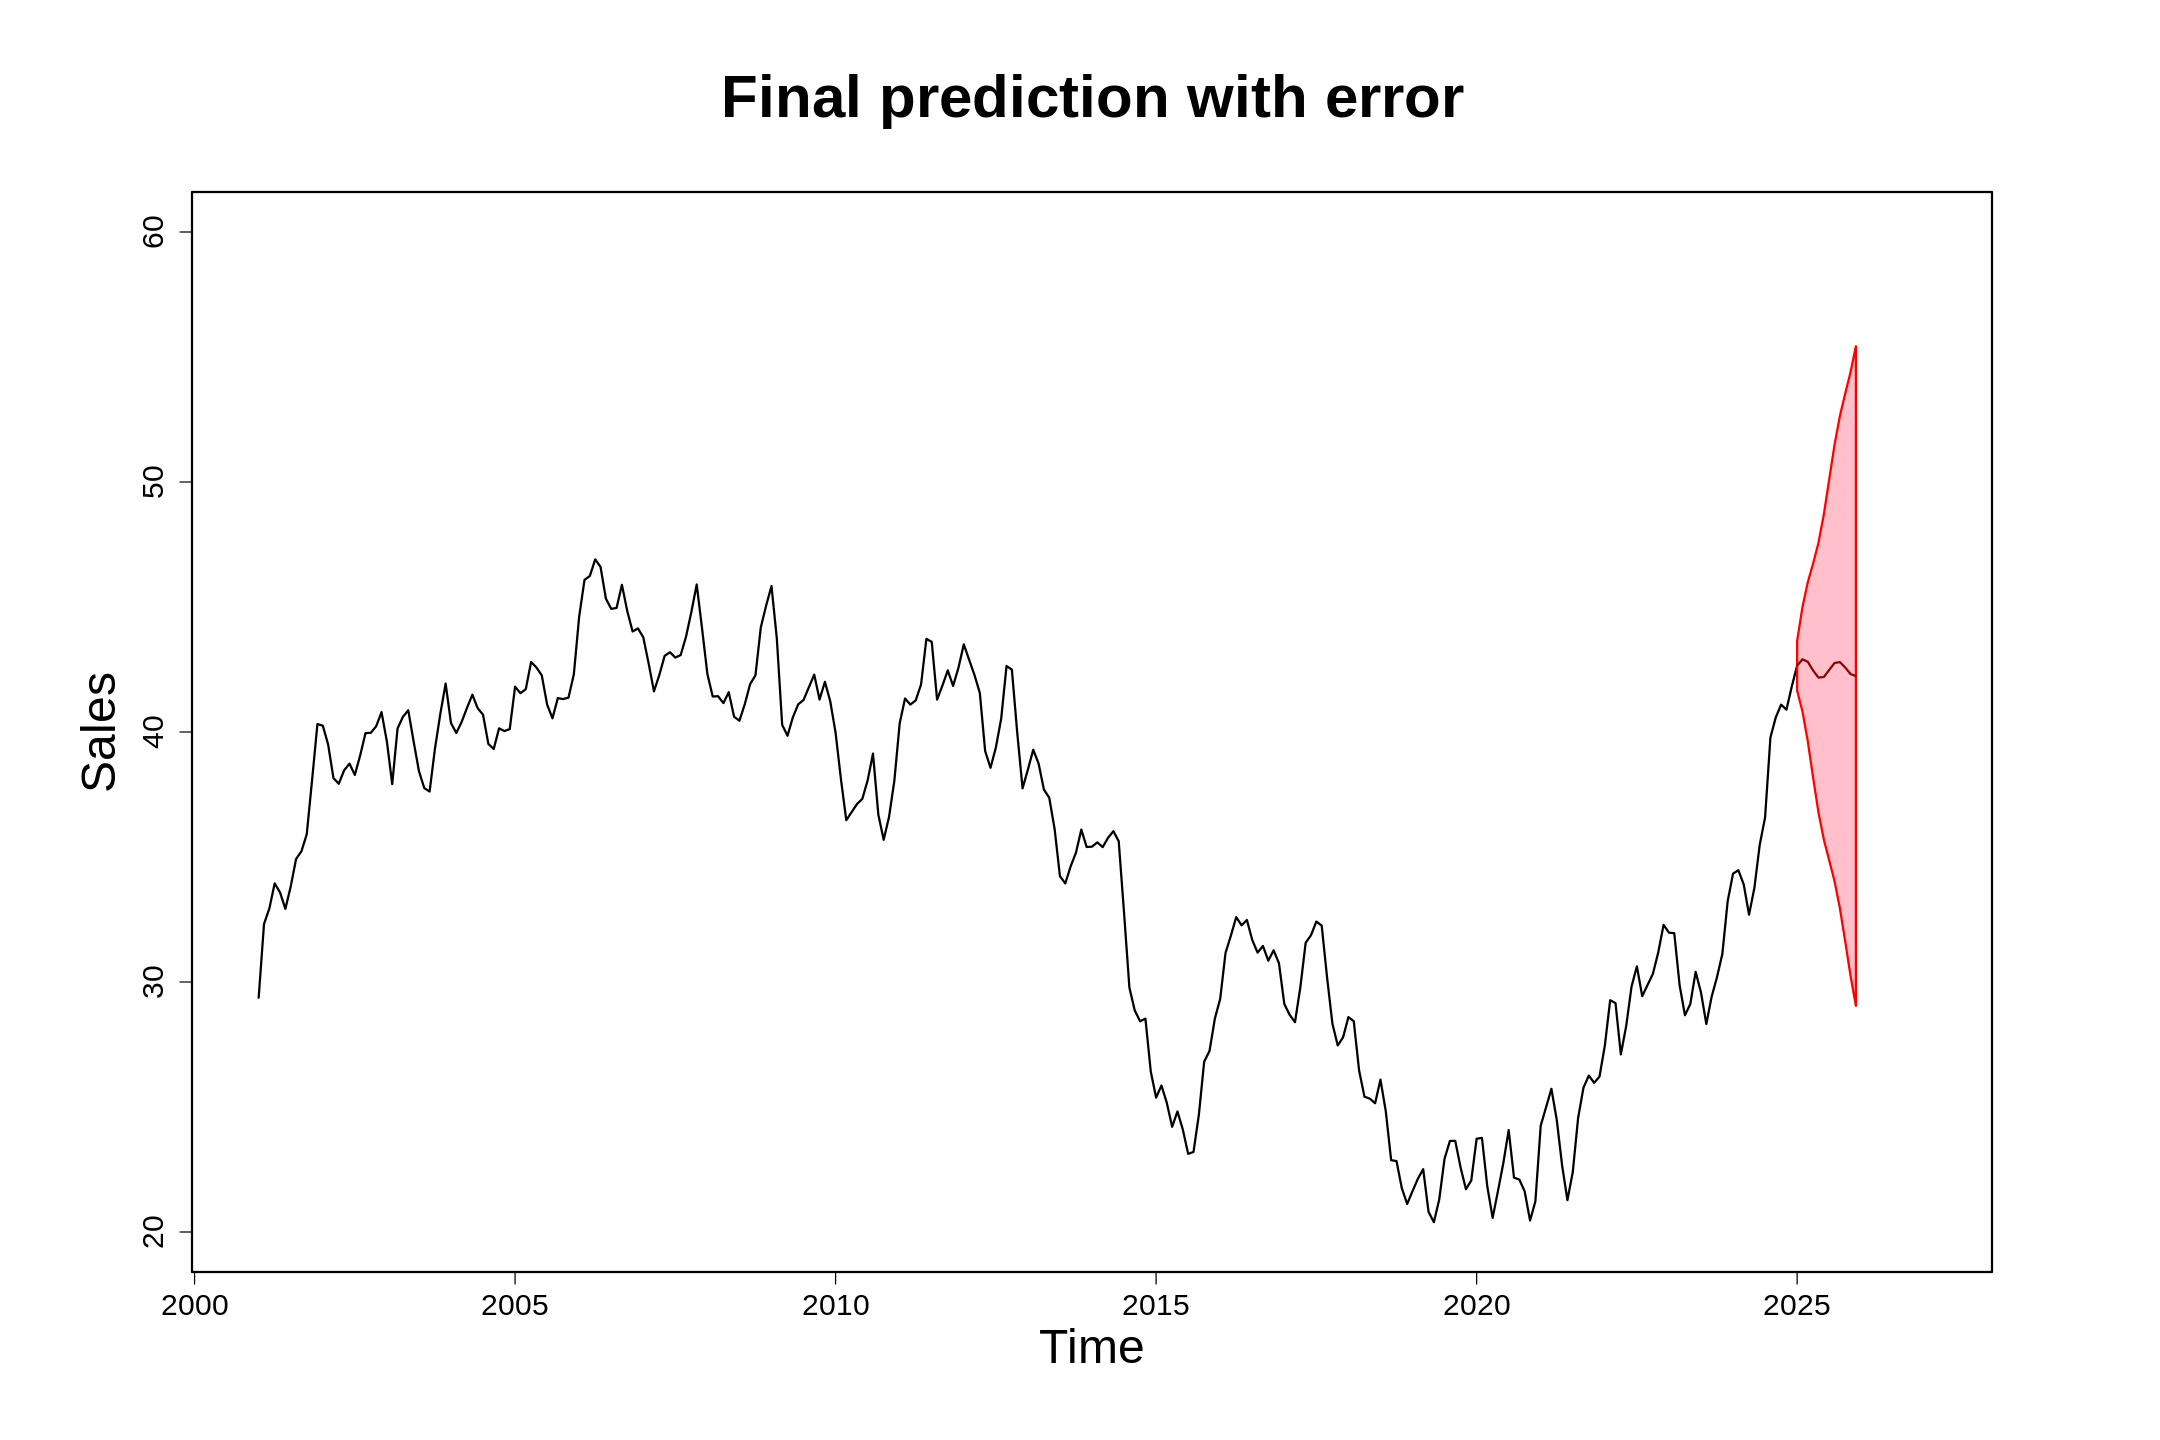

In [97]:
fplot(plot.ts, predTBGK,xlim=c(2001,2027),ylim=c(20,60), main="Final prediction with error", ylab="Sales")
fplot(polygon, xx, yy, col="pink", border="red")
fplot(lines, xx[1:12],predTBGK[289:300],col="darkred")

🐉

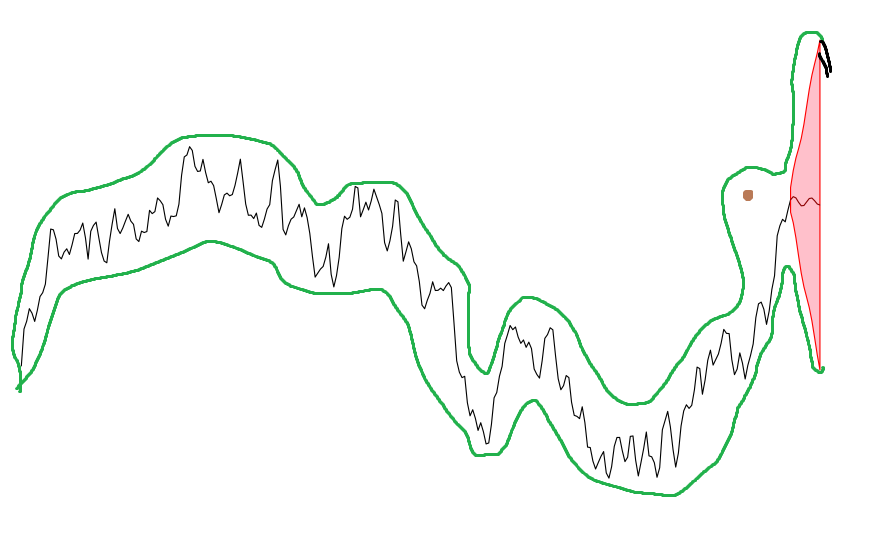

🐍